In [1]:
import csv
import pickle
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import math
import sklearn.cluster
from math import floor, ceil

# Reading Data from Files

In [2]:
fileprefix = "full" # pilot_#, final
datafolder = '../results/anonymized_data/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

# Creating Trial Dataframe

In [3]:
# Choose which experiment data to use, or to combine
# 1 = original experiment
# 2 = replication experiment
# all = both experiments combined
data_to_use_master = "all" # "1", "2", or "all"

In [4]:
# Each participant has their own file, generated from the Heroku postgres output in the 
# preprocessing notebook

part_stats_dicts = []
extract_max_trials = 40
for file in all_part_paths:
    replication = "full_r" in file
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    numClicks = []
    timeFirstAction = []
    timeFirstClick = []
    avgClickLevel = []
    trialClicksL1 = []
    trialClicksL2 = []
    trialClicksL3 = []
    trialClicksL4 = []
    trialClicksL5 = []
    reached_max_trials = False
    demographicsAvailable = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    
    print(participant['workerId'])
    # Extract length of experiment
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
    except:
        print("No data")
        continue
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    # Dictionary to check whether mouselab task has been completed
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    
    # Use state machine to parse participant trial data, update state 
    #  based on trials seen
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    whatStrategy = ""
    firstLevelAns = {}
    strategyImprove = ""
    difficult = ""
    clickStratsValid = True
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
    
        # Start mouselab trials
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        # Finish mouselab trials
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
        
        # Mouselab trial encountered
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                if extract_max_trials and len(trialScores) == extract_max_trials:
                    if not reached_max_trials:
                        reached_max_trials = True
                        print(f"!!! More than {extract_max_trials} trials found !!!")
                    continue
                    
                # Trial length
                trialLengths.append(trial['trialdata']['trialTime'])
                
                # Score obtained on trial
                trialScores.append(trial['trialdata']['score'])
                
                # Recording the times at which actions were taken
                timeFirstAction.append(trial['trialdata']['actionTimes'][0])
                
                # Getting expected scores based on revealed rewards
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('large_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                
                # Recording time at which the first click was made
                try:
                    timeFirstClick.append(trial['trialdata']['queries']['click']['state']['time'][0])
                except:
                    timeFirstClick.append(None)
                for click in clicks:
                    try:
                        mEnv.step(int(click))
                    except:
                        print(click)
                        continue
                
                
                # Saving the number of clicks and the average depth of all clicks
                numClicks.append(len(clicks))
                
                # Matching click number to node depth
                clicksL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL2 = len([c for c in clicks if int(c) in [2,13,24]])
                clicksL3 = len([c for c in clicks if int(c) in [3,14,25]])
                clicksL4 = len([c for c in clicks if int(c) in [4,8,15,19,26,30]])
                clicksL5 = len([c for c in clicks if int(c) in [5,6,7,9,10,11,16,17,18,20,21,22,27,28,29,31,32,33]])
                
                # Computing average level of all clicks
                try:
                    avgLevel = (clicksL1 + 2*clicksL2 + 3*clicksL3 + 4*clicksL4 + 5*clicksL5)/len(clicks)
                except:
                    avgLevel = 0
                
                trialClicksL1.append(clicksL1)
                trialClicksL2.append(clicksL2)
                trialClicksL3.append(clicksL3)
                trialClicksL4.append(clicksL4)
                trialClicksL5.append(clicksL5)
                avgClickLevel.append(avgLevel)
                
                # plan quality is expected score of the trial minus costs
                # print(trial['trialdata']['costs'])
                planQuality = mEnv._term_reward() + trial['trialdata']['costs']
                expectedScores.append(planQuality)
        
        # Recording responses to end survey questions
        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
            
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        last_trial = trial

    
    # Check whether participant dropped out by seeing whether any of the phases doesn't have an end timestamp
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
    
    # Reason for which participant data should be excluded (stored with participant data during pre-processing)
    if "excludeReason" in participant:
        excludedReason = participant["excludeReason"]
    else:
        excludedReason = None
    
    clickStratsValid = excludedReason != "invalidClickStrats"
    
    # Save participant statistics in dictionary   
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "excludedReason": excludedReason,
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "timeFirstAction" : timeFirstAction,
        "timeFirstClick" : timeFirstClick,
        "numTrialsCompleted": len(trialLengths),
        "effort": effort,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores,
        "numClicks": numClicks,
        "avgClickLevel" : avgClickLevel,
        "clicksL1": trialClicksL1,
        "clicksL2": trialClicksL2,
        "clicksL3": trialClicksL3,
        "clicksL4": trialClicksL4,
        "clicksL5": trialClicksL5,
        "demographicsAvailable": demographicsAvailable,
        "clickStratsValid": clickStratsValid,
        "replication": replication
    }
    
    # Get final score from data file, or if not present, sum up the scores of all the rewarded trials
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for score in trialScores])
    
    part_stats_dict["expLengthSum"] = + part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        
    part_stats_dicts.append(part_stats_dict)
    

w11930620
w22592146
w90225276
w20838185
w88820466
w89243441
w54189874
w90625846
w97138169
w51333812
w79287731
w90627961
w94367310
w93289383
w92189155
w26310667
w30996390
w80470571
w82538768
w96739833
w68639087
w54273408
w34470983
w31889251
w54851512
w29689221
w39097077
w77759469
w77166227
w78295288
w52624552
w63645500
w80168495
w73948659
w13245283
w18885932
w77097578
w56521607
w86964320
w56320192
w54893015
w90432099
w31327541
w46312037
w73275994
w66204036
w51722018
w69034335
w57213573
w31760974
w50052836
w44570026
w21067498
w78186709
w25690316
w75195348
w97948648
w58160720
w27945393
w54160308
w84344040
w86755331
w91477153
w39798461
w28105407
w66010444
w63037649
w40654226
w25779052
w91613593
w60165223
w50672556
w61816170
w21896350
w79792462
w93915883
w90817480
w58095681
w88697477
w66652472
w25402310
w81274284
w89979755
w16485452
w93382793
w98012153
w49284718
w64674747
w38850667
No data
w88903350
w46538080
w71853600
w87338769
w91869494
!!! More than 40 trials found !!!
w62617339
w3310730

In [14]:
# Compiling all data into trial data

exclude_parts = ["w85534180"]

add_fields = ["trialScores", "expectedScores", "numClicks", "avgClickLevel", "trialNumbers", "condition", "workerId",
             "clicksL1", "clicksL2", "clicksL3", "clicksL4" ,"clicksL5", "clickStratsValid", "replication"]

all_trial_data = {field: [] for field in add_fields}

count = 0;

def format_field_val(field, part):
    if field == 'workerId':
        return [part['workerId']] * len(part['trialScores'])
    elif field == 'trialNumbers':
        return list(range(1,len(part['trialScores'])+1))
    elif field == 'clickStratsValid':
        return [part["clickStratsValid"]] * len(part['trialScores'])
    elif field == 'condition':
        return [int(part['condition'])] * len(part['trialScores'])
    elif field == "replication":
        return [part["replication"]] * len(part["trialScores"])
    else:
        return part[field]

    
# Checking which participants to include in the analysis
# Exclusion criteria updated for replication experiment and combined analysis
# Participants who already participated, reported not putting effort into the effort, 
# and exceeded the experiment time were included in the analysis of the original experiment
if data_to_use_master == "1":
    valid_reasons = ["invalidClickStrats","alreadyparticipated","noeffort","exceededTime"]
else:
    valid_reasons = ["invalidClickStrats"]
    
parts_excluded = {}
for part in part_stats_dicts:
    
    if part["excludedReason"] and part["excludedReason"] not in valid_reasons:
        print(part['condition'], part['workerId'], part["excludedReason"], len(part['trialScores']))
        parts_excluded[part['workerId']] = (part['condition'],part["excludedReason"])
        continue
    if len(part['trialScores']) not in [40]:
        print(part['condition'], part['workerId'], "MDP Data Incomplete", len(part['trialScores']))
        continue
        
    # Include in analysis only those participants whose data is complete
    if not part['demographicsAvailable']:
        print(part['condition'], part['workerId'], "Demographics missing")
        continue
    if part["workerId"] in exclude_parts:
        print(part['condition'], part['workerId'], "Excluding participant")
        continue
    count += 1
    for field in add_fields:
        all_trial_data[field] += format_field_val(field, part)    

all_trials_df = pd.DataFrame(all_trial_data)


0 w89243441 alreadyparticipated 40
1 w97138169 dataincomplete 32
1 w90627961 quizfail 0
1 w26310667 quizfail 0
0 w30996390 dataincomplete 16
0 w96739833 quizfail 0
1 w29689221 noeffort 40
0 w18885932 quizfail 0
1 w73275994 quizfail 0
1 w44570026 quizfail 0
1 w25690316 quizfail 0
1 w97948648 quizfail 0
1 w58160720 dropout 0
0 w84344040 quizfail 0
1 w28105407 alreadyparticipated 40
1 w63037649 quizfail 0
0 w91613593 exceededTime 40
0 w60165223 dropout 0
0 w21896350 quizfail 0
0 w49284718 quizfail 0
0 w88903350 quizfail 0
0 w46538080 dropout 0
1 w71853600 dropout 0
1 w62617339 exceededTime 40
1 w11616808 dataincomplete 1
1 w62511750 quizfail 0
0 w29615251 alreadyparticipated 40
1 w55299912 quizfail 0
0 w36098487 dropout 0
0 w91360184 quizfail 0
1 w22075787 dataincomplete 32
0 w96919407 dropout 0
1 w22059943 quizfail 0
1 w47185265 dropout 0
1 w49351698 dropout 0
0 w79709549 exceededTime 40
1 w97473368 quizfail 0
1 w58691235 quizfail 0
0 w57364468 exceededTime 40
0 w82237922 noeffort 40
0 w

In [15]:
# Filter by experiment if needed
if data_to_use_master == "1":
    all_trials_df = all_trials_df.loc[~all_trials_df.replication].reset_index(drop=True)
elif data_to_use_master == "2":
    all_trials_df = all_trials_df.loc[all_trials_df.replication].reset_index(drop=True)

In [16]:
all_trials_df_backup = all_trials_df.copy()

In [17]:
all_trials_df

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0            12.25           12.25          5       3.000000             1  \
1           -75.90            1.10          6       3.333333             2   
2            15.00            0.00          0       0.000000             3   
3           -72.15           -2.15          5       2.800000             4   
4            42.25            9.25          5       3.000000             5   
...            ...             ...        ...            ...           ...   
20835        52.95           43.95          7       5.000000            36   
20836        21.85           33.85          1       5.000000            37   
20837        50.65           63.65          9       5.000000            38   
20838        85.85           81.85          1       5.000000            39   
20839        92.85           72.85          1       5.000000            40   

       condition   workerId  clicksL1  clicksL2  clicksL3  clicksL4  clicksL5   
0              1  w11930620         1         1         1         1         1  \
1              1  w11930620         1         1         1         1         2   
2              1  w11930620         0         0         0         0         0   
3              1  w11930620         1         1         1         2         0   
4              1  w11930620         1         1         1         1         1   
...          ...        ...       ...       ...       ...       ...       ...   
20835          1  w96211185         0         0         0         0         7   
20836          1  w96211185         0         0         0         0         1   
20837          1  w96211185         0         0         0         0         9   
20838          1  w96211185         0         0         0         0         1   
20839          1  w96211185         0         0         0         0         1   

       clickStratsValid  replication  
0                  True        False  
1                  True        False  
2                  True        False  
3                  True        False  
4                  True        False  
...                 ...          ...  
20835              True        False  
20836              True        False  
20837              True        False  
20838              True        False  
20839              True        False  

[20840 rows x 14 columns]

In [9]:
# Counts of participants in each condition

print("Condition 0")
print(len(all_trials_df.loc[all_trials_df.condition == 0]) / all_trials_df.trialNumbers.max())
print("Condition 1")
print(len(all_trials_df.loc[all_trials_df.condition == 1]) / all_trials_df.trialNumbers.max())

Condition 0
262.0
Condition 1
259.0


In [10]:
# List of all participant IDs in sorted order for cross referencing
sorted(list(all_trials_df.workerId.unique()))

['w10087435',
 'w10092073',
 'w10432942',
 'w10573274',
 'w10597662',
 'w10978872',
 'w11177063',
 'w11186246',
 'w11243396',
 'w11309130',
 'w11462312',
 'w11532598',
 'w11594719',
 'w11930620',
 'w12038840',
 'w12167464',
 'w12271574',
 'w12322810',
 'w12790815',
 'w12816576',
 'w12888826',
 'w13100309',
 'w13245283',
 'w13475977',
 'w13532455',
 'w14115695',
 'w14176872',
 'w14274734',
 'w14401973',
 'w14522309',
 'w14584874',
 'w14788080',
 'w14820724',
 'w14925228',
 'w15073287',
 'w15442413',
 'w16433856',
 'w16476295',
 'w16485452',
 'w16572819',
 'w16937372',
 'w17360819',
 'w17783226',
 'w18251777',
 'w18580193',
 'w18642308',
 'w18826734',
 'w19237186',
 'w19354974',
 'w19374751',
 'w19439893',
 'w19480958',
 'w19528032',
 'w20049511',
 'w20188397',
 'w20262211',
 'w20419254',
 'w20539671',
 'w20584059',
 'w20838185',
 'w20854806',
 'w20898979',
 'w20913252',
 'w21067498',
 'w21420348',
 'w21428452',
 'w21695759',
 'w21696427',
 'w21793705',
 'w21827938',
 'w21947348',
 'w220

## Analyzing Inferred Strategies

In [18]:
# Reset dataframe to remove strategies

all_trials_df = all_trials_df_backup.copy()

In [19]:
# Defining paths

# list of categorical strategies that can be inferred by Computational Microscope
results_path = '../results'
inferred_path = results_path + "/cm/inferred_strategies"

# Inferred strategies for current experiment
mis_inferred_files = [inferred_path + "/misaligned_exp_anon/strategies.pkl"]
control_inferred_files = [inferred_path + "/misaligned_control_anon/strategies.pkl"]

# Output files for strategies
mis_file = results_path + "/mouselab-mdp-final-misaligned.csv"
control_file = results_path + "/mouselab-mdp-final-control.csv"

# Expected scores of all strategies
strategy_scores_mis_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_strategy_scores.pkl"
strategy_scores_control_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_strategy_scores.pkl"

click_depths_mis_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_clickdepthlist.pkl"
click_depths_control_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_clickdepthlist.pkl"


# Defining the cost structure of the conditions without cognitive + time costs
base_mis_cost_struc = [-0.25, 0.35, 0.95, 1.55, 2.15]
base_control_cost_struc = [1.4] * 5

# Defining the cost structure of the conditions adjusted for cognitive + time costs
adj_mis_cost_struc = [1.75, 2.35, 2.95, 3.55, 9.65]
adj_control_cost_struc = [6.4] * 5

use_adj_costs = False

if use_adj_costs:
    mis_cost_struc = adj_mis_cost_struc
    control_cost_struc = adj_control_cost_struc
else:
    mis_cost_struc = base_mis_cost_struc
    control_cost_struc = base_control_cost_struc

    
# Strategies to be excluded
problematic_strategies = [19, 20, 25, 35, 38, 52, 68, 77, 81, 83]

# Simulation constant cost for each node
simulation_cost = 1.0
num_simulations = 200000

mis_df_rows = []
control_df_rows = []

In [20]:
# Reading csv files

with open(mis_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        mis_df_rows.append([row[0], int(row[1])])
        
with open(control_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        control_df_rows.append([row[0], int(row[1])])

In [22]:
# Reading inferred strategies

mis_strategies = {}
control_strategies = {}

for mis_inferred in mis_inferred_files:
    with open(mis_inferred, 'rb') as f:
        strat_dict = pickle.load(f)
        mis_strategies.update(strat_dict)

for control_inferred in control_inferred_files:
    with open(control_inferred, 'rb') as f:
        strat_dict = pickle.load(f)
        control_strategies.update(strat_dict)

In [23]:
strategy_df = all_trials_df[['workerId', 'trialNumbers', 'condition']].copy()
strategy_df['strategy'] = [None] * len(strategy_df) 

In [24]:
for workerId, stratList in mis_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue
    
for workerId, stratList in control_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue

In [25]:
# Reading strategy scores without costs and click depths of strategies

with open(strategy_scores_mis_path, 'rb') as file:
    strategy_scores_mis_raw = pickle.load(file)
    
with open(strategy_scores_control_path, 'rb') as file:
    strategy_scores_control_raw = pickle.load(file)
    
with open(click_depths_mis_path, 'rb') as file:
    click_depths_mis = pickle.load(file)
    
with open(click_depths_control_path, 'rb') as file:
    click_depths_control = pickle.load(file)


In [26]:
# Correct the scores of all strategies based on the clicks made at each depth
def correct_strategy_scores(score_dict, strat_d_clicks, d_costs, num_sims, sim_cost):
    scores_copy = score_dict.copy()
    for s in scores_copy.keys():
        d_clicks = strat_d_clicks[s]
        s_score = score_dict[s]
        new_s_score = adjust_strat_score(s_score, num_sims, sim_cost, d_clicks, d_costs)
        scores_copy[s] = new_s_score

    return scores_copy

# Adjust the strategy score based on the cost structure at each depth
def adjust_strat_score(score, num_sims, simulation_cost, depth_click_list, depth_cost_list):
    total_points = score * num_sims
    costs_already_deducted = sum(
        [num_sims * simulation_cost * d_clicks for d_clicks in depth_click_list])
    costs_to_be_deducted = sum(
        [d_cost * num_sims * d_clicks for (d_cost, d_clicks) in zip(depth_cost_list, depth_click_list)])
    #print(costs_already_deducted, costs_to_be_deducted)
    updated_score = (total_points + costs_already_deducted - costs_to_be_deducted) / num_simulations
    return updated_score

In [27]:

# Adjust strategy scores based on the cost of the environment and sort
strategy_scores_mis = correct_strategy_scores(strategy_scores_mis_raw, click_depths_mis, mis_cost_struc, num_simulations, simulation_cost)
strategy_scores_mis = dict(sorted(strategy_scores_mis.items(), key=lambda item: item[1], reverse=True))
strategy_scores_mis = {k + 1: v for (k, v) in strategy_scores_mis.items() if k + 1 not in problematic_strategies}


strategy_scores_control = correct_strategy_scores(strategy_scores_control_raw, click_depths_control, control_cost_struc, num_simulations, simulation_cost)
strategy_scores_control = dict(sorted(strategy_scores_control.items(), key=lambda item: item[1], reverse=True))
strategy_scores_control = {k + 1: v for (k, v) in strategy_scores_control.items() if k + 1 not in problematic_strategies}


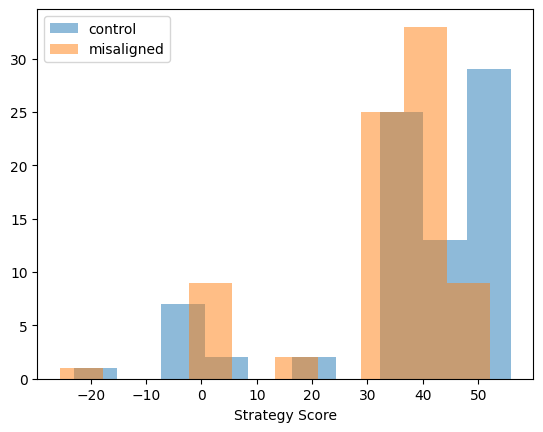

In [28]:
# Histogram of strategy scores
plt.figure()
control_counts, control_bins, _ = plt.hist(strategy_scores_control.values(), alpha=0.5, label='control')
mis_counts, mis_bins, _ = plt.hist(strategy_scores_mis.values(), alpha=0.5, label='misaligned')
plt.legend()
plt.xlabel("Strategy Score")
plt.show()

In [29]:
# Creating the strategy score dataframes

strategy_scores_mis_list = [[k,v] for k,v in strategy_scores_mis.items()]
strategy_scores_control_list = [[k,v] for k,v in strategy_scores_control.items()]

mis_cluster_df = pd.DataFrame(strategy_scores_mis_list, columns=["strategy", "score"])
control_cluster_df = pd.DataFrame(strategy_scores_control_list, columns=["strategy", "score"])

# Scale to 0-1:
mis_cluster_df['scoreScaled'] = (mis_cluster_df['score'] - mis_cluster_df['score'].min()) / (mis_cluster_df['score'].max() - mis_cluster_df['score'].min())
control_cluster_df['scoreScaled'] = (control_cluster_df['score'] - control_cluster_df['score'].min()) / (control_cluster_df['score'].max() - control_cluster_df['score'].min())


In [30]:
# Cluster the strategy scores

init_guesses = [0.6,0.5,0.4]
init_guesses = 3

mis_clusters = scipy.cluster.vq.kmeans(mis_cluster_df['scoreScaled'], k_or_guess=init_guesses)
mis_cluster_centers = sorted(mis_clusters[0], reverse=True)

control_clusters = scipy.cluster.vq.kmeans(control_cluster_df['scoreScaled'], k_or_guess=init_guesses)
control_cluster_centers = sorted(control_clusters[0], reverse=True)

In [31]:
# Compute the cluster labels: 0 - adaptive, 1 - moderately adaptive, 2 - maladaptive

mis_clusters_repeated = np.repeat(np.expand_dims(mis_cluster_centers, axis=0), len(mis_cluster_df), axis=0)
mis_cluster_distances = (mis_clusters_repeated - np.repeat(np.expand_dims(np.array(mis_cluster_df['scoreScaled']), axis=1),repeats=len(mis_cluster_centers), axis=1))**2
mis_cluster_labels = np.argmin(mis_cluster_distances, axis=1)

control_clusters_repeated = np.repeat(np.expand_dims(control_cluster_centers, axis=0), len(control_cluster_df), axis=0)
control_cluster_distances = (control_clusters_repeated - np.repeat(np.expand_dims(np.array(control_cluster_df['scoreScaled']), axis=1),repeats=len(control_cluster_centers), axis=1))**2
control_cluster_labels = np.argmin(control_cluster_distances, axis=1)

In [32]:
# Create dictionary of cluster labels:

mis_cluster_dict = { strat: cluster for (strat, cluster) in zip(mis_cluster_df.strategy, mis_cluster_labels)}

control_cluster_dict = { strat: cluster for (strat, cluster) in zip(control_cluster_df.strategy, control_cluster_labels)}


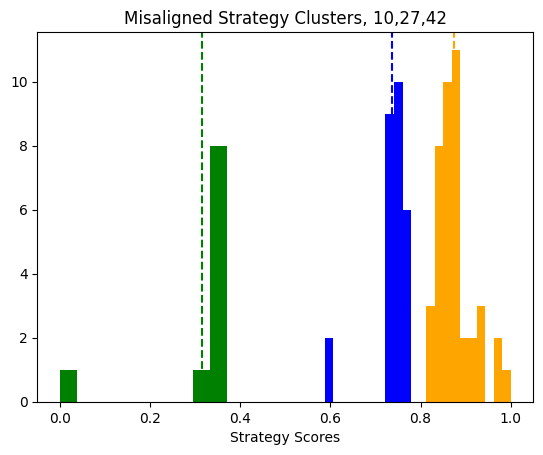

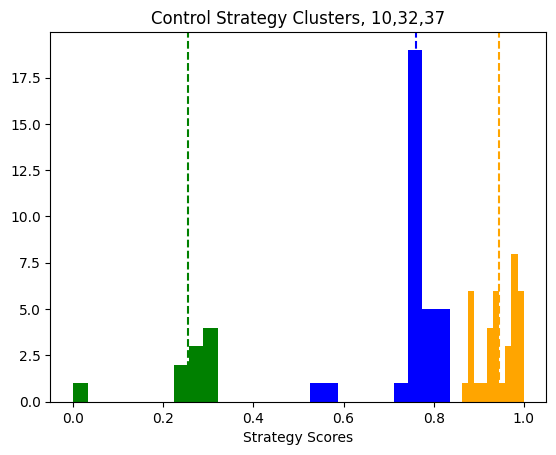

In [33]:
# Plotting the strategy clusters

plt.figure()
cluster_colors = ['orange', 'blue', 'green']
labels = ['adaptive', 'moderate', 'maladaptive']
cluster_sizes = []
for c in [0,1,2]:
    cluster_strats = [k for (k,v) in mis_cluster_dict.items() if v == c]
    cluster_scores = [list(mis_cluster_df.loc[mis_cluster_df.strategy==s]["scoreScaled"])[0] for s in cluster_strats]
    plt.hist(cluster_scores, color=cluster_colors[c], label=labels[c])
    plt.axvline(mis_cluster_centers[c], linestyle="--", color=cluster_colors[c])
    cluster_sizes.append(sum(value == c for value in mis_cluster_dict.values()))
cluster_sizes = [str(s) for s in cluster_sizes]
plt.title("Misaligned Strategy Clusters, {}".format(",".join(cluster_sizes[::-1])))
plt.xlabel("Strategy Scores")

cluster_sizes = []
plt.figure()
for c in [0,1,2]:
    cluster_strats = [k for (k,v) in control_cluster_dict.items() if v == c]
    cluster_scores = [list(control_cluster_df.loc[control_cluster_df.strategy==s]["scoreScaled"])[0] for s in cluster_strats]
    plt.hist(cluster_scores, color=cluster_colors[c], label=labels[c])
    cluster_sizes.append(sum(value == c for value in control_cluster_dict.values()))
    plt.axvline(control_cluster_centers[c], linestyle="--", color=cluster_colors[c])
cluster_sizes = [str(s) for s in cluster_sizes]
plt.title("Control Strategy Clusters, {}".format(",".join(cluster_sizes[::-1])))
plt.xlabel("Strategy Scores")
    
plt.show()

In [34]:
# Add clusters and strategy scores to strategy_df 

strategy_df['cluster'] = [None] * len(strategy_df)
strategy_df['strategyScores'] = [None] * len(strategy_df)

for idx, row in strategy_df.iterrows():
    if row['condition'] == 0:
        strategy_df.at[idx, 'cluster'] = control_cluster_dict[row['strategy']]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_control[row['strategy']]
    else:
        strategy_df.at[idx, 'cluster'] = mis_cluster_dict[row['strategy']]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_mis[row['strategy']]
    
    
strategy_df['strategyScores'] = strategy_df['strategyScores'].astype("float")

In [35]:
# Merging trial data with strategy data

strategy_cols = ["workerId", "trialNumbers", "strategy", "cluster", "strategyScores"]

all_trials_df = pd.merge(all_trials_df, strategy_df[strategy_cols], on=['workerId', "trialNumbers"])


In [36]:
# Scaling by optimal scores
optimal_env_score = {
    0: 55.89,
    1: 52.14
}

In [37]:
all_trials_df["strategyScores_scaled"] = all_trials_df["strategyScores"]
all_trials_df.loc[all_trials_df["condition"] == 0, "strategyScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 0, "strategyScores_scaled"]/optimal_env_score[0]
all_trials_df.loc[all_trials_df["condition"] == 1, "strategyScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 1, "strategyScores_scaled"]/optimal_env_score[1]

In [38]:
all_trials_df["expectedScores_scaled"] = all_trials_df["expectedScores"]
all_trials_df.loc[all_trials_df["condition"] == 0, "expectedScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 0, "expectedScores_scaled"]/optimal_env_score[0]
all_trials_df.loc[all_trials_df["condition"] == 1, "expectedScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 1, "expectedScores_scaled"]/optimal_env_score[1]

In [39]:
# Data to use for the remainder of the analysis

model_save_folder = "../results/model_sim_data/"
control_model = "2.0.3.0.0"
scarce_model = "2.0.3.0.0"
num_simulations = 1
model_file_name = f"c{control_model}_s{scarce_model}_{num_simulations}.csv"

use_model_data = False

if use_model_data:
    filtered_data = pd.read_csv(model_save_folder + model_file_name)
else:
    filtered_data = all_trials_df

In [40]:
filtered_data

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0            12.25           12.25          5       3.000000             1  \
1           -75.90            1.10          6       3.333333             2   
2            15.00            0.00          0       0.000000             3   
3           -72.15           -2.15          5       2.800000             4   
4            42.25            9.25          5       3.000000             5   
...            ...             ...        ...            ...           ...   
20835        52.95           43.95          7       5.000000            36   
20836        21.85           33.85          1       5.000000            37   
20837        50.65           63.65          9       5.000000            38   
20838        85.85           81.85          1       5.000000            39   
20839        92.85           72.85          1       5.000000            40   

       condition   workerId  clicksL1  clicksL2  clicksL3  clicksL4  clicksL5   
0              1  w11930620         1         1         1         1         1  \
1              1  w11930620         1         1         1         1         2   
2              1  w11930620         0         0         0         0         0   
3              1  w11930620         1         1         1         2         0   
4              1  w11930620         1         1         1         1         1   
...          ...        ...       ...       ...       ...       ...       ...   
20835          1  w96211185         0         0         0         0         7   
20836          1  w96211185         0         0         0         0         1   
20837          1  w96211185         0         0         0         0         9   
20838          1  w96211185         0         0         0         0         1   
20839          1  w96211185         0         0         0         0         1   

       clickStratsValid  replication strategy cluster  strategyScores   
0                  True        False       61       1       20.593685  \
1                  True        False       61       1       20.593685   
2                  True        False       61       1       20.593685   
3                  True        False       61       1       20.593685   
4                  True        False       61       1       20.593685   
...                 ...          ...      ...     ...             ...   
20835              True        False       63       0       43.092734   
20836              True        False       21       0       42.452037   
20837              True        False       21       0       42.452037   
20838              True        False       21       0       42.452037   
20839              True        False       21       0       42.452037   

       strategyScores_scaled  expectedScores_scaled  
0                   0.394969               0.234944  
1                   0.394969               0.021097  
2                   0.394969               0.000000  
3                   0.394969              -0.041235  
4                   0.394969               0.177407  
...                      ...                    ...  
20835               0.826481               0.842923  
20836               0.814193               0.649214  
20837               0.814193               1.220752  
20838               0.814193               1.569812  
20839               0.814193               1.397200  

[20840 rows x 19 columns]

# Visualizing Data

## Expected Scores

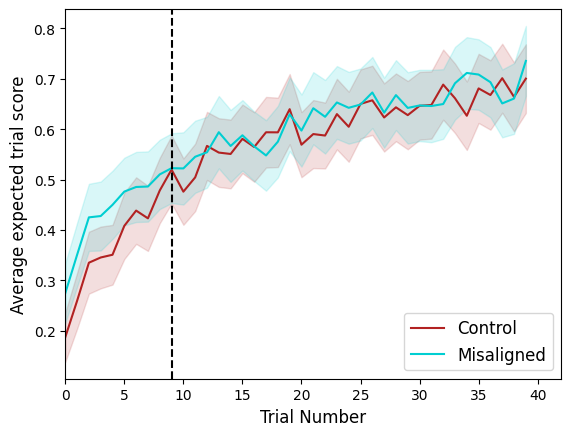

In [13]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "expectedScores"
optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

cond_colors = {"misaligned": "darkturquoise", "control": "firebrick"}
cond_partition = 9

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond[0].upper() + cond[1:], color=cond_colors[cond])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=cond_colors[cond])
    #plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color="black", linestyle="-.")
plt.axvline(cond_partition, linestyle='--', color="black")
#plt.axvline(9, linestyle='--', color='firebrick')


plt.legend(loc="lower right",prop={'size':12})
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number",fontsize=12)
plt.ylabel("Average expected trial score",fontsize=12)
plt.show()



## Actual Scores

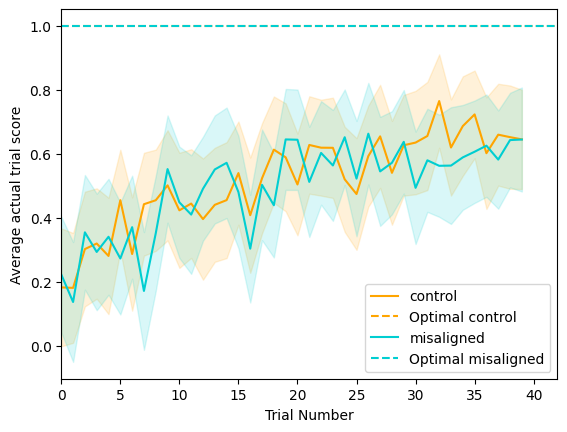

In [548]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = data_to_use_master

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "trialScores"

optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
#plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average actual trial score")
plt.show()



## Clicks

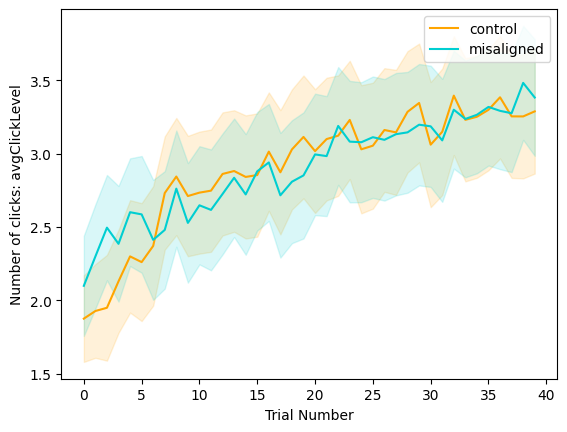

In [549]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master

# Filter out participants whose click strategies are not valid
data_to_copy = data_to_copy.loc[data_to_copy.clickStratsValid]

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "avgClickLevel"
optimal_env_score = 5

num_parts = {}
performance_data = {}
full_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]),
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / np.sqrt(nump)
    }
    full_data[cond] = data_to_copy.loc[data_to_copy.condition == idx]

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    
    #plt.hist(full_data[cond][performance_metric],label=cond, color=color_list[idx], alpha=0.5)
    #plt.scatter(full_data[cond]["trialNumbers"], full_data[cond][performance_metric], label=cond, color=color_list[idx])
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
#plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend()
#plt.ylim([10,60])
#plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Number of clicks: " + performance_metric)
plt.show()



## Strategy Scores

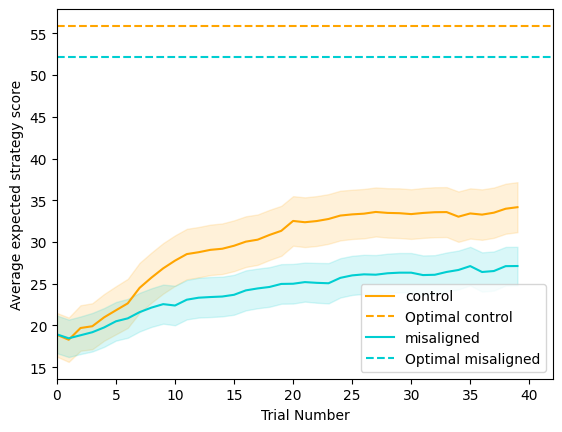

In [42]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master
    
conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "strategyScores"
optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}
# optimal_env_score = {
#     "control": 31.78,
#     "misaligned": 25.29
# }

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")
#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')


plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average expected strategy score")
plt.show()



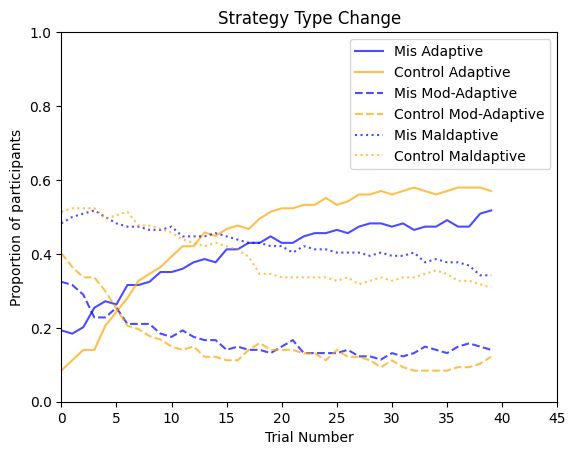

In [551]:
# Plotting Strategy cluster change

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master

scarce_trial_group = data_to_copy.loc[data_to_copy.condition == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.condition == 0].groupby('trialNumbers')

# Taking the mean strategy score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean(numeric_only=True)["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std(numeric_only=True)["strategyScores"])
control_data = np.array(control_trial_group.mean(numeric_only=True)["strategyScores"])
control_data_sd = np.array(control_trial_group.std(numeric_only=True)["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Mis Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Mis Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Mis Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 45])
plt.xlabel("Trial Number")
plt.ylabel("Proportion of participants")
plt.show()


# 0.1 - Transforming Response Data

In [552]:
def scale_to_range(arr, lb, ub):
    return ((arr - arr.min()) / (arr.max() - arr.min())) * (ub - lb) + lb

In [553]:
# Selecting the response variable

response_vars = ["expectedScores", 'expectedScores_scaled', 'avgClickLevel', "clicksL1", "clicksL5", "strategyScores", 'strategyScores_scaled']

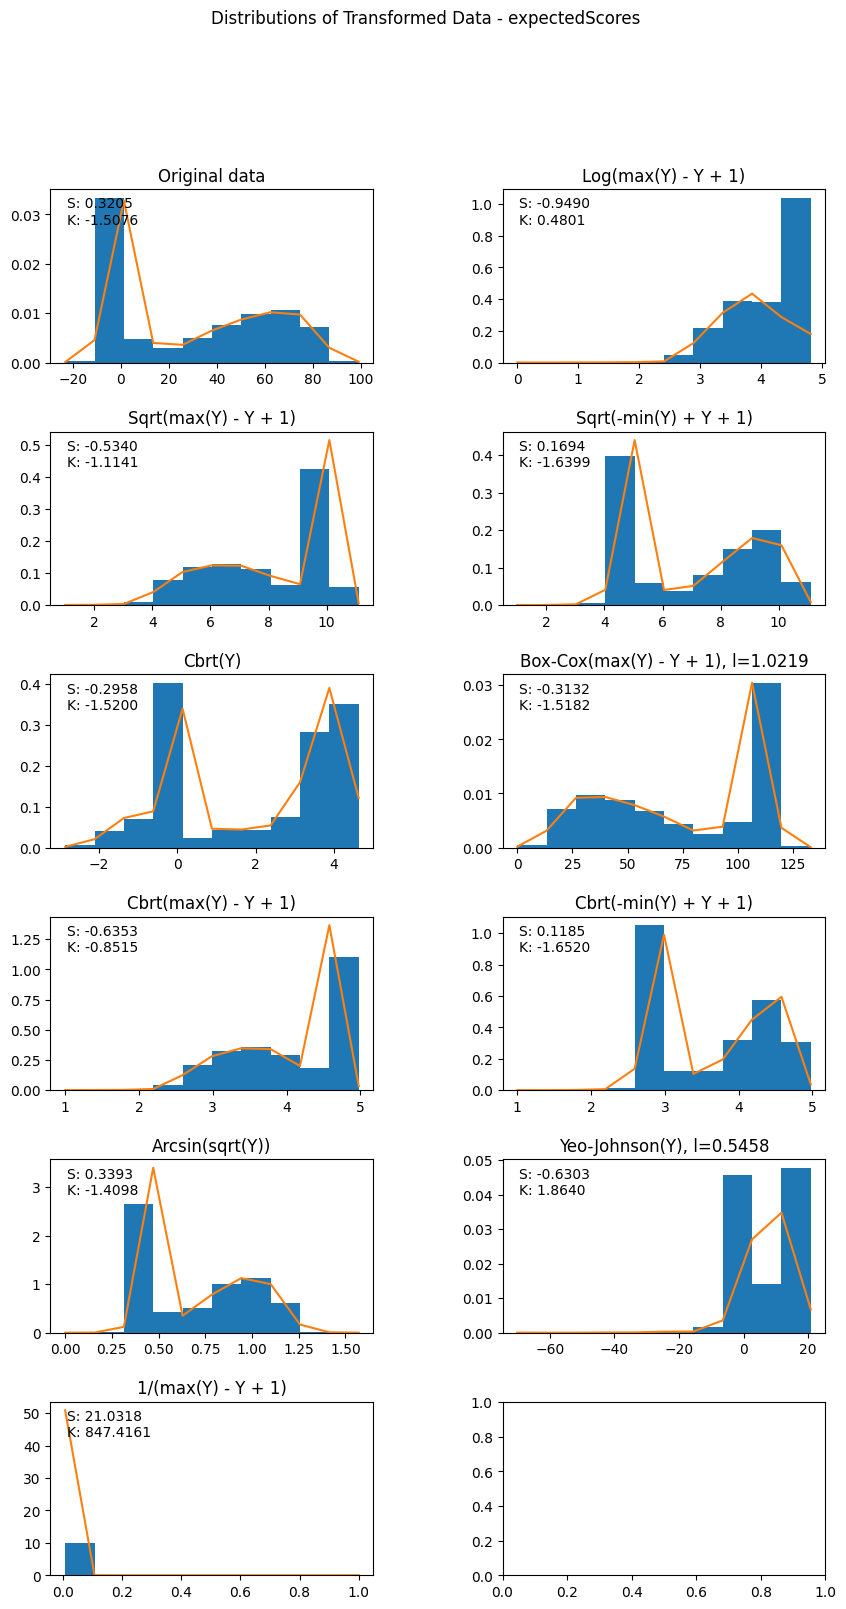

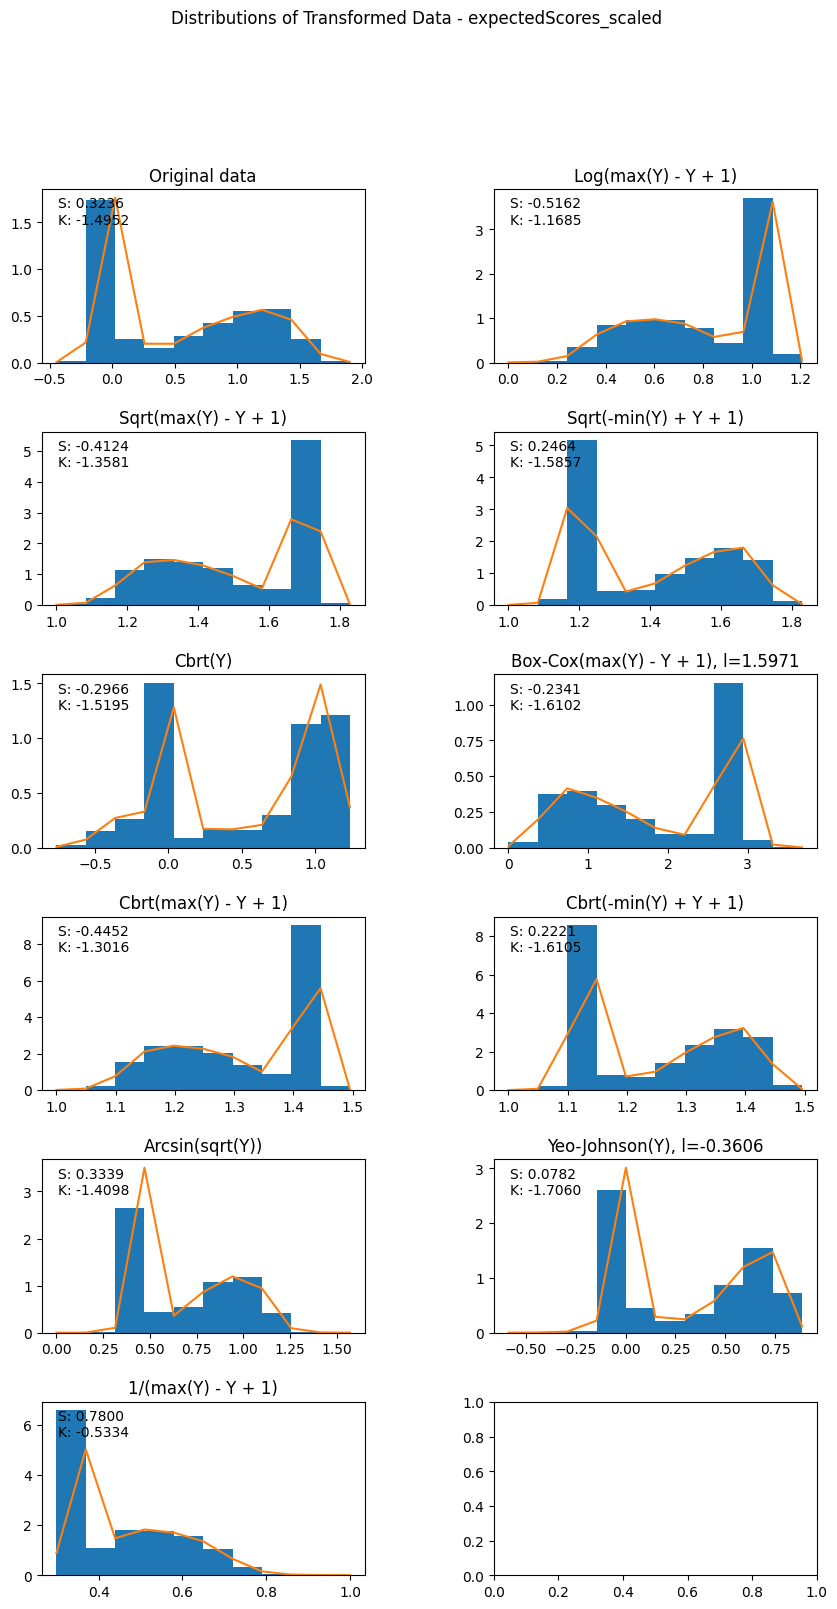

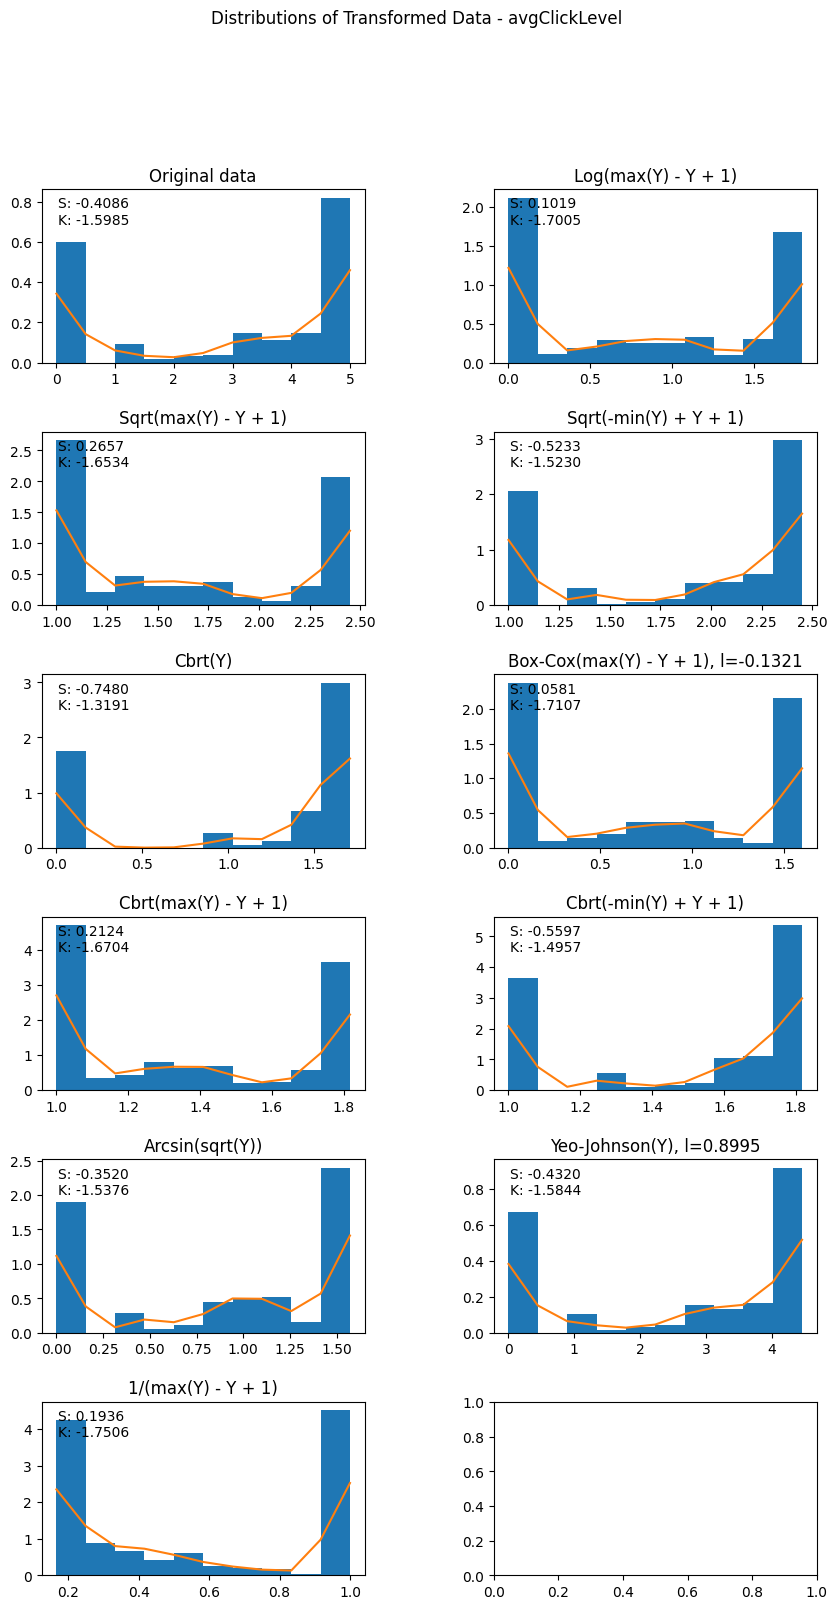

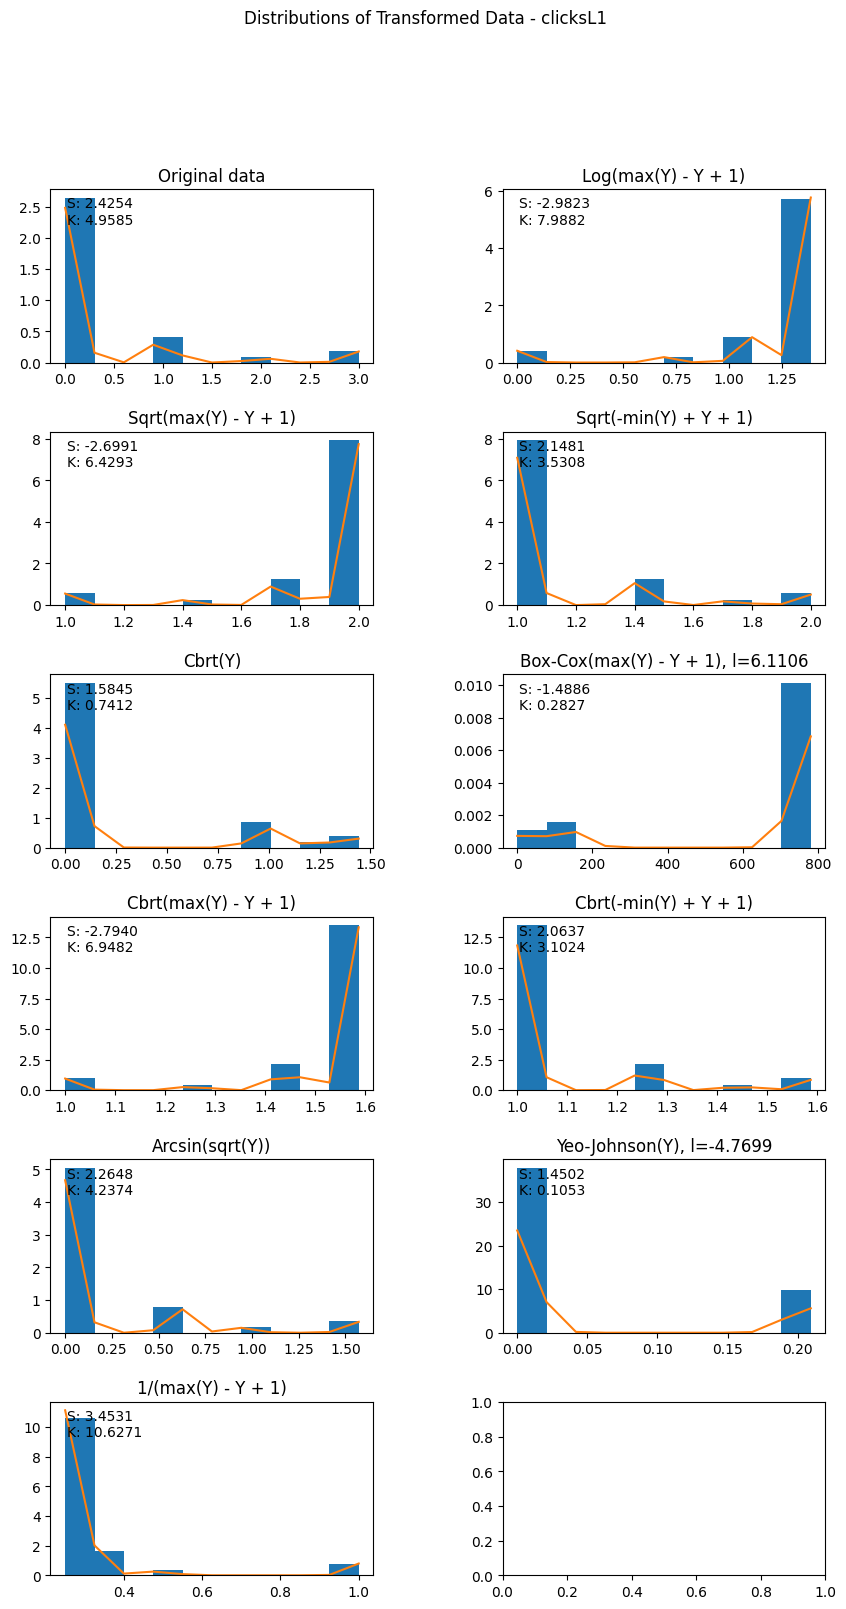

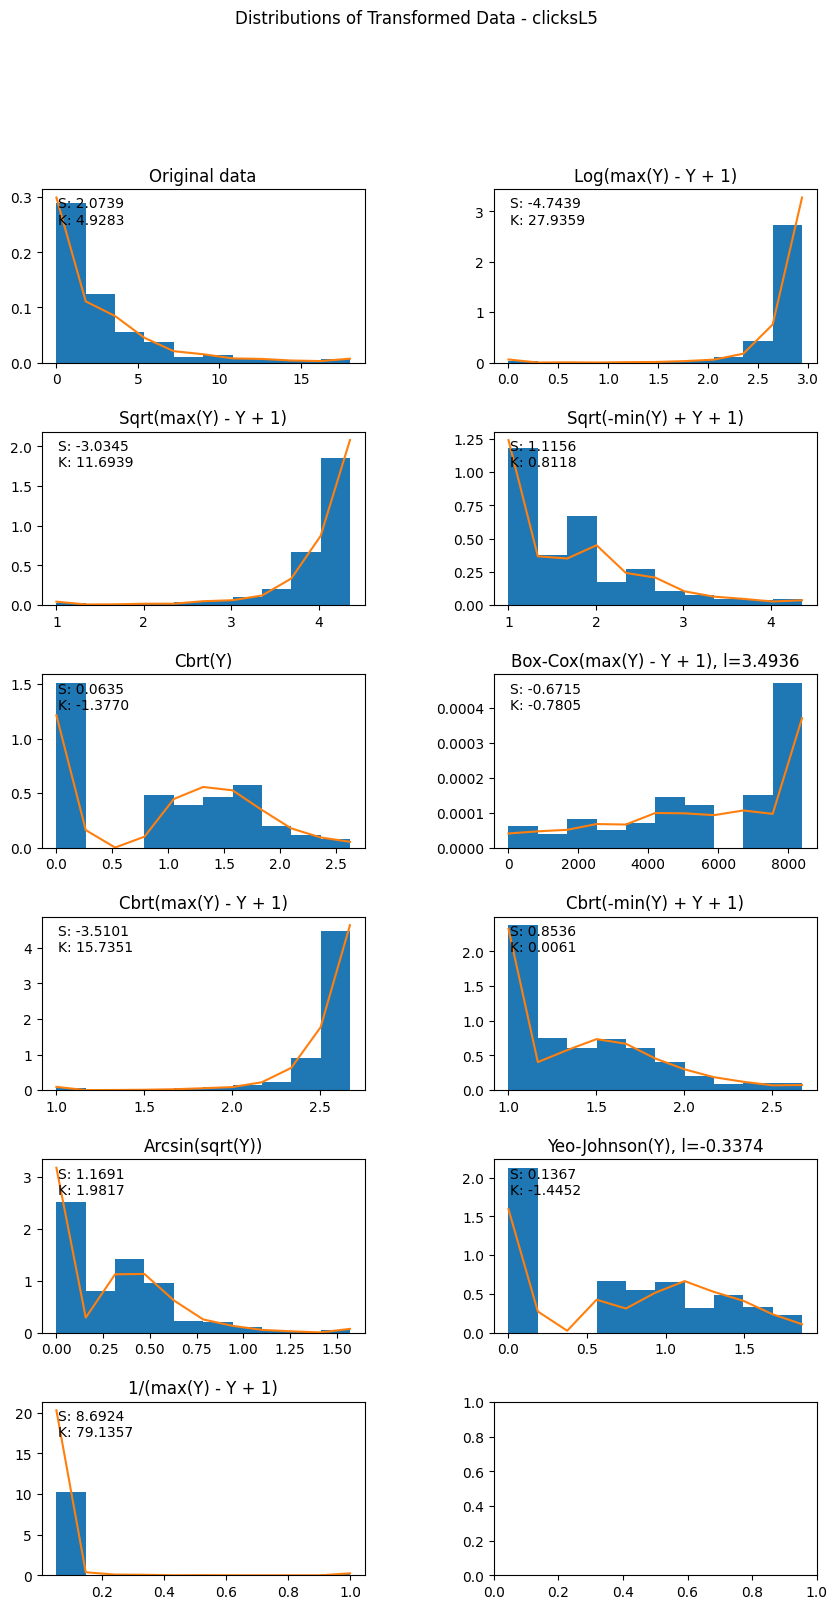

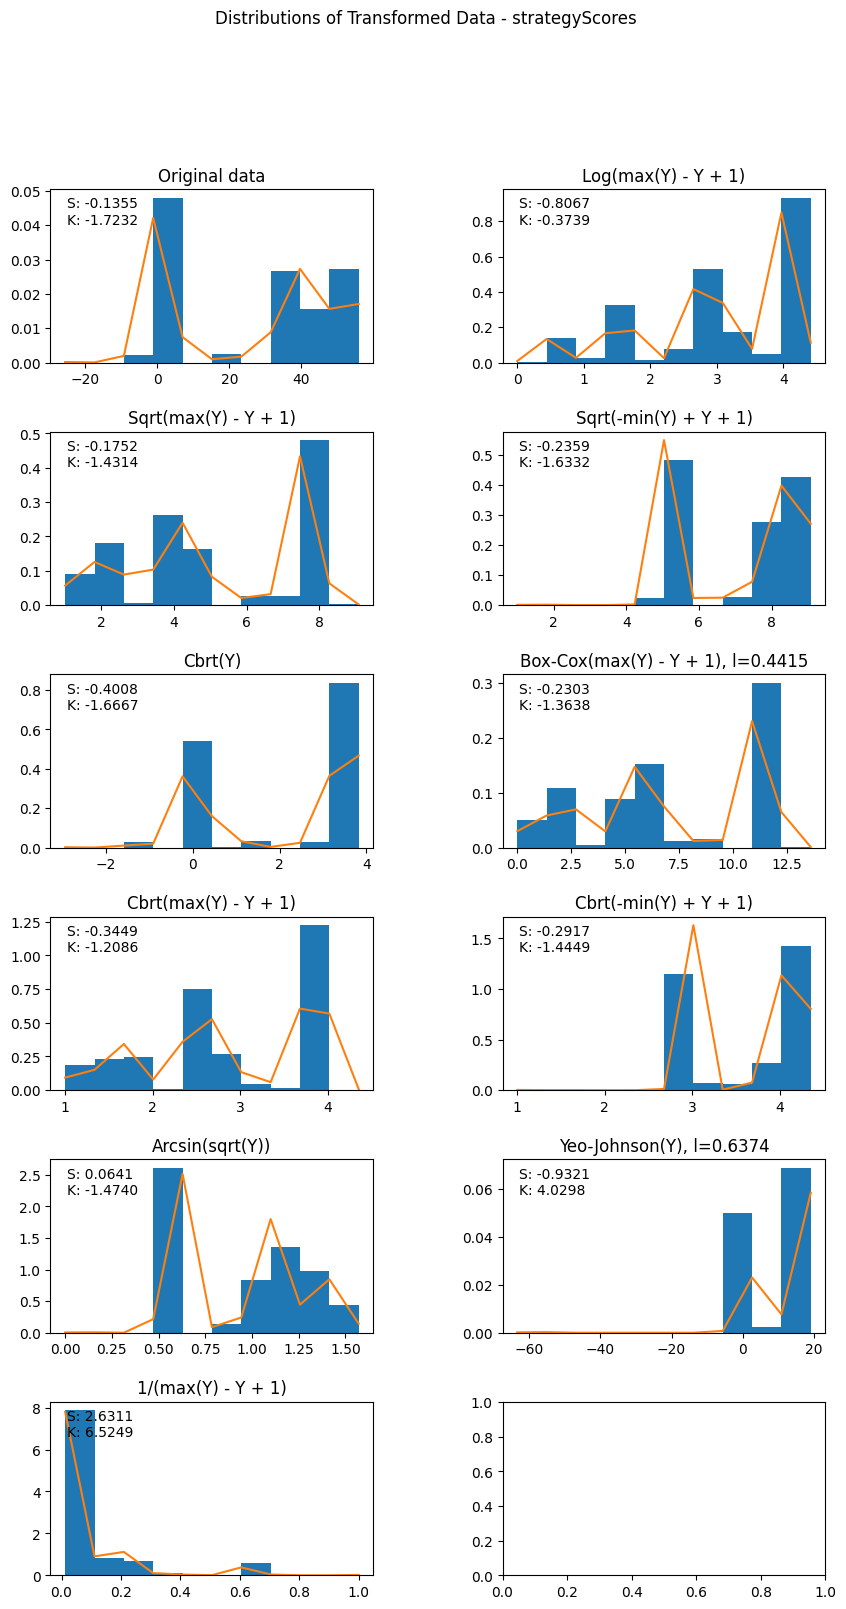

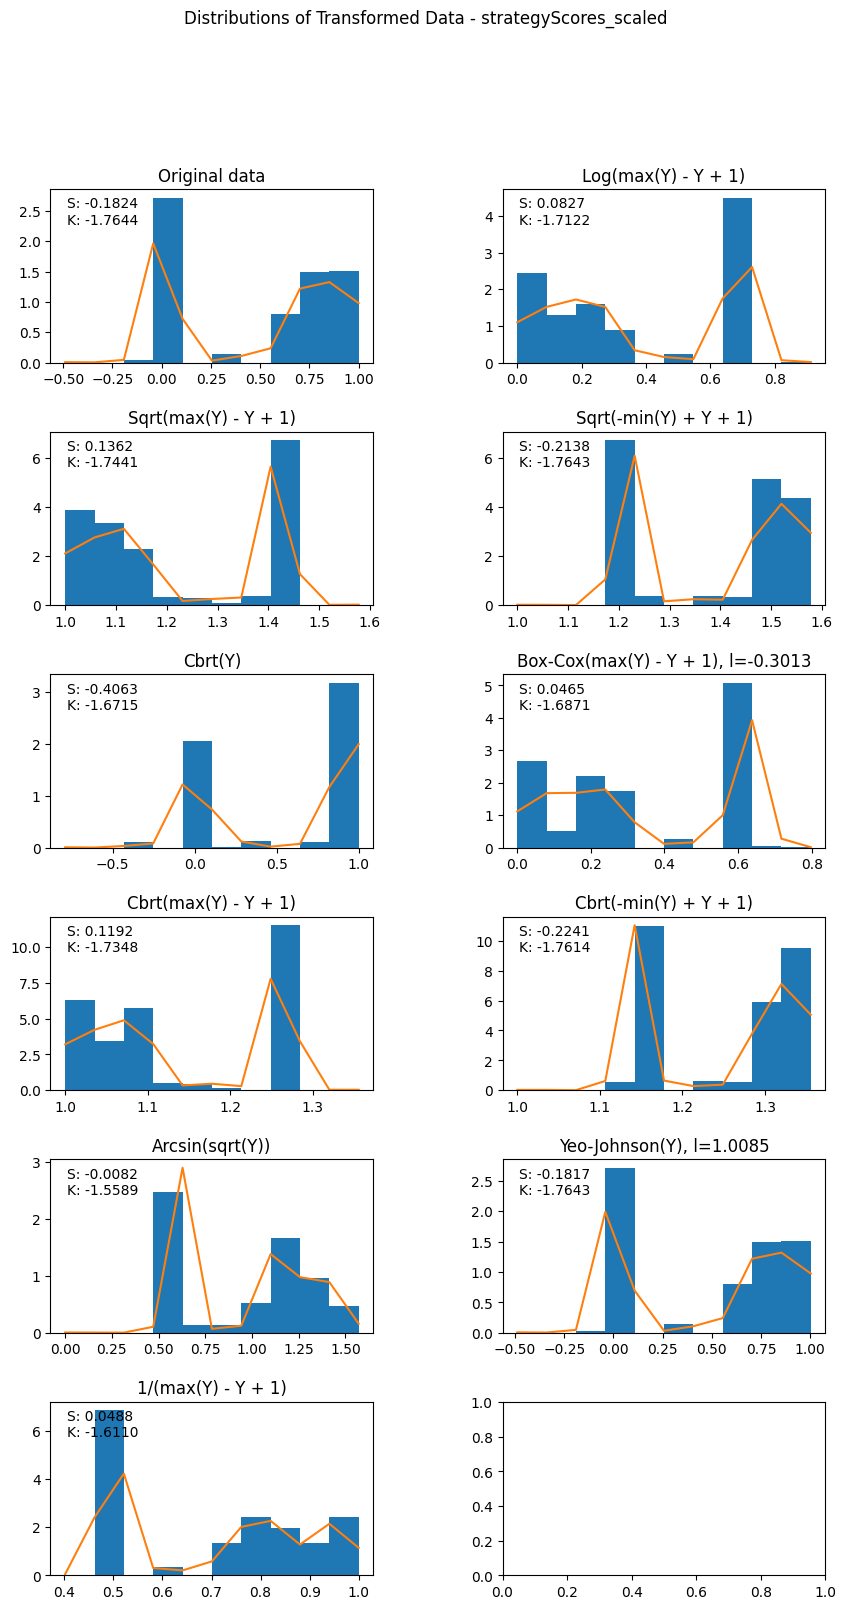

In [554]:
# Transforming the data

data_to_copy = filtered_data.copy() # or outliers_excluded

# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master
    
transformed_trials_df = data_to_copy.copy()
trans_list = {res: [] for res in response_vars}

for response_var in response_vars:
    

    log_transformed_trials_df = data_to_copy.copy()
    sq_transformed_trials_df = data_to_copy.copy()
    sq2_transformed_trials_df = data_to_copy.copy()
    cb_transformed_trials_df = data_to_copy.copy()
    cb2_transformed_trials_df = data_to_copy.copy()
    cb3_transformed_trials_df = data_to_copy.copy()
    arcsin_transformed_trials_df = data_to_copy.copy()
    bc_transformed_trials_df = data_to_copy.copy()
    yj_transformed_trials_df = data_to_copy.copy()
    inverse_transformed_trials_df = data_to_copy.copy()

    # Compute separate dataframes for each transformation
    log_transformed_trials_df[response_var] = np.log(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq_transformed_trials_df[response_var] = np.sqrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq2_transformed_trials_df[response_var] = np.sqrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    cb_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var])
    cb2_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    cb3_transformed_trials_df[response_var] = np.cbrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    arcsin_transformed_trials_df[response_var] = np.arcsin(np.sqrt(scale_to_range(transformed_trials_df[response_var], 0, 1)))
    bc_transformed_trials_df[response_var],lam = scipy.stats.boxcox(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    #logit_transformed_trials_df[response_var] = scipy.special.logit(scale_to_range(transformed_trials_df[response_var], 0, 1))
    yj_transformed_trials_df[response_var],lam_y = scipy.stats.yeojohnson(transformed_trials_df[response_var])
    inverse_transformed_trials_df[response_var] = 1/(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])

    # All the transformed data and the corresponding transformation
    trans_list[response_var] = [
        (transformed_trials_df, "Original data"),
        (log_transformed_trials_df, "Log(max(Y) - Y + 1)"),
        (sq_transformed_trials_df, "Sqrt(max(Y) - Y + 1)"),
        (sq2_transformed_trials_df, "Sqrt(-min(Y) + Y + 1)"),
        (cb_transformed_trials_df, "Cbrt(Y)"),
        (bc_transformed_trials_df, "Box-Cox(max(Y) - Y + 1), l={0:0.4f}".format(lam)),
        (cb2_transformed_trials_df, "Cbrt(max(Y) - Y + 1)"),
        (cb3_transformed_trials_df, "Cbrt(-min(Y) + Y + 1)"),
        (arcsin_transformed_trials_df, "Arcsin(sqrt(Y))"),
        (yj_transformed_trials_df, "Yeo-Johnson(Y), l={0:0.4f}".format(lam_y)),
        (inverse_transformed_trials_df, "1/(max(Y) - Y + 1)")
    ]
    
    # Plot all the transformed data
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Distributions of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0][response_var]
        label = trans[1]
        skew = scipy.stats.skew(data)
        density = scipy.stats.gaussian_kde(data)
        kurtosis = scipy.stats.kurtosis(data)
        n, x, _ = ax[idx].hist(data, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nK: {1:0.4f}".format(skew, kurtosis), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

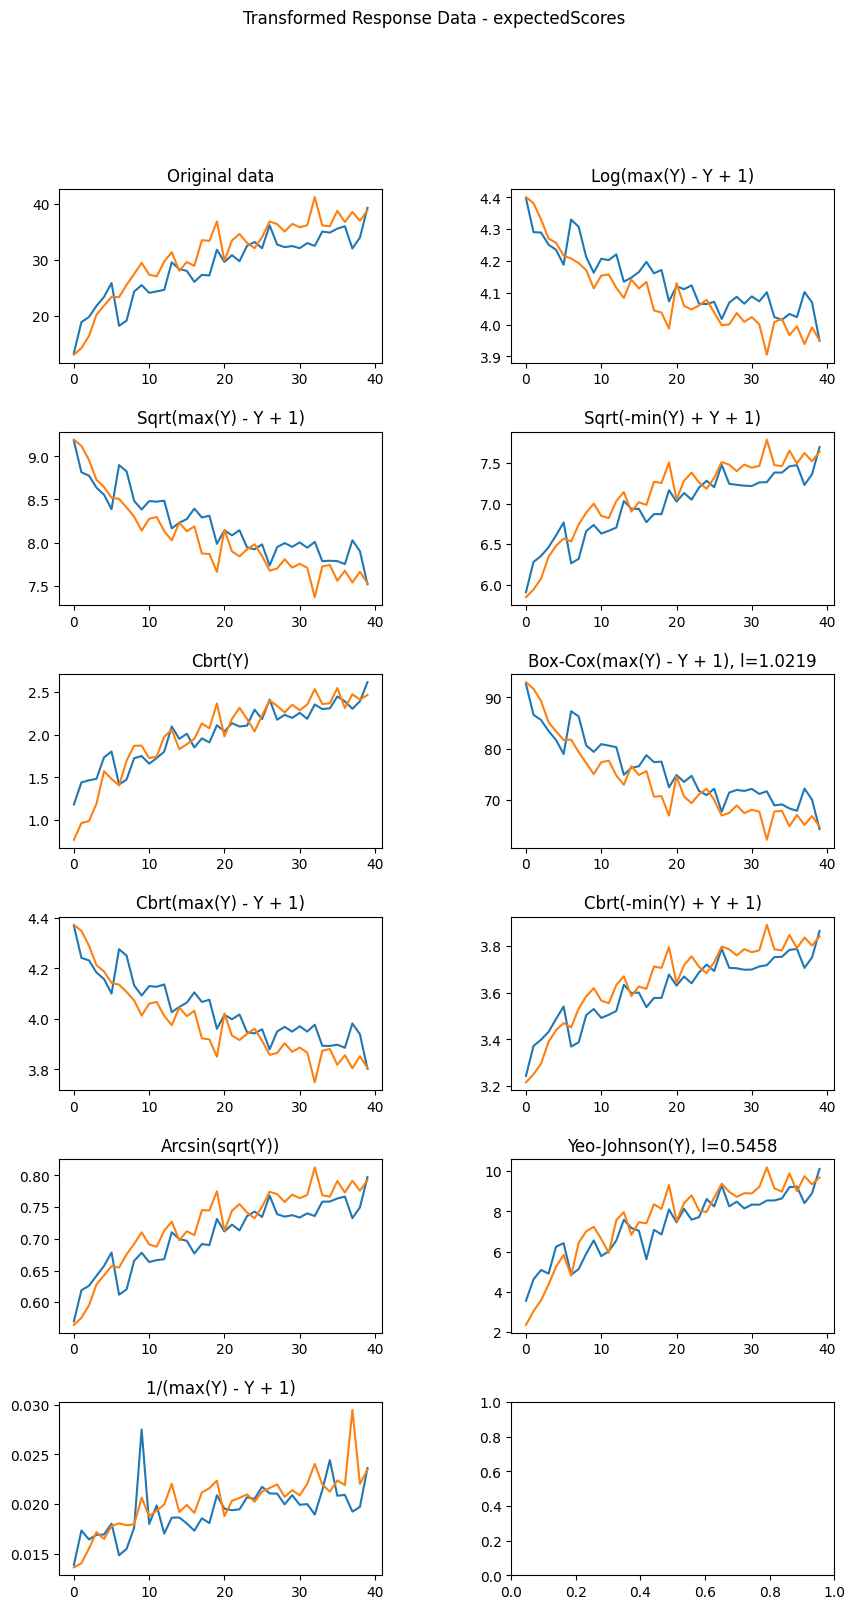

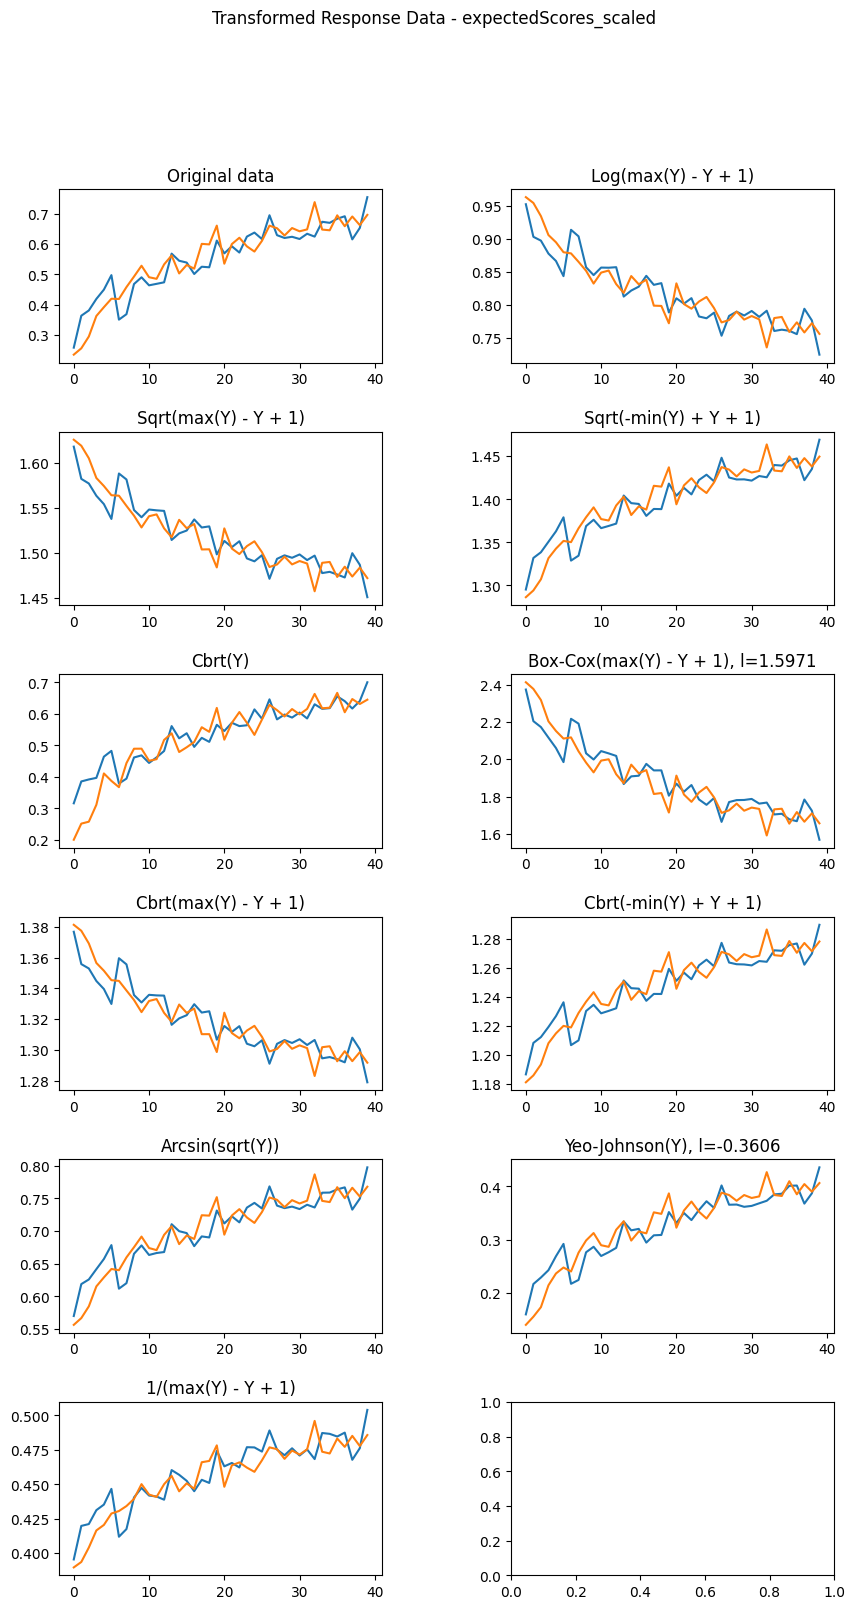

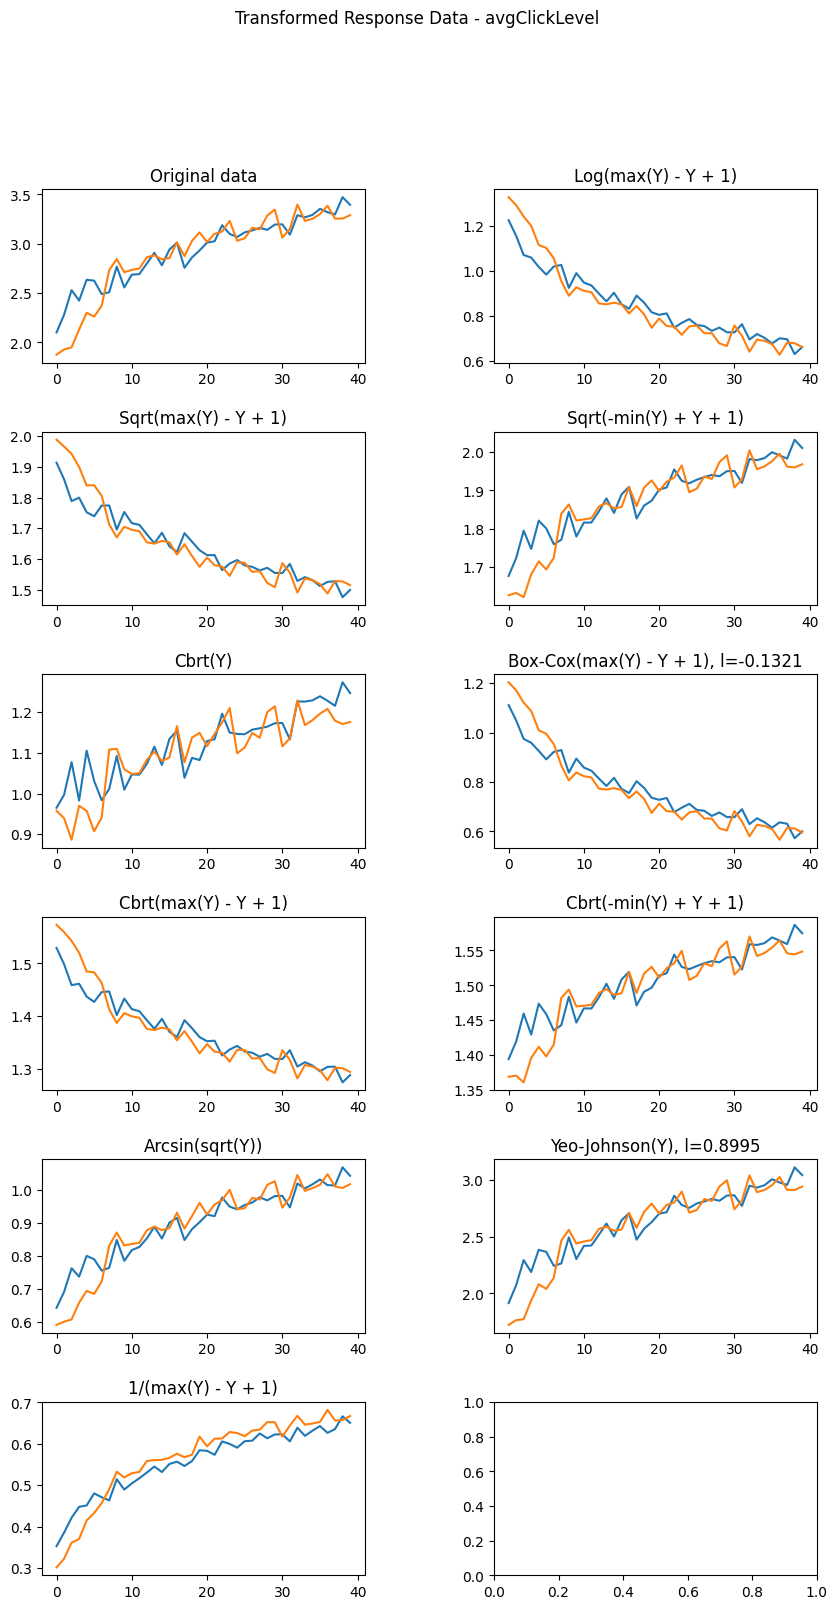

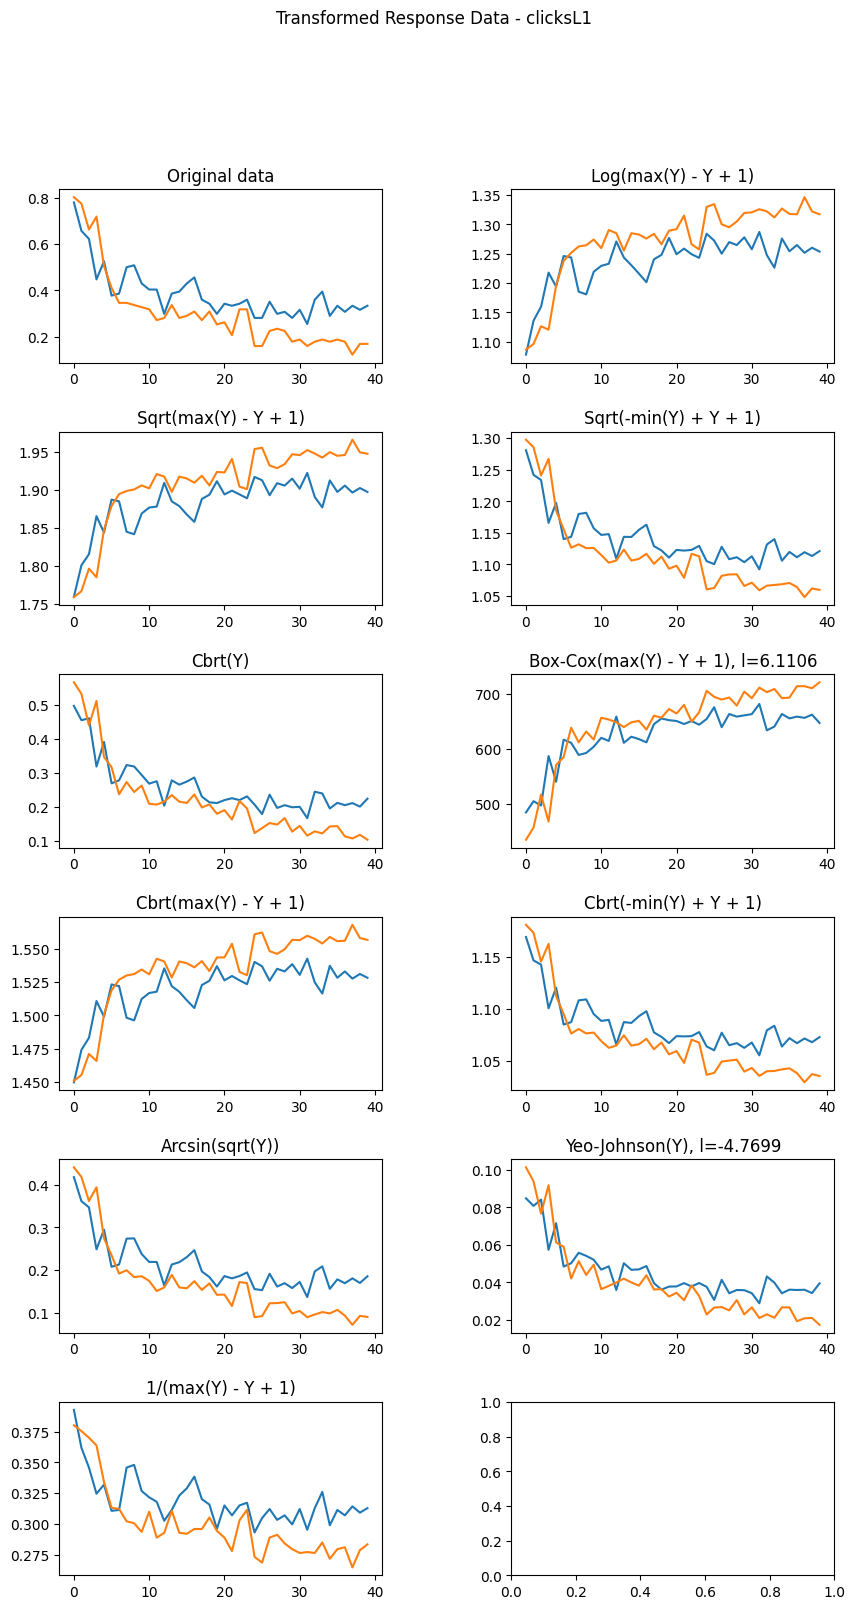

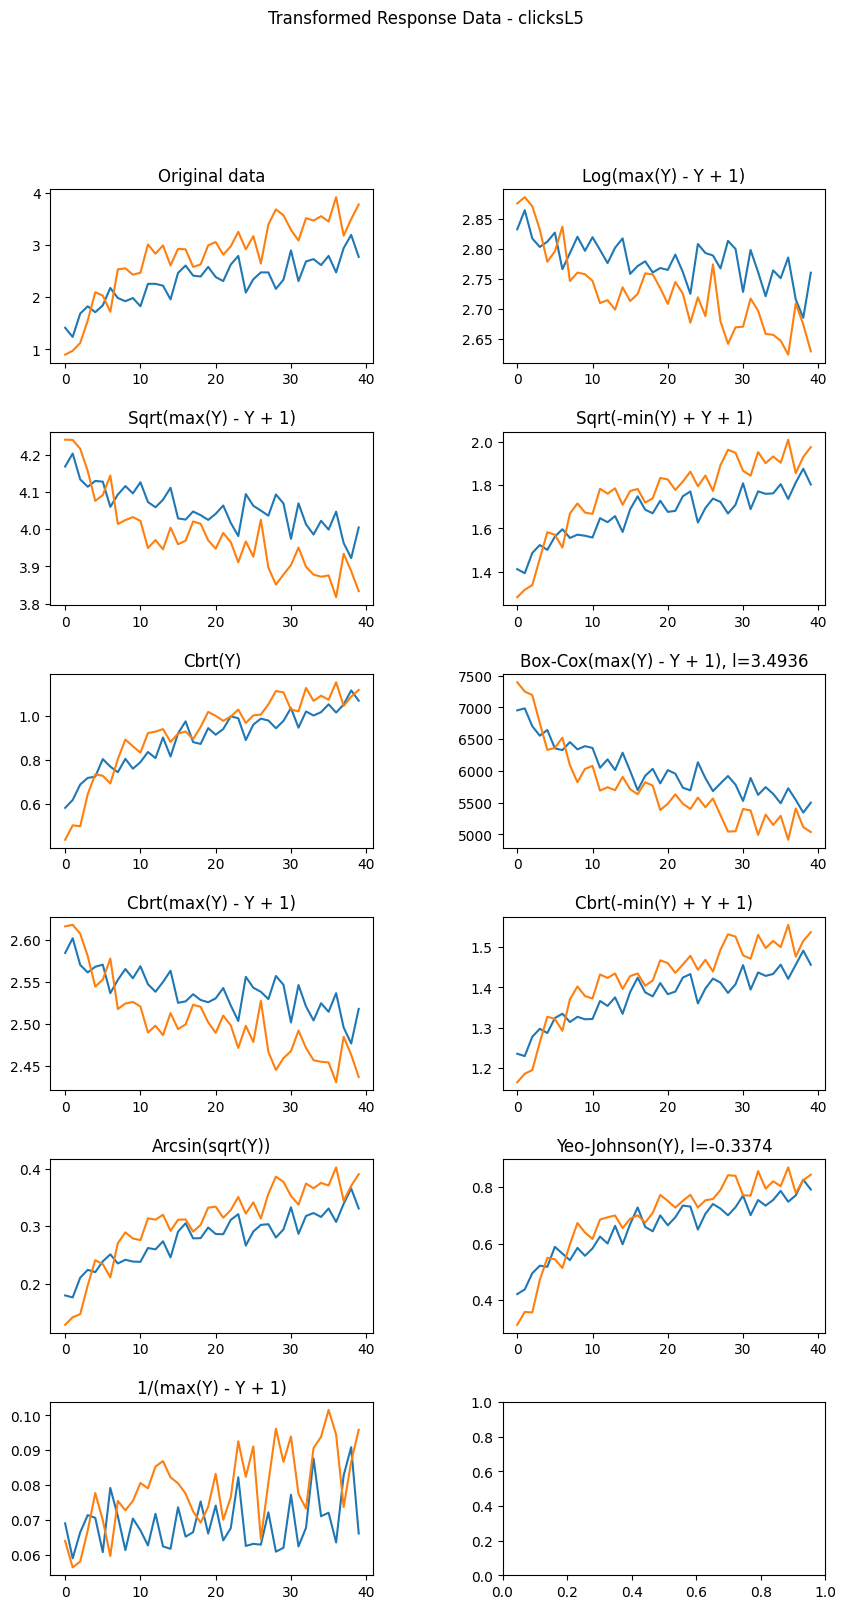

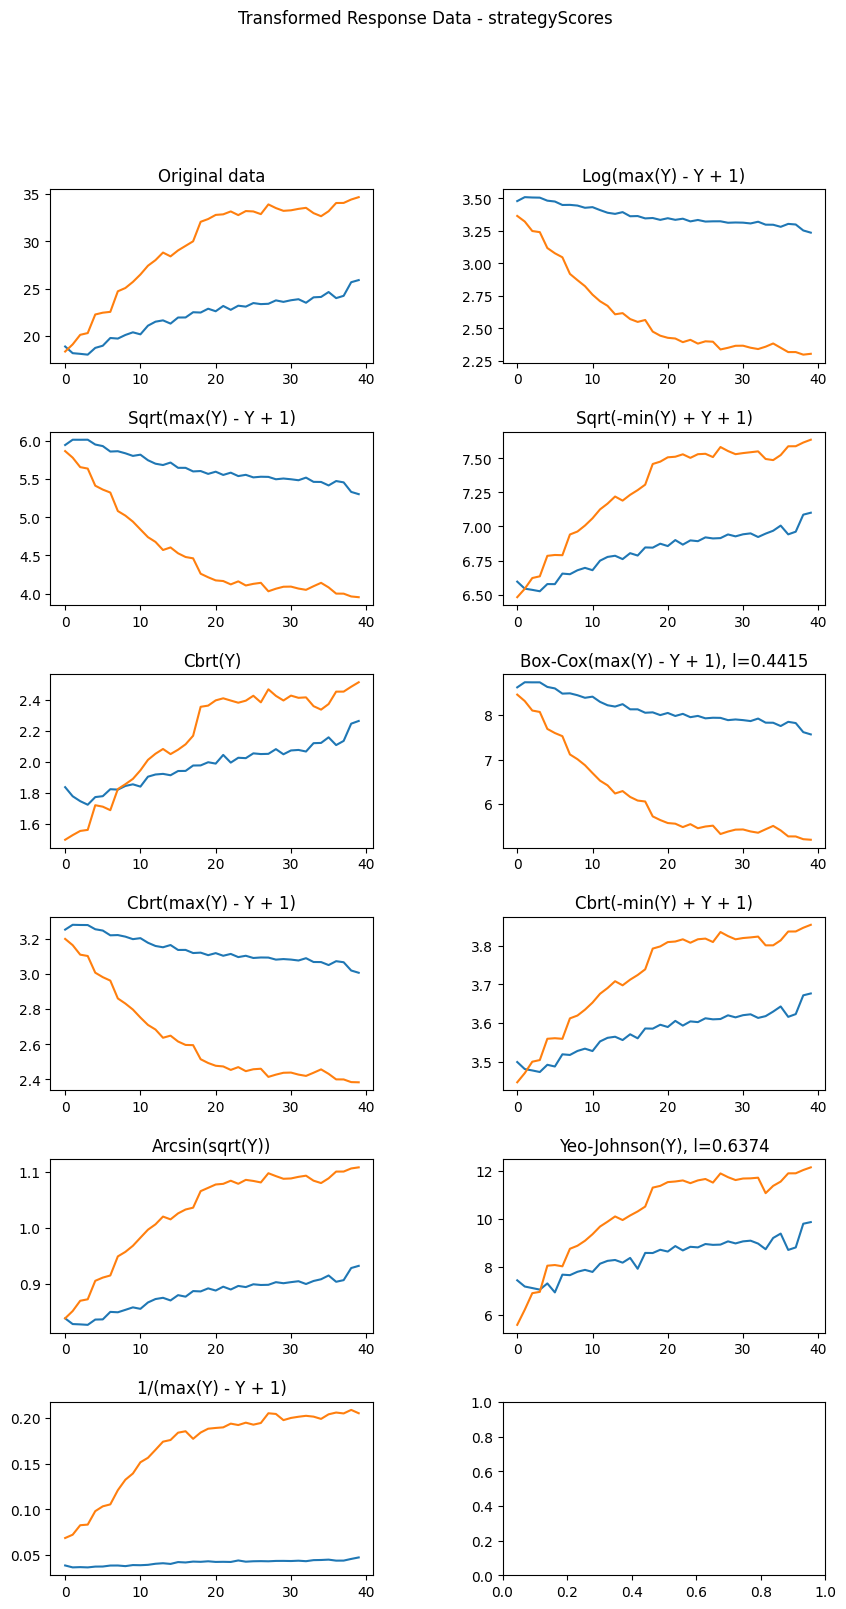

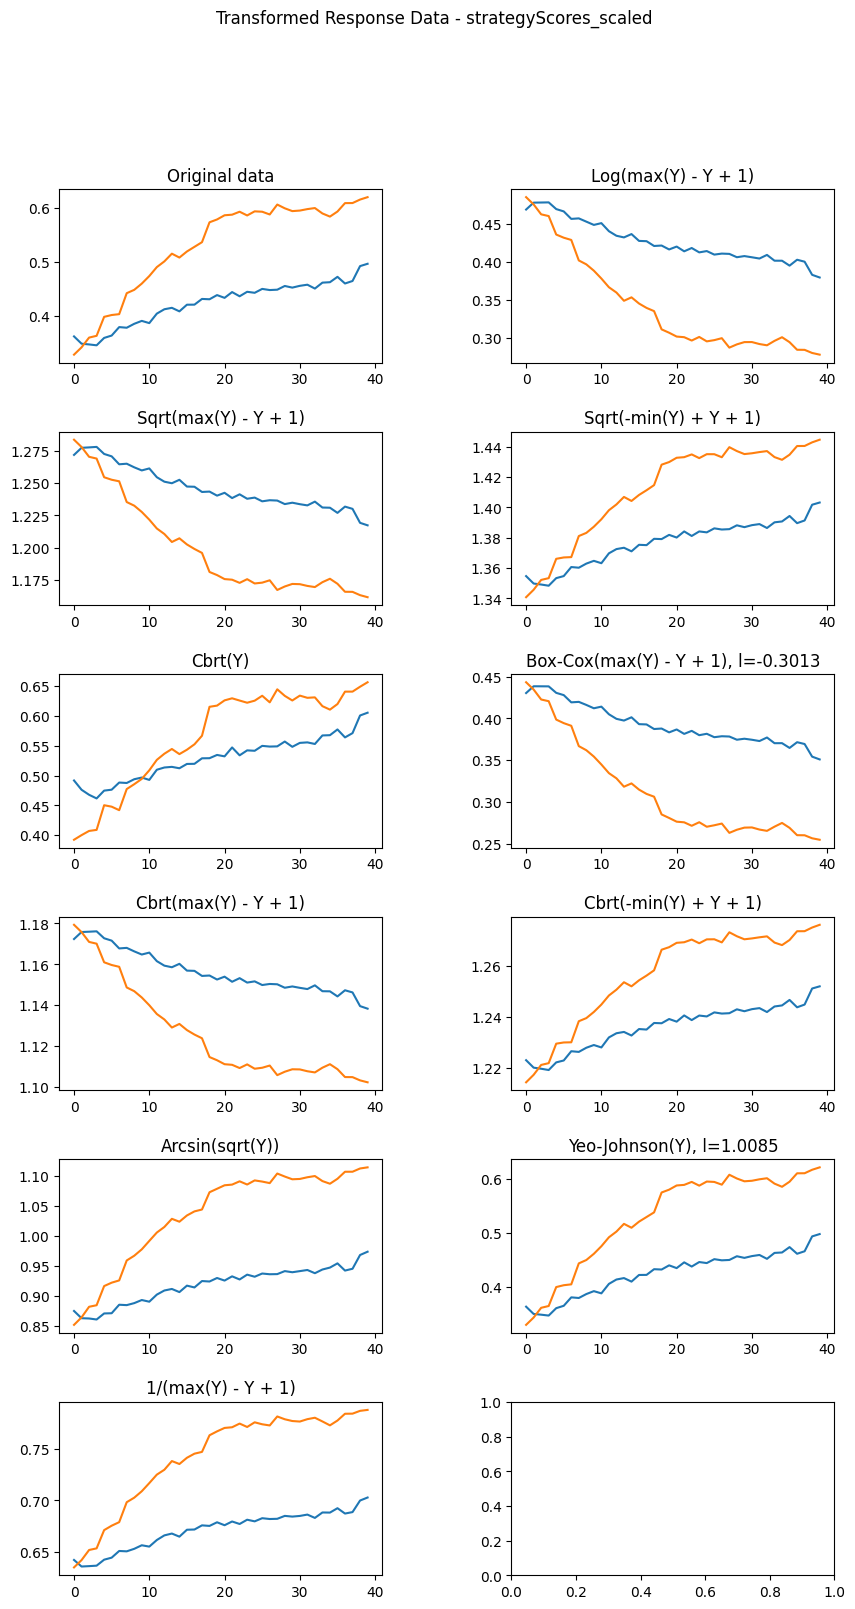

In [555]:
# Plotting the response data

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Transformed Response Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0]
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = trans[1]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Exp")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Linear Regression: Expected Score vs. Trial Number x Condition

In [556]:
# formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

In [557]:
# GLM Model 1 - Expected score vs. Trial number & Condition - all possible transformations

# Creating the list of data to subplot all residuals

all_residuals = {res: [] for res in response_vars}
mixed = True

for response_var in response_vars:
    formula = '{} ~ C(trialNumbers) + C(condition)'.format(response_var);

    # Perform regression on each transformed dataset
    for idx, trans in enumerate(trans_list[response_var]):
        if mixed:
            glm = smf.mixedlm(formula=formula, data=trans[0], groups=trans[0]['workerId'])
        else:
            glm = smf.glm(formula=formula, data=trans[0])

        results = glm.fit()

        print("\n{} - {}:".format(response_var, trans[1]))
        print(results.summary())

        resids = results.resid_response if not mixed else results.resid
        normaltest = scipy.stats.normaltest(resids)
        
        # Save the results of the regression for plotting
        all_residuals[response_var].append((
            resids,
            trans[0][response_var],
            trans[1],
            normaltest
        ))



expectedScores - Original data:
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    8840     Method:              REML          
No. Groups:          221      Scale:               450.0473      
Min. group size:     40       Log-Likelihood:      -39888.1500   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              14.470    2.560  5.652 0.000  9.452 19.488
C(trialNumbers)[T.2]    3.399    2.018  1.684 0.092 -0.557  7.354
C(trialNumbers)[T.3]    4.921    2.018  2.438 0.015  0.965  8.876
C(trialNumbers)[T.4]    7.777    2.018  3.854 0.000  3.822 11.733
C(trialNumbers)[T.5]    9.385    2.018  4.650 0.000  5.43


expectedScores - Sqrt(-min(Y) + Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   8840     Method:              REML          
No. Groups:         221      Scale:               2.0391        
Min. group size:    40       Log-Likelihood:      -16155.0337   
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              5.947    0.178 33.387 0.000  5.598  6.297
C(trialNumbers)[T.2]   0.238    0.136  1.751 0.080 -0.028  0.504
C(trialNumbers)[T.3]   0.341    0.136  2.509 0.012  0.075  0.607
C(trialNumbers)[T.4]   0.527    0.136  3.880 0.000  0.261  0.793
C(trialNumbers)[T.5]   0.668    0.136  4.920 0.000  0.402  0.93


expectedScores - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  expectedScores
No. Observations:    8840     Method:              REML          
No. Groups:          221      Scale:               0.2546        
Min. group size:     40       Log-Likelihood:      -6966.2978    
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              4.342    0.057  76.796 0.000  4.231  4.452
C(trialNumbers)[T.2]  -0.077    0.048  -1.609 0.108 -0.171  0.017
C(trialNumbers)[T.3]  -0.111    0.048  -2.303 0.021 -0.205 -0.016
C(trialNumbers)[T.4]  -0.173    0.048  -3.599 0.000 -0.267 -0.079
C(trialNumbers)[T.5]  -0.198    0.048  -4.128 0.00


expectedScores - Yeo-Johnson(Y), l=0.5458:
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   8840     Method:              REML          
No. Groups:         221      Scale:               36.3029       
Min. group size:    40       Log-Likelihood:      -28794.2460   
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              3.146    0.687  4.580 0.000  1.800  4.492
C(trialNumbers)[T.2]   0.881    0.573  1.537 0.124 -0.242  2.005
C(trialNumbers)[T.3]   1.381    0.573  2.409 0.016  0.257  2.504
C(trialNumbers)[T.4]   1.672    0.573  2.917 0.004  0.548  2.795
C(trialNumbers)[T.5]   2.792    0.573  4.871 0.000  1.669  3

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   8840     Method:              REML          
No. Groups:         221      Scale:               0.0004        
Min. group size:    40       Log-Likelihood:      22117.9209    
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.014    0.001  9.652 0.000  0.011  0.017
C(trialNumbers)[T.2]   0.002    0.002  1.110 0.267 -0.002  0.006
C(trialNumbers)[T.3]   0.002    0.002  1.248 0.212 -0.001  0.006
C(trialNumbers)[T.4]   0.003    0.002  1.826 0.068 -0.000  0.007
C(trialNumbers)[T.5]   0.003    0.002  1.650 0.099 -0.001  0.006
C


expectedScores_scaled - Sqrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 8840    Method:             REML                 
No. Groups:       221     Scale:              0.0184               
Min. group size:  40      Log-Likelihood:     4576.5555            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.622    0.016 101.909 0.000  1.591  1.653
C(trialNumbers)[T.2]    -0.022    0.013  -1.685 0.092 -0.047  0.004
C(trialNumbers)[T.3]    -0.031    0.013  -2.411 0.016 -0.056 -0.006
C(trialNumbers)[T.4]    -0.049    0.013  -3.781 0.000 -0.074 -0.024
C(trialNumbers)[


expectedScores_scaled - Box-Cox(max(Y) - Y + 1), l=1.5971:
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 8840    Method:             REML                 
No. Groups:       221     Scale:              0.3950               
Min. group size:  40      Log-Likelihood:     -8929.6945           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                2.387    0.077  30.901 0.000  2.235  2.538
C(trialNumbers)[T.2]    -0.105    0.060  -1.749 0.080 -0.222  0.013
C(trialNumbers)[T.3]    -0.150    0.060  -2.501 0.012 -0.267 -0.032
C(trialNumbers)[T.4]    -0.234    0.060  -3.912 0.000 -0.351 -0.117
C(t

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - Cbrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 8840    Method:             REML                 
No. Groups:       221     Scale:              0.0064               
Min. group size:  40      Log-Likelihood:     9222.0904            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.379    0.009 148.097 0.000  1.361  1.397
C(trialNumbers)[T.2]    -0.013    0.008  -1.675 0.094 -0.028  0.002
C(trialNumbers)[T.3]    -0.018    0.008  -2.393 0.017 -0.033 -0.003
C(trialNumbers)[T.4]    -0.029    0.008  -3.754 0.000 -0.043 -0.014
C(trialNumbers)[

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - Cbrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 8840    Method:             REML                 
No. Groups:       221     Scale:              0.0065               
Min. group size:  40      Log-Likelihood:     9134.9631            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.184    0.010 119.202 0.000  1.165  1.204
C(trialNumbers)[T.2]     0.013    0.008   1.759 0.079 -0.002  0.029
C(trialNumbers)[T.3]     0.019    0.008   2.506 0.012  0.004  0.034
C(trialNumbers)[T.4]     0.030    0.008   3.899 0.000  0.015  0.045
C(trialNumbers)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - 1/(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 8840    Method:             REML                 
No. Groups:       221     Scale:              0.0091               
Min. group size:  40      Log-Likelihood:     7694.6208            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.391    0.010 38.051 0.000  0.371  0.411
C(trialNumbers)[T.2]      0.014    0.009  1.592 0.111 -0.003  0.032
C(trialNumbers)[T.3]      0.020    0.009  2.227 0.026  0.002  0.038
C(trialNumbers)[T.4]      0.031    0.009  3.461 0.001  0.014  0.049
C(trialNumbers)[T.


avgClickLevel - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   8840      Method:               REML         
No. Groups:         221       Scale:                0.1183       
Min. group size:    40        Log-Likelihood:       -3696.0156   
Max. group size:    40        Converged:            Yes          
Mean group size:    40.0                                         
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.952    0.054  35.977 0.000  1.845  2.058
C(trialNumbers)[T.2]  -0.039    0.033  -1.182 0.237 -0.103  0.025
C(trialNumbers)[T.3]  -0.087    0.033  -2.657 0.008 -0.151 -0.023
C(trialNumbers)[T.4]  -0.102    0.033  -3.115 0.002 -0.166 -0.038
C(trialNumbers)[T.5]  -0.156    0.033  -4.756 0.000


avgClickLevel - Box-Cox(max(Y) - Y + 1), l=-0.1321:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   avgClickLevel
No. Observations:   8840      Method:               REML         
No. Groups:         221       Scale:                0.1466       
Min. group size:    40        Log-Likelihood:       -4636.1452   
Max. group size:    40        Converged:            Yes          
Mean group size:    40.0                                         
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.153    0.060  19.374 0.000  1.036  1.269
C(trialNumbers)[T.2]  -0.048    0.036  -1.309 0.191 -0.119  0.024
C(trialNumbers)[T.3]  -0.110    0.036  -3.032 0.002 -0.182 -0.039
C(trialNumbers)[T.4]  -0.135    0.036  -3.705 0.000 -0.206 -0.064
C(trialNumbers)[T.5]  -0.189    0.036


avgClickLevel - Arcsin(sqrt(Y)):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  avgClickLevel
No. Observations:   8840     Method:              REML         
No. Groups:         221      Scale:               0.1343       
Min. group size:    40       Log-Likelihood:      -4253.9170   
Max. group size:    40       Converged:           Yes          
Mean group size:    40.0                                       
---------------------------------------------------------------
                      Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.615    0.058 10.667 0.000  0.502  0.728
C(trialNumbers)[T.2]  0.029    0.035  0.845 0.398 -0.039  0.098
C(trialNumbers)[T.3]  0.070    0.035  2.000 0.045  0.001  0.138
C(trialNumbers)[T.4]  0.081    0.035  2.326 0.020  0.013  0.149
C(trialNumbers)[T.5]  0.131    0.035  3.759 0.000  0.063  0.199
C(trialNumbers)[T.6


clicksL1 - Original data:
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL1  
No. Observations:    8840       Method:                REML      
No. Groups:          221        Scale:                 0.3202    
Min. group size:     40         Log-Likelihood:        -7980.6208
Max. group size:     40         Converged:             Yes       
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.750    0.064  11.669 0.000  0.624  0.875
C(trialNumbers)[T.2]  -0.077    0.054  -1.429 0.153 -0.182  0.029
C(trialNumbers)[T.3]  -0.149    0.054  -2.774 0.006 -0.255 -0.044
C(trialNumbers)[T.4]  -0.213    0.054  -3.950 0.000 -0.318 -0.107
C(trialNumbers)[T.5]  -0.276    0.054  -5.127 0.000 -0.382 -0.1


clicksL1 - Sqrt(-min(Y) + Y + 1):
              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    clicksL1 
No. Observations:     8840       Method:                REML     
No. Groups:           221        Scale:                 0.0386   
Min. group size:      40         Log-Likelihood:        1328.2825
Max. group size:      40         Converged:             Yes      
Mean group size:      40.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.275    0.023  56.639 0.000  1.231  1.319
C(trialNumbers)[T.2]  -0.026    0.019  -1.388 0.165 -0.063  0.011
C(trialNumbers)[T.3]  -0.052    0.019  -2.771 0.006 -0.088 -0.015
C(trialNumbers)[T.4]  -0.074    0.019  -3.964 0.000 -0.111 -0.037
C(trialNumbers)[T.5]  -0.097    0.019  -5.204 0.000 -0.

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL1 - Cbrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    clicksL1 
No. Observations:     8840       Method:                REML     
No. Groups:           221        Scale:                 0.0114   
Min. group size:      40         Log-Likelihood:        6704.1093
Max. group size:      40         Converged:             Yes      
Mean group size:      40.0                                       
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              1.458    0.012 122.400 0.000  1.435  1.482
C(trialNumbers)[T.2]   0.015    0.010   1.455 0.146 -0.005  0.035
C(trialNumbers)[T.3]   0.027    0.010   2.674 0.007  0.007  0.047
C(trialNumbers)[T.4]   0.039    0.010   3.834 0.000  0.019  0.059
C(trialNumbers)[T.5]   0.050    0.010   4.908 0.000  0.0

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL1 - Yeo-Johnson(Y), l=-4.7699:
              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL1  
No. Observations:    8840       Method:                REML      
No. Groups:          221        Scale:                 0.0036    
Min. group size:     40         Log-Likelihood:        11807.0607
Max. group size:     40         Converged:             Yes       
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.090    0.007  13.332 0.000  0.077  0.103
C(trialNumbers)[T.2]  -0.006    0.006  -1.000 0.317 -0.017  0.005
C(trialNumbers)[T.3]  -0.012    0.006  -2.168 0.030 -0.023 -0.001
C(trialNumbers)[T.4]  -0.019    0.006  -3.312 0.001 -0.030 -0.008
C(trialNumbers)[T.5]  -0.026    0.006  -4.621 0.000


clicksL5 - Log(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL5  
No. Observations:     8840      Method:               REML      
No. Groups:           221       Scale:                0.0973    
Min. group size:      40        Log-Likelihood:       -2670.0027
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              2.826    0.029 96.141 0.000  2.768  2.883
C(trialNumbers)[T.2]   0.021    0.030  0.719 0.472 -0.037  0.079
C(trialNumbers)[T.3]  -0.010    0.030 -0.342 0.733 -0.068  0.048
C(trialNumbers)[T.4]  -0.036    0.030 -1.219 0.223 -0.094  0.022
C(trialNumbers)[T.5]  -0.057    0.030 -1.936 0.053 -0.116  0.001
C(tria


clicksL5 - Cbrt(Y):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL5  
No. Observations:     8840      Method:               REML      
No. Groups:           221       Scale:                0.2222    
Min. group size:      40        Log-Likelihood:       -6450.7759
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.527    0.069  7.602 0.000  0.391  0.663
C(trialNumbers)[T.2]   0.050    0.045  1.117 0.264 -0.038  0.138
C(trialNumbers)[T.3]   0.084    0.045  1.881 0.060 -0.004  0.172
C(trialNumbers)[T.4]   0.170    0.045  3.798 0.000  0.082  0.258
C(trialNumbers)[T.5]   0.217    0.045  4.833 0.000  0.129  0.305
C(trialNumbers)[T.


clicksL5 - Cbrt(-min(Y) + Y + 1):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL5  
No. Observations:     8840      Method:               REML      
No. Groups:           221       Scale:                0.0759    
Min. group size:      40        Log-Likelihood:       -1685.2844
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.224    0.035 34.765 0.000  1.155  1.293
C(trialNumbers)[T.2]   0.007    0.026  0.279 0.780 -0.044  0.059
C(trialNumbers)[T.3]   0.036    0.026  1.390 0.164 -0.015  0.088
C(trialNumbers)[T.4]   0.080    0.026  3.054 0.002  0.029  0.131
C(trialNumbers)[T.5]   0.106    0.026  4.026 0.000  0.054  0.157
C(tr

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL5 - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL5 
No. Observations:    8840       Method:                REML     
No. Groups:          221        Scale:                 0.0076   
Min. group size:     40         Log-Likelihood:        8651.2792
Max. group size:     40         Converged:             Yes      
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.072    0.007 10.139 0.000  0.058  0.086
C(trialNumbers)[T.2]  -0.009    0.008 -1.070 0.285 -0.025  0.007
C(trialNumbers)[T.3]  -0.004    0.008 -0.505 0.614 -0.020  0.012
C(trialNumbers)[T.4]   0.003    0.008  0.325 0.745 -0.014  0.019
C(trialNumbers)[T.5]   0.007    0.008  0.905 0.365 -0.009  0.024
C(trial


strategyScores - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    8840     Method:              REML          
No. Groups:          221      Scale:               1.0170        
Min. group size:     40       Log-Likelihood:      -13217.4768   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              5.332    0.198  26.886 0.000  4.943  5.721
C(trialNumbers)[T.2]  -0.006    0.096  -0.060 0.952 -0.194  0.182
C(trialNumbers)[T.3]  -0.066    0.096  -0.690 0.490 -0.254  0.122
C(trialNumbers)[T.4]  -0.075    0.096  -0.782 0.434 -0.263  0.113
C(trialNumbers)[T.5]  -0.216    0.096  -2.255 0.02


strategyScores - Box-Cox(max(Y) - Y + 1), l=0.4415:
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    8840     Method:              REML          
No. Groups:          221      Scale:               2.8435        
Min. group size:     40       Log-Likelihood:      -17740.5036   
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              7.535    0.331  22.752 0.000  6.886  8.184
C(trialNumbers)[T.2]  -0.011    0.160  -0.067 0.946 -0.325  0.304
C(trialNumbers)[T.3]  -0.115    0.160  -0.718 0.473 -0.430  0.199
C(trialNumbers)[T.4]  -0.131    0.160  -0.814 0.415 -0.445  0.184
C(trialNumbers)[T.5]  -0.369    0.160


strategyScores - Arcsin(sqrt(Y)):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  strategyScores
No. Observations:   8840     Method:              REML          
No. Groups:         221      Scale:               0.0215        
Min. group size:    40       Log-Likelihood:      3747.3743     
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.914    0.029 31.779 0.000  0.858  0.971
C(trialNumbers)[T.2]   0.001    0.014  0.078 0.938 -0.026  0.028
C(trialNumbers)[T.3]   0.010    0.014  0.689 0.491 -0.018  0.037
C(trialNumbers)[T.4]   0.010    0.014  0.750 0.453 -0.017  0.038
C(trialNumbers)[T.5]   0.031    0.014  2.234 0.025  0.004  0.059
C(tr


strategyScores_scaled - Original data:
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 8840    Method:             REML                 
No. Groups:       221     Scale:              0.0353               
Min. group size:  40      Log-Likelihood:     1565.9481            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.399    0.037 10.756 0.000  0.327  0.472
C(trialNumbers)[T.2]     -0.000    0.018 -0.023 0.982 -0.035  0.035
C(trialNumbers)[T.3]      0.008    0.018  0.428 0.669 -0.027  0.043
C(trialNumbers)[T.4]      0.008    0.018  0.470 0.638 -0.027  0.043
C(trialNumbers)[T.5]   


strategyScores_scaled - Sqrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 8840    Method:             REML                 
No. Groups:       221     Scale:              0.0047               
Min. group size:  40      Log-Likelihood:     10455.9933           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.366    0.013 101.258 0.000  1.340  1.392
C(trialNumbers)[T.2]    -0.000    0.007  -0.023 0.981 -0.013  0.013
C(trialNumbers)[T.3]     0.003    0.007   0.407 0.684 -0.010  0.015
C(trialNumbers)[T.4]     0.003    0.007   0.432 0.666 -0.010  0.016
C(trialNumbers)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



strategyScores_scaled - Cbrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 8840    Method:             REML                 
No. Groups:       221     Scale:              0.0022               
Min. group size:  40      Log-Likelihood:     13730.1234           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.160    0.009 124.541 0.000  1.142  1.178
C(trialNumbers)[T.2]     0.000    0.004   0.011 0.991 -0.009  0.009
C(trialNumbers)[T.3]    -0.002    0.004  -0.492 0.623 -0.011  0.007
C(trialNumbers)[T.4]    -0.003    0.004  -0.563 0.573 -0.011  0.006
C(trialNumbers)[

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



strategyScores_scaled - Cbrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 8840    Method:             REML                 
No. Groups:       221     Scale:              0.0017               
Min. group size:  40      Log-Likelihood:     14941.5556           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.229    0.008 151.876 0.000  1.214  1.245
C(trialNumbers)[T.2]    -0.000    0.004  -0.023 0.982 -0.008  0.008
C(trialNumbers)[T.3]     0.002    0.004   0.402 0.688 -0.006  0.009
C(trialNumbers)[T.4]     0.002    0.004   0.421 0.674 -0.006  0.009
C(trialNumbers)


strategyScores_scaled - 1/(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 8840    Method:             REML                 
No. Groups:       221     Scale:              0.0072               
Min. group size:  40      Log-Likelihood:     8592.0707            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.675    0.017 40.740 0.000  0.643  0.708
C(trialNumbers)[T.2]      0.000    0.008  0.018 0.986 -0.016  0.016
C(trialNumbers)[T.3]      0.005    0.008  0.634 0.526 -0.011  0.021
C(trialNumbers)[T.4]      0.006    0.008  0.759 0.448 -0.010  0.022
C(trialNumbers)[T.

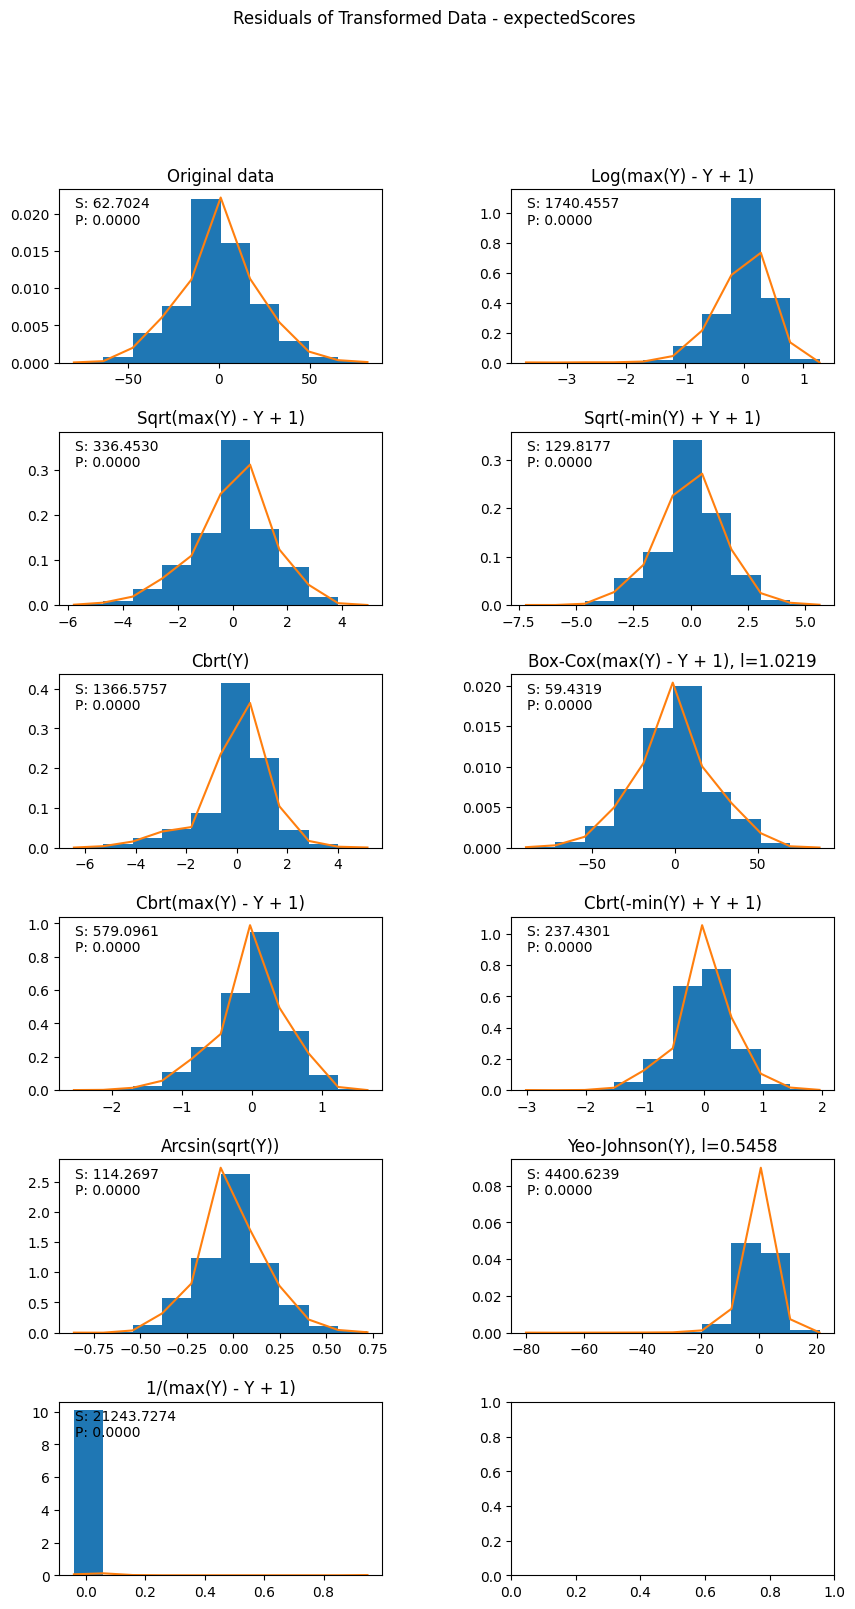

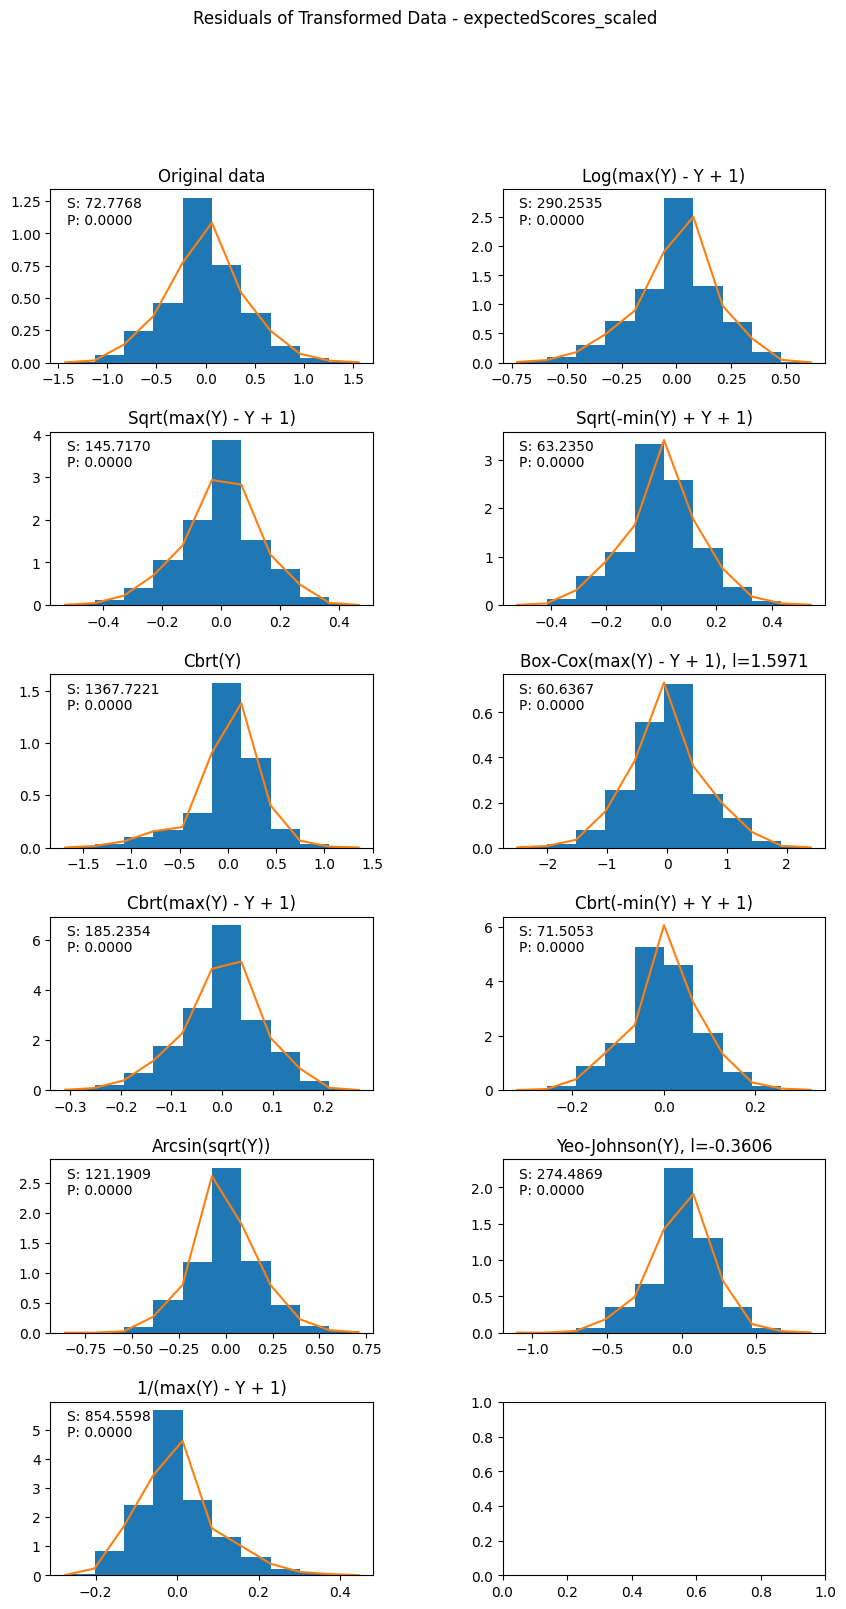

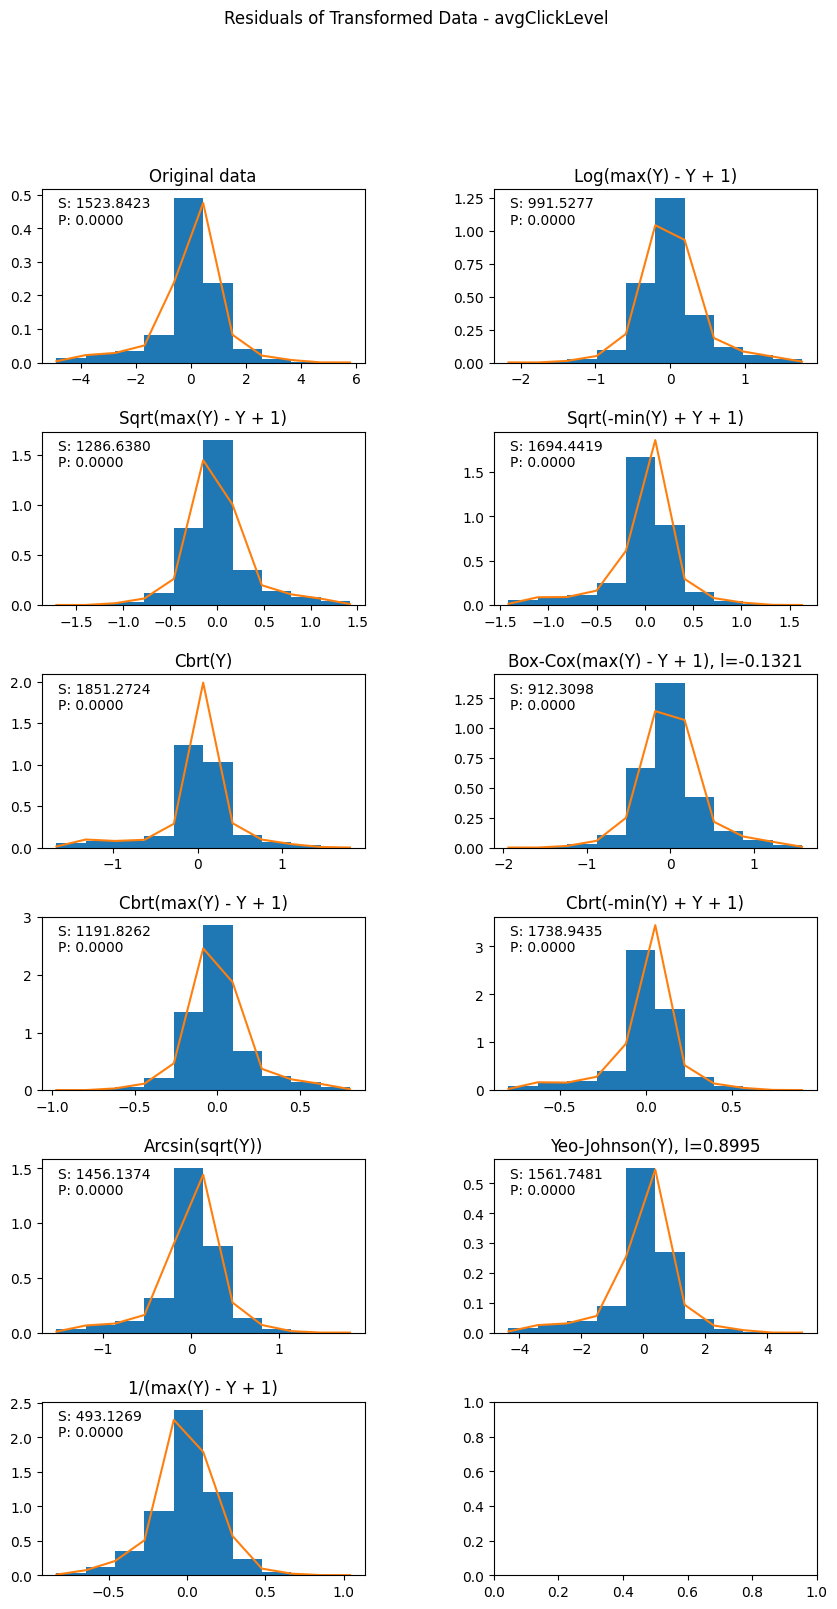

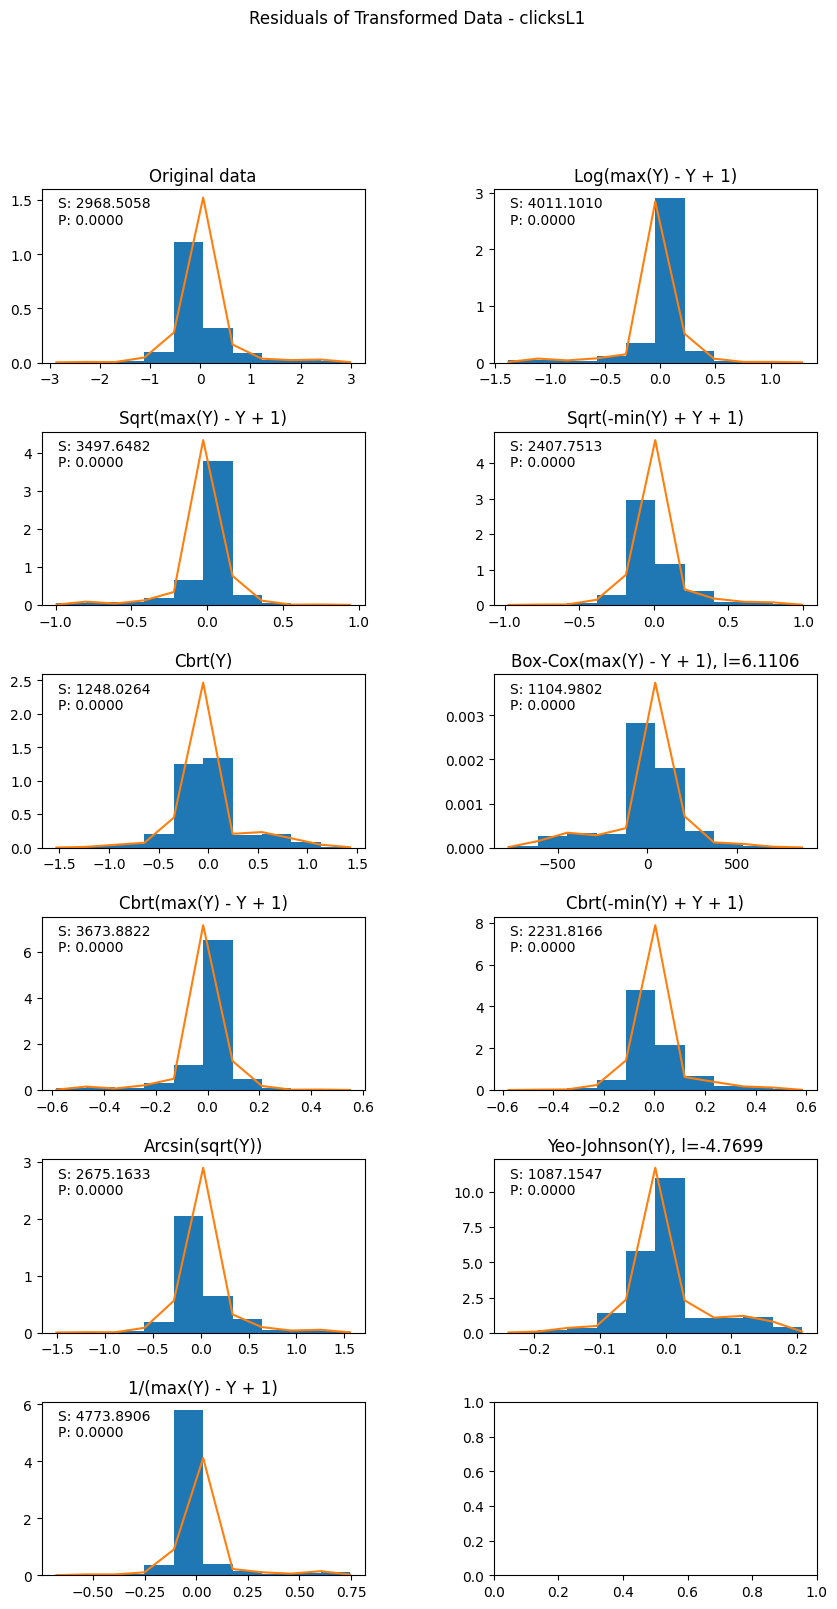

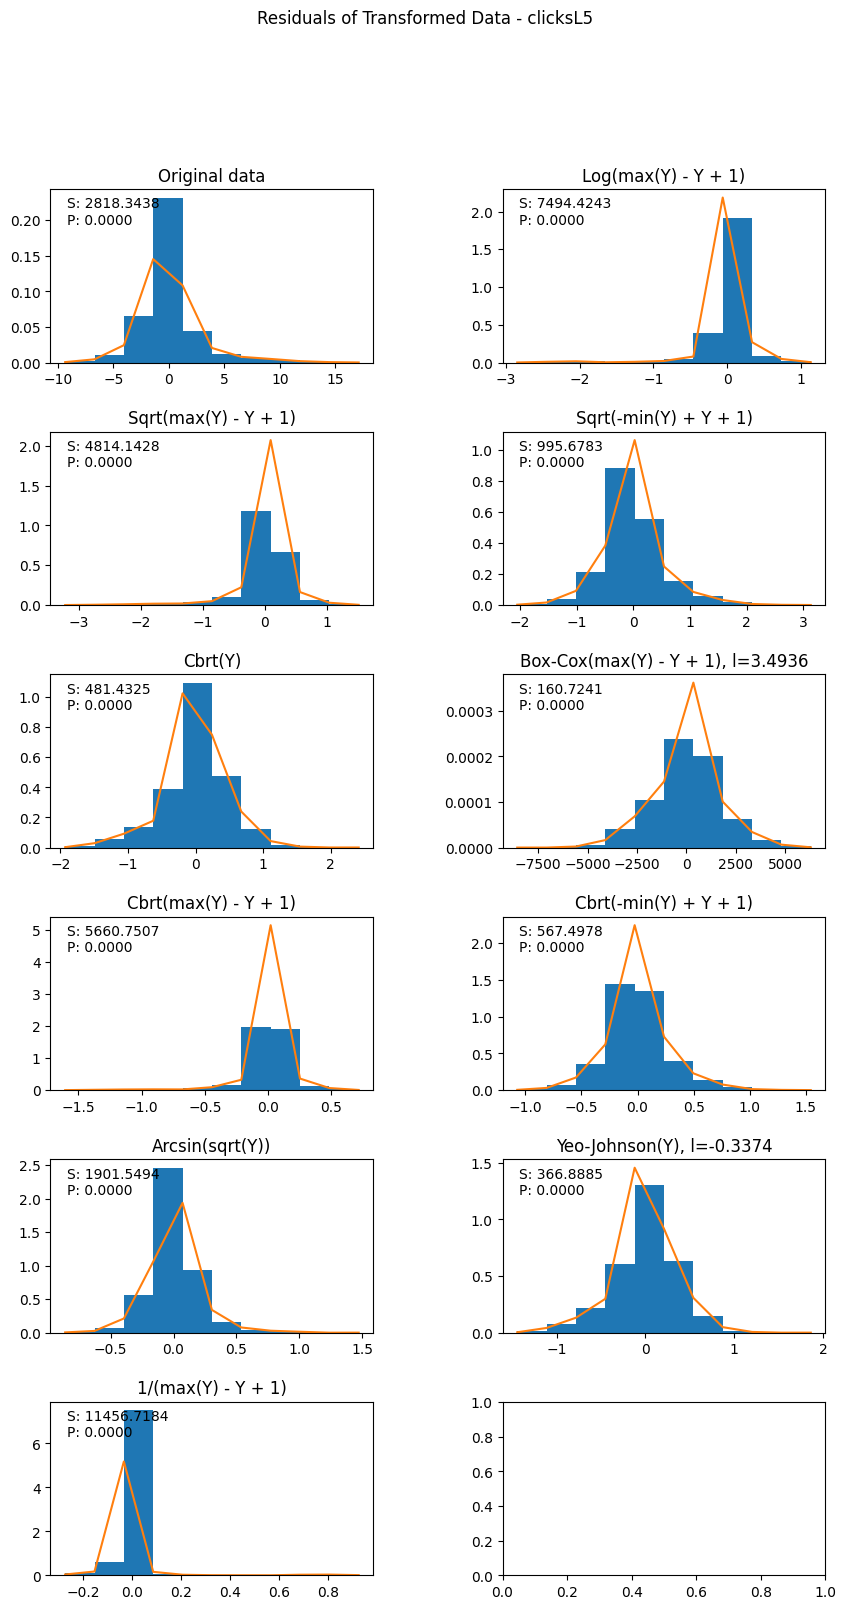

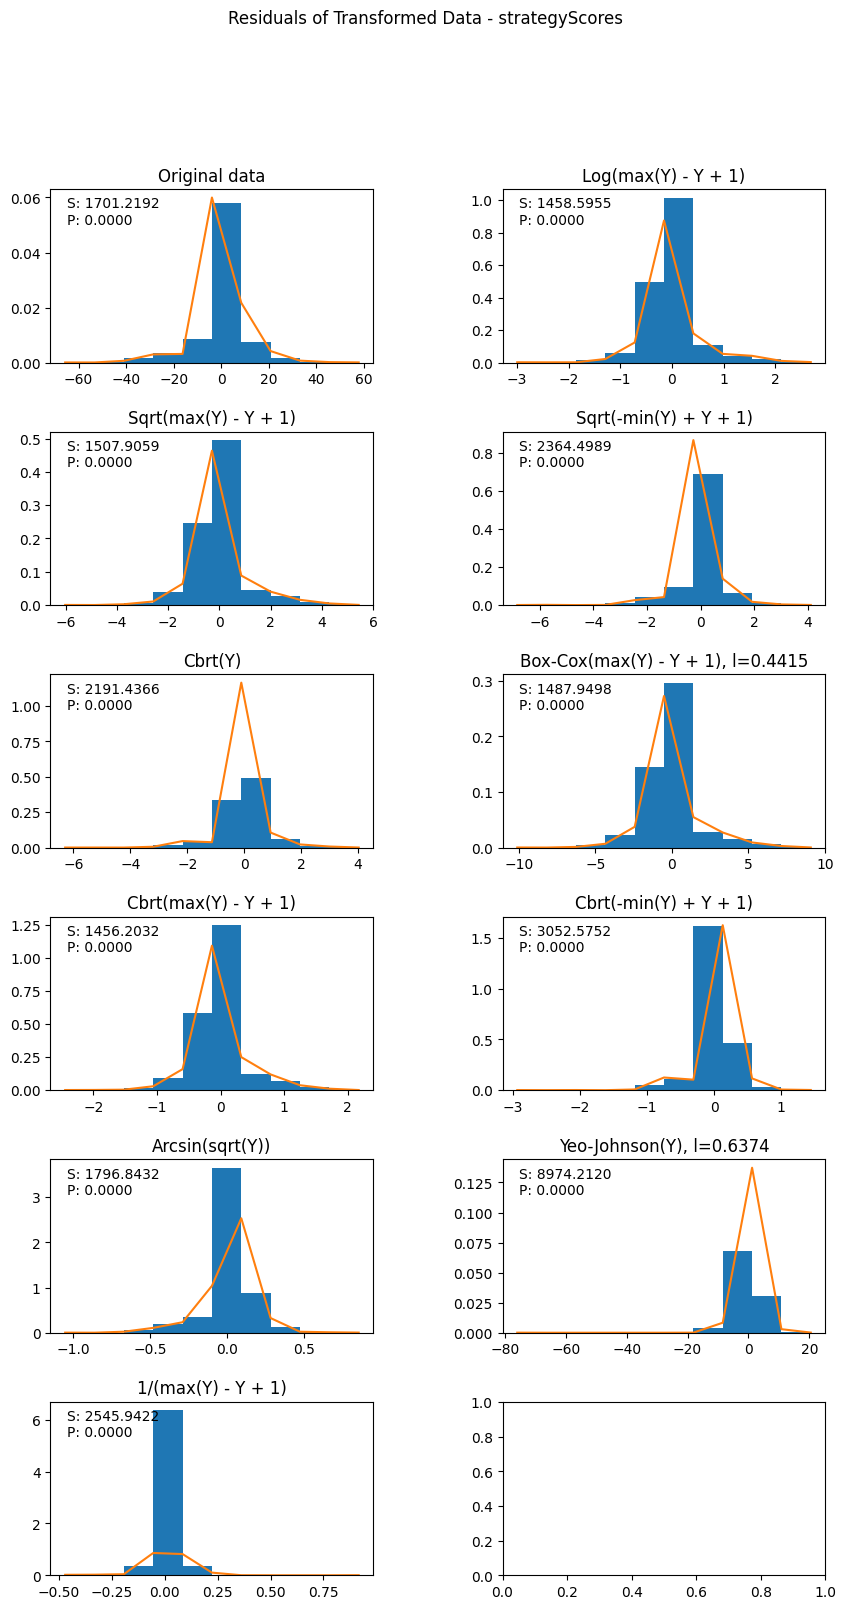

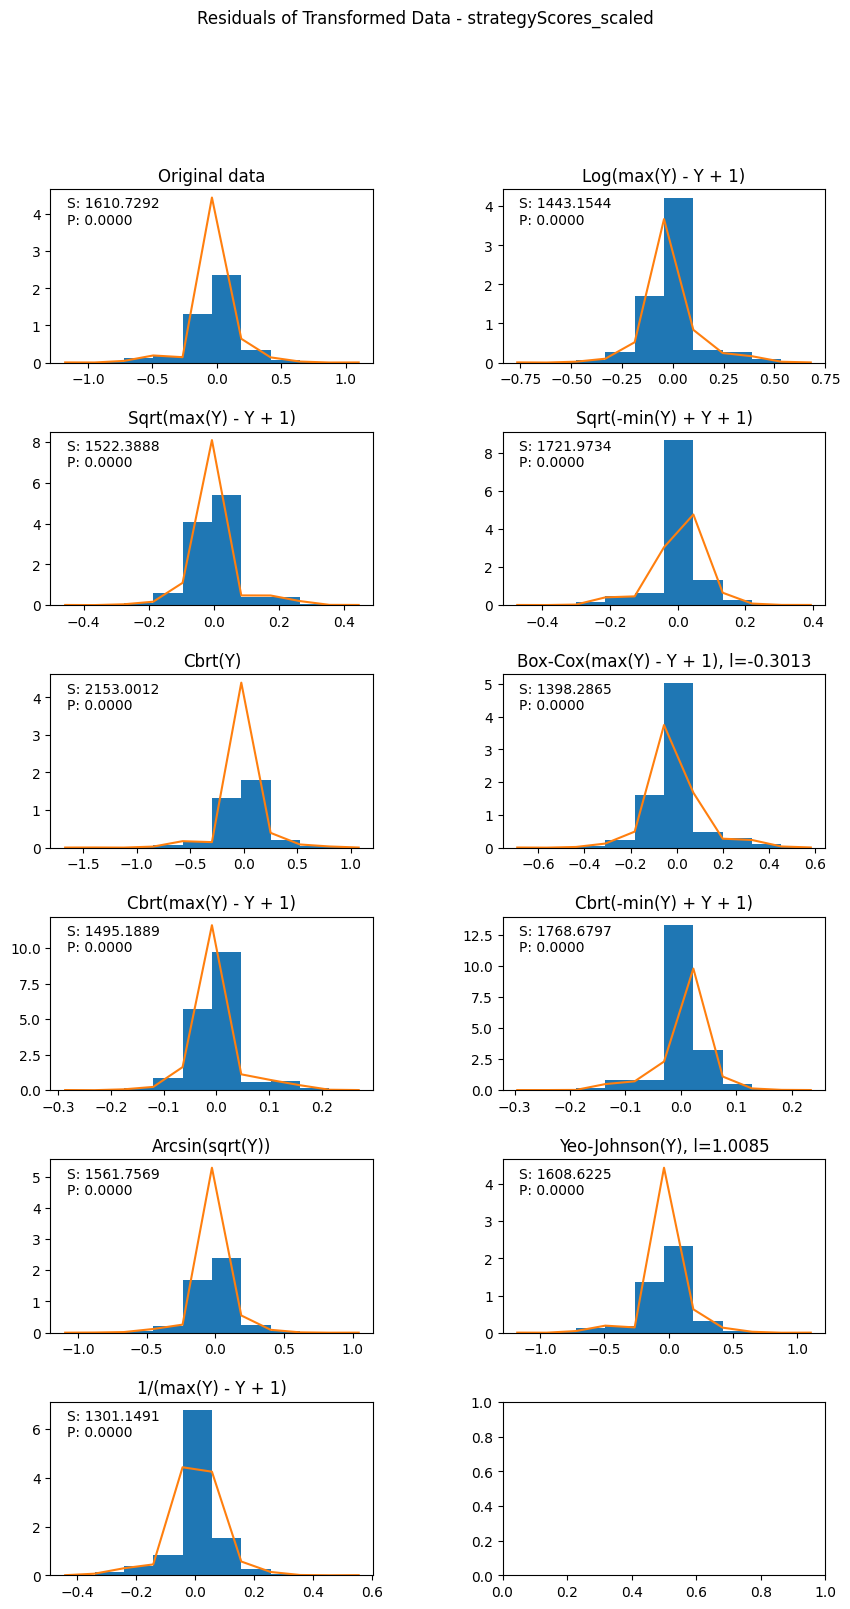

In [558]:
# Plotting residuals for all GLM Models

analysis_cols = {res: [] for res in response_vars}
highest_normality_trans = {res: "" for res in response_vars}

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(all_residuals[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(all_residuals[response_var])/2)),squeeze=False)
    plt.suptitle("Residuals of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    lowest_normality_stat = float("inf")
    for idx, trans in enumerate(all_residuals[response_var]):
        resids = trans[0]
        response_data = trans[1]
        label = trans[2]
        normaltest = trans[3]
        if normaltest.statistic < lowest_normality_stat:
            analysis_cols[response_var] = response_data
            highest_normality_trans[response_var] = label
            lowest_normality_stat = normaltest.statistic
        density = scipy.stats.gaussian_kde(resids)
        n, x, _ = ax[idx].hist(resids, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [559]:
# data which is to be used for the remainder of the analysis

# Displaying which of the data has the most normal residuals 
analysis_data = transformed_trials_df.copy()
for response_var in response_vars:
    print("{} - {}".format(response_var, highest_normality_trans[response_var]))
    analysis_data[response_var] = analysis_cols[response_var]
    

expectedScores - Box-Cox(max(Y) - Y + 1), l=1.0219
expectedScores_scaled - Box-Cox(max(Y) - Y + 1), l=1.5971
avgClickLevel - 1/(max(Y) - Y + 1)
clicksL1 - Yeo-Johnson(Y), l=-4.7699
clicksL5 - Box-Cox(max(Y) - Y + 1), l=3.4936
strategyScores - Cbrt(max(Y) - Y + 1)
strategyScores_scaled - 1/(max(Y) - Y + 1)


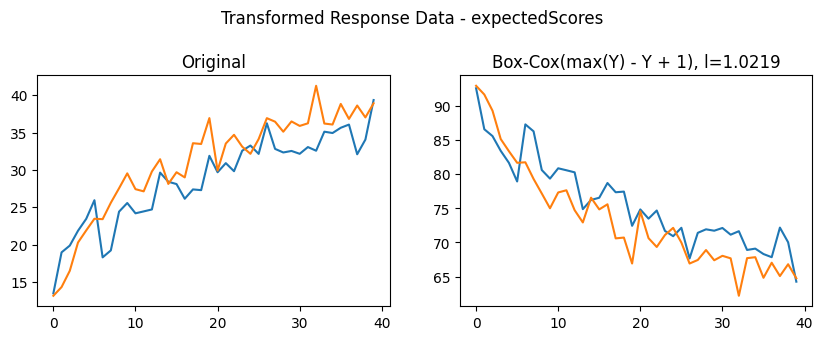

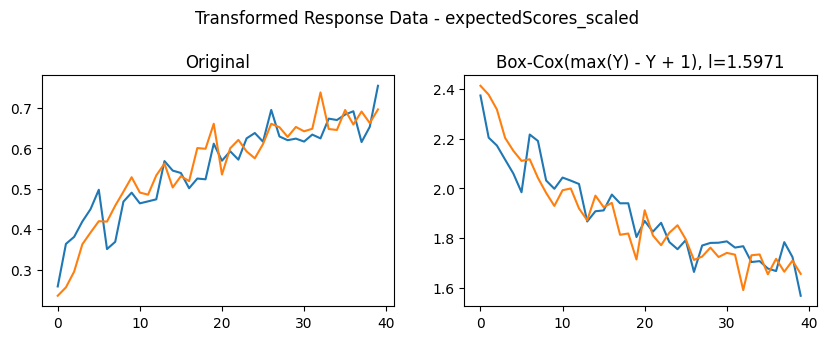

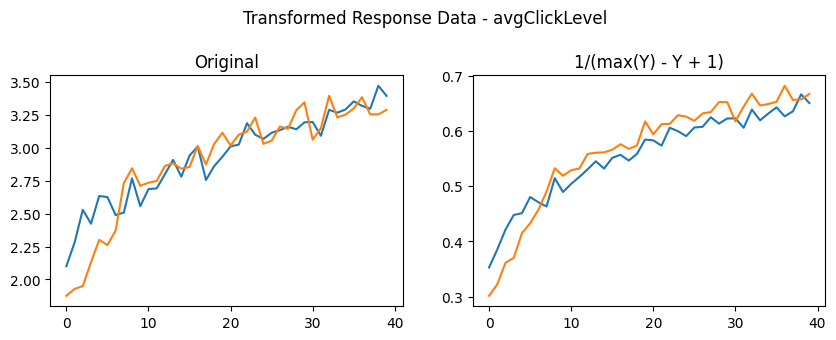

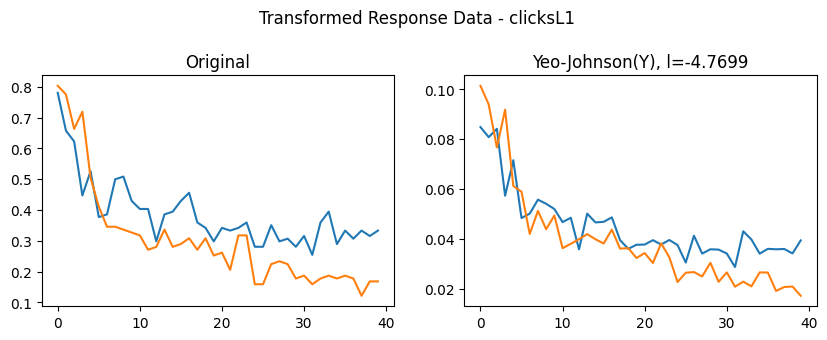

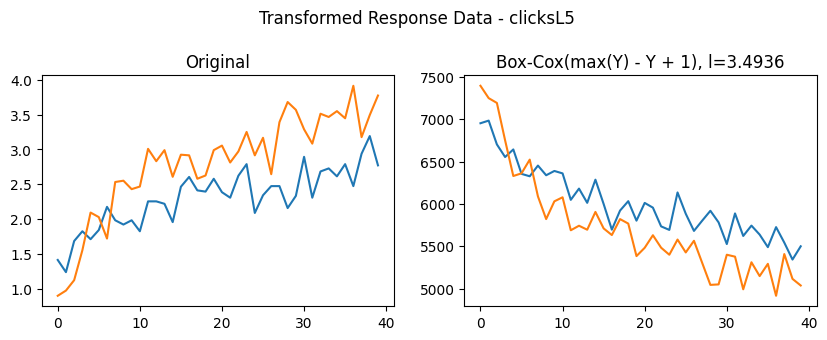

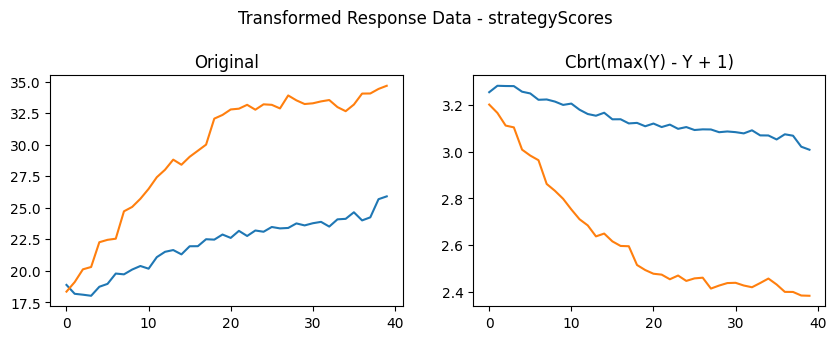

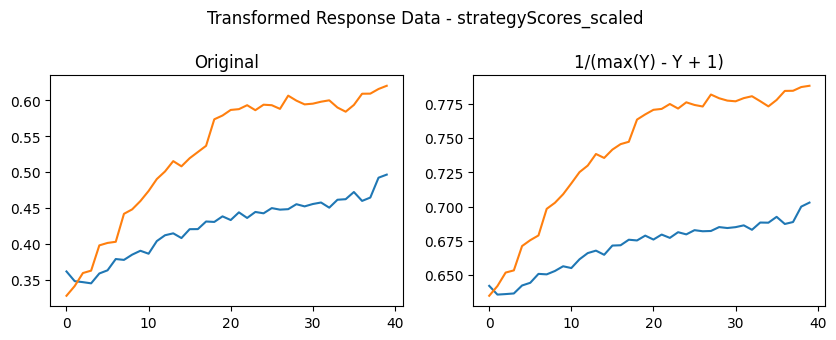

In [560]:
# Visualize transformed data for each response variable

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 3),squeeze=True)
    plt.suptitle("Transformed Response Data - {}".format(response_var),y=1.1)
    ax = ax.flatten()

    for idx, trans in enumerate([transformed_trials_df, analysis_data]):
        data = trans
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = "Original" if idx == 0 else highest_normality_trans[response_var]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

plt.show()

# 1.1.1 - Linear Regression: Finding Best Model of Learning vs. Performance

In [561]:
# If master switch is not turned on, select which data to use for this analysis
data_to_use = "all" # "1", "2", or "all"
data_to_use = data_to_use_master

In [562]:
# Manually set the partition
manually_set_partition = True
manual_partition = 10 # 10 for exp 1, 10 for exp 2, 9 for exp all

### Finding Best Model for Scarce Condition

In [563]:


test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.condition == 1].copy()

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_bic_scores_scarce = []
scarce_plot_data = []
scarce_glm_results = []

# Check all possible data splits for both conditions
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
    two_slope_formula = "expectedScores_scaled ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores_scaled ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
        
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_scarce.append((trialNum, bic1))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_scarce[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3,
        i3,
        partition_1_df,
        partition_2_df
    ))
    scarce_glm_results.append((trialNum, results_1, results_2))

In [566]:
# Finding the best partition of all significant ones 

mis_partition_exists = len(sig_bic_scores_scarce) > 0

if manually_set_partition: mis_partition_exists = True
if use_model_data:
    partition_candidates = [13] # Use partition from human dataset
elif mis_partition_exists:
    if manually_set_partition:
        partition_candidates = [manual_partition]
    else:
        sig_bic_scores_scarce = np.array(sig_bic_scores_scarce)

    
        g_range = np.arange(0, 1, 0.0001)
        best_partitions = []

        for gamma in g_range:
            # Minimum bic
            partition_scores = sig_bic_scores_scarce[:,1]
            best_partition = sig_bic_scores_scarce[np.argmin(partition_scores),0]
            best_partitions.append(best_partition)

        partition_candidates = np.unique(best_partitions)
    


        print("Partition candidates: ")
        print(partition_candidates)
        plt.plot(g_range, best_partitions)
        plt.xlabel("Gamma (Decay Factor)")
        plt.ylabel("Best Partition")
        plt.show()


In [567]:
# Showing GLM results - scarce

if mis_partition_exists:
    candidate_glm_results_scarce = [data for data in scarce_glm_results if float(data[0]) in partition_candidates]

    for trialNum, results_1, results_2 in candidate_glm_results_scarce:
        print("Trial Num: {}".format(trialNum))
        print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
        print(results_1.summary())

        print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
        print(results_2.summary())


Trial Num: 10

Two-Slope Model:
BIC LLF: 12243.0027

BIC Deviance: -34500.4273

AIC: 12217.3024

                   Generalized Linear Model Regression Results                   
Dep. Variable:     expectedScores_scaled   No. Observations:                 4560
Model:                               GLM   Df Residuals:                     4556
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                         0.85255
Method:                             IRLS   Log-Likelihood:                -6104.7
Date:                   Mon, 20 Nov 2023   Deviance:                       3884.2
Time:                           14:47:10   Pearson chi2:                 3.88e+03
No. Iterations:                        3   Pseudo R-squ. (CS):            0.03244
Covariance Type:               nonrobust                                         
                                              coef    std err          z      P>|z|

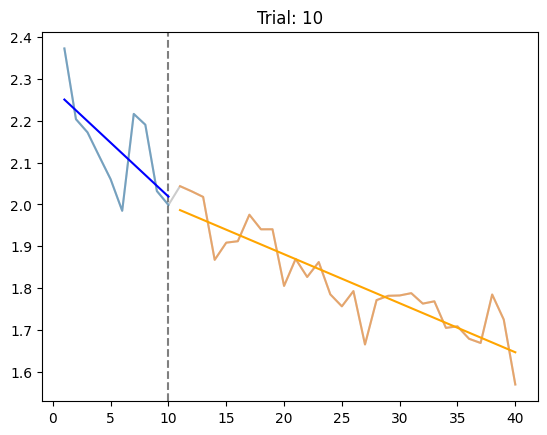

In [568]:
# Plotting candidate partitions - scarce
if mis_partition_exists:
    candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
    #significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_bic_scores_scarce[:,0]]

    which_plot = "candidates" #all, significant, candidates

    if which_plot == "candidates":
        plot_data = candidate_plot_data_scarce
    elif which_plot == "significant":
        plot_data = significant_plot_data_scarce
    else:
        plot_data = scarce_plot_data

    plot_single_slope = False
    plot_two_slope = True
    scatter = False
    error = False

    for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
        plt.figure()
        # Expected Score curves
        plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
        plt.plot(x1, y1, alpha=0.5)
        plt.plot(x2, y2, alpha=0.5)

        # Scatter points
        if scatter:
            plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
            plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

        # Partition line
        plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

        # Slope lines of one-slope model
        if plot_single_slope:
            x3 = np.concatenate([x1,x2],axis=0)
            plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)

        if plot_two_slope:
            # Slope lines of two-slope model
            plt.plot(x1, np.array(x1) * b1 + i1, color='b')
            plt.plot(x2, np.array(x2) * b2 + i2, color='orange')

        if error:
            plt.fill_between(x1, scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)

        plt.title("Trial: {}".format(trialNum))

    plt.show()

In [569]:
if mis_partition_exists:
    scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

    # Separating into learning and performance phase
    scarce_learning_data = analysis_data.loc[(analysis_data.condition == 1) & (analysis_data.trialNumbers <= scarce_partition)]
    scarce_performance_data = analysis_data.loc[(analysis_data.condition ==1) & (analysis_data.trialNumbers > scarce_partition)]

    # Without transformation
    scarce_learning_data_orig = filtered_data.loc[(filtered_data.condition == 1) & (filtered_data.trialNumbers <= scarce_partition)]
    scarce_performance_data_orig = filtered_data.loc[(filtered_data.condition ==1) & (filtered_data.trialNumbers > scarce_partition)]

    # Store the slope, intercept, etc. of the best partition
    scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Best Model for Control Condition

In [570]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For control trials
relevant_trials = test_df.loc[test_df.condition == 0].copy()

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_bic_scores_control = []
control_plot_data = []
control_glm_results = []
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
#     two_slope_formula = "expectedScores ~ trialNumbers + C(condition) + C(isPerformanceTrial) + trialNumbers:C(isPerformanceTrial)"
#     one_slope_formula = "expectedScores ~ trialNumbers + C(condition)"
    two_slope_formula = "expectedScores_scaled ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores_scaled ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_control.append((trialNum, bic1))
        
    x1 = all_trial_nos_control[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_control[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3, 
        i3,
        partition_1_df,
        partition_2_df
    ))
    control_glm_results.append((trialNum, results_1, results_2))

In [571]:
sig_bic_scores_control

[(3, 11296.696116441048),
 (4, 11294.731782604817),
 (5, 11293.37024273795),
 (6, 11292.49497408974),
 (7, 11291.319007864297),
 (8, 11290.903186378622),
 (9, 11290.881751190787),
 (10, 11290.786876739436),
 (11, 11291.807189412471),
 (12, 11292.852433919583),
 (13, 11293.175571527581),
 (14, 11293.176364618626),
 (15, 11295.001672521243),
 (16, 11295.906789101213),
 (17, 11296.692694500698),
 (18, 11296.65717329344),
 (19, 11296.844806119505),
 (20, 11295.237807813648),
 (21, 11298.325121739173),
 (22, 11299.13401037479),
 (23, 11299.402445406931)]

Partition candidates: 
[10]


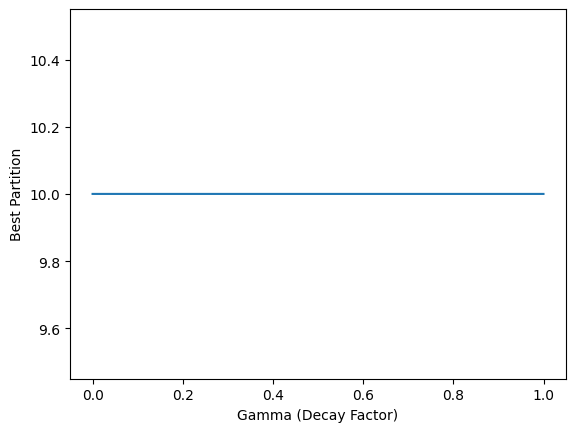

In [572]:
# Finding the best partition of all significant ones 

if use_model_data:
    partition_candidates = [9] # Use partition from human data
else:
    sig_bic_scores_control = np.array(sig_bic_scores_control)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_control[:,1]
        best_partition = sig_bic_scores_control[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)
    if manually_set_partition:
        partition_candidates = [manual_partition]
    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


In [573]:
# Showing GLM results - control
candidate_glm_results_control = [data for data in control_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_control:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 10

Two-Slope Model:
BIC LLF: 11290.7869

BIC Deviance: -32277.2275

AIC: 11265.3400

                   Generalized Linear Model Regression Results                   
Dep. Variable:     expectedScores_scaled   No. Observations:                 4280
Model:                               GLM   Df Residuals:                     4276
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                         0.81325
Method:                             IRLS   Log-Likelihood:                -5628.7
Date:                   Mon, 20 Nov 2023   Deviance:                       3477.4
Time:                           14:47:19   Pearson chi2:                 3.48e+03
No. Iterations:                        3   Pseudo R-squ. (CS):            0.04568
Covariance Type:               nonrobust                                         
                                              coef    std err          z      P>|z|

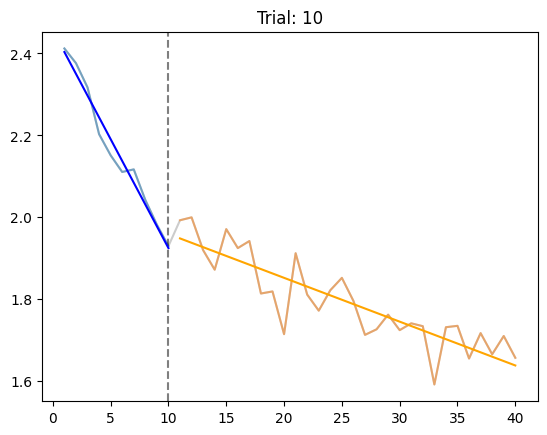

In [574]:
# Plotting candidate partitions - control
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
#significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_bic_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [575]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.condition == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.condition == 0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.condition == 0) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.condition == 0) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

if not mis_partition_exists:
    scarce_partition = control_partition # Somehow choose based on possible candidates

    # Separating into learning and performance phase
    scarce_learning_data = analysis_data.loc[(analysis_data.condition == 1) & (analysis_data.trialNumbers <= scarce_partition)]
    scarce_performance_data = analysis_data.loc[(analysis_data.condition ==1) & (analysis_data.trialNumbers > scarce_partition)]

    # Without transformation
    scarce_learning_data_orig = filtered_data.loc[(filtered_data.condition == 1) & (filtered_data.trialNumbers <= scarce_partition)]
    scarce_performance_data_orig = filtered_data.loc[(filtered_data.condition ==1) & (filtered_data.trialNumbers > scarce_partition)]

    # Store the slope, intercept, etc. of the best partition
    scarce_partition_plot_data = [data for data in scarce_plot_data if data[0] == scarce_partition][0]

# Analysis Helper Functions

In [576]:
table_replace_chars = {
    "_": "\\_",
    "~": "$\sim$",
    "*": "$*$",
    "+": "$+$",
    "|": "$|$",
    "C(condition)": "condition"
}

experiment_name_map = {
    "1": "MisOrig",
    "2": "MisRep",
    "all": "MisCombined"
}
numeral_to_word_map = {
    "0": "Zero",
    "1": "One",
    "2": "Two",
    "3": "Three",
    "4": "Four"
}

In [577]:
table_template_rs = "\\newcommand{{\\table{0}}}{{\n" + \
"\\begin{{table}} \n" + \
"\\centering \n" + \
"\t\\caption{{LMM results for Analysis {1}}} \n" + \
"\t\\begin{{tabular}}{{c|CC|CC}} \n" + \
"\t\t\\hline \n" + \
"\t\t\\multicolumn{{5}}{{c}}{{ }}\\\\[-1em] \n" + \
"\t\t\\multicolumn{{5}}{{c}}{{{2}}}\\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\hline \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\multirow{{2}}{{*}}{{\\textbf{{Regressor}}}} & \\multicolumn{{2}}{{c|}}{{\\textbf{{Rapid Learning Phase}}}} & \\multicolumn{{2}}{{c}}{{\\textbf{{Slow Improvement Phase}}}} \\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t& $\\beta$ & $p$ & $\\beta$ & $p$\\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\hline \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\tIntercept & {3} & {4} & {5} & {6} \\\\ \n" + \
"\t\tcondition & {7} & {8} & {9} & {10} \\\\ \n" + \
"\t\ttrialNumbers & {11} & {12} & {13} & {14} \\\\ \n" + \
"\t\ttrialNumbers:condition & {15} & {16} & {17} & {18} \\\\ \n" + \
"\t\tVar RI & {19} & {20} & {21} & {22} \\\\ \n" + \
"\t\tVar RS & {23} & {24} & {25} & {26} \\\\ \n" + \
"\t\tCov RI$*$RS & {27} & {28} & {29} & {30} \\\\ \n" + \
"\t\t\\hline \n" + \
"\t\\end{{tabular}} \n" + \
"\t\\label{{table:{31}}} \n" + \
"\\end{{table}} \n" + \
"}}"

table_template_ri = "\\newcommand{{\\table{0}}}{{\n" + \
"\\begin{{table}} \n" + \
"\\centering \n" + \
"\t\\caption{{LMM results for Analysis {1}}} \n" + \
"\t\\begin{{tabular}}{{c|CC|CC}} \n" + \
"\t\t\\hline \n" + \
"\t\t\\multicolumn{{5}}{{c}}{{ }}\\\\[-1em] \n" + \
"\t\t\\multicolumn{{5}}{{c}}{{{2}}}\\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\hline \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\multirow{{2}}{{*}}{{\\textbf{{Regressor}}}} & \\multicolumn{{2}}{{c|}}{{\\textbf{{Rapid Learning Phase}}}} & \\multicolumn{{2}}{{c}}{{\\textbf{{Slow Improvement Phase}}}} \\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t& $\\beta$ & $p$ & $\\beta$ & $p$\\\\ \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\t\\hline \n" + \
"\t\t&&&&\\\\[-1em] \n" + \
"\t\tIntercept & {3} & {4} & {5} & {6} \\\\ \n" + \
"\t\tcondition & {7} & {8} & {9} & {10} \\\\ \n" + \
"\t\ttrialNumbers & {11} & {12} & {13} & {14} \\\\ \n" + \
"\t\ttrialNumbers:condition & {15} & {16} & {17} & {18} \\\\ \n" + \
"\t\tVar RI & {19} & {20} & {21} & {22} \\\\ \n" + \
"\t\t\\hline \n" + \
"\t\\end{{tabular}} \n" + \
"\t\\label{{table:{23}}} \n" + \
"\\end{{table}} \n" + \
"}}"

table_template_map = {
    "1": table_template_ri,
    "2": table_template_rs,
    "all": table_template_rs
}

In [578]:
# Function to convert LMM results into a table

def LMM_to_table(learning_lmm, performance_lmm, anal_num, formula, which_data):
    argument_list = []

    # Argument 0 - command name
    command_name = experiment_name_map[which_data] + "".join([numeral_to_word_map[n] for n in anal_num.split(".")])
    argument_list.append(command_name)
    
    # Argument 1 - Analysis number
    argument_list.append(anal_num)
    
    # Argument 2 - formula
    for k,v in table_replace_chars.items():
        formula = formula.replace(k,v)
    argument_list.append(formula)
    
    # All stats arguments
    param_list = ["Intercept", "C(condition)[T.1]", "trialNumbers", "trialNumbers:C(condition)[T.1]",
                 "Group Var"]
    if which_data != "1":
        param_list += ["trialNumbers Var", "Group x trialNumbers Cov"]
    
    stats_args = []
    for par in param_list:
        for res in [l_results, results]:
            try:
                pval = res.pvalues[par]
            except:
                pval = 2
                
            try:
                beta = res.params[par]
            except:
                beta = float("inf")
                #print(par, res.params.keys())
            if pval < 0.05:
                # Significant in bold
                bprint = "\\textbf{{{0:0.2f}}}".format(beta)
                pprint = "\\textbf{{{0:0.2f}}}".format(pval)
            elif pval > 1:
                # Random effects have no pvalue
                if beta != float("inf"):
                    bprint = "{0:0.2f}".format(beta)
                else:
                    bprint = ""
                pprint = ""
            else:
                # Non-significant effects not bold
                bprint = "{0:0.2f}".format(beta)
                pprint = "{0:0.2f}".format(pval)
            stats_args += [bprint, pprint]
    argument_list += stats_args
    
    # Final argument: label
    label = command_name
    argument_list.append(label)
    
    table_template = table_template_map[which_data] 
    
    return table_template.format(*argument_list)

# 1.1 - Linear Regression: Expected Score vs. Trial Number x Condition

In [579]:
# Select the response variable for this analysis

response_var = "expectedScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores_scaled
No. Observations:   2210      Method:               REML                 
No. Groups:         221       Scale:                0.3970               
Min. group size:    10        Log-Likelihood:       -2378.4406           
Max. group size:    10        Converged:            Yes                  
Mean group size:    10.0                                                 
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.457    0.071 34.627 0.000  2.318  2.596
C(condition)[T.1]              -0.180    0.099 -1.823 0.068 -0.374  0.014
trialNumbers                   -0.053    0.007 -7.928 0.000 -0.066 -0.040
trialNumbers:C(condition)[T.1]  0.027    0.009  2.932 0.

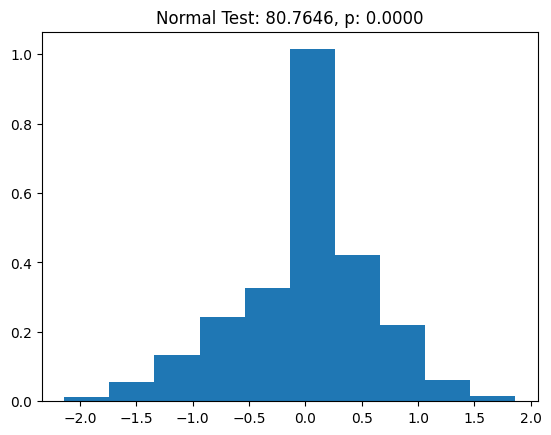

In [580]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    # Pre-registered only random intercept model and no centering of regressors for first experiment
    standardize_cols = []
    use_random_slope = False
#     standardize_cols = ["trialNumbers"]
#     use_random_slope = True
    
else:
    standardize_cols = ["trialNumbers"]
    use_random_slope = True

re_formula = "trialNumbers" if use_random_slope else ""
    
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())#}/learning_df[col].std()
    
    
mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

l_results = glm.fit()

print(l_results.summary())
resids = l_results.resid_response if not mixed else l_results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

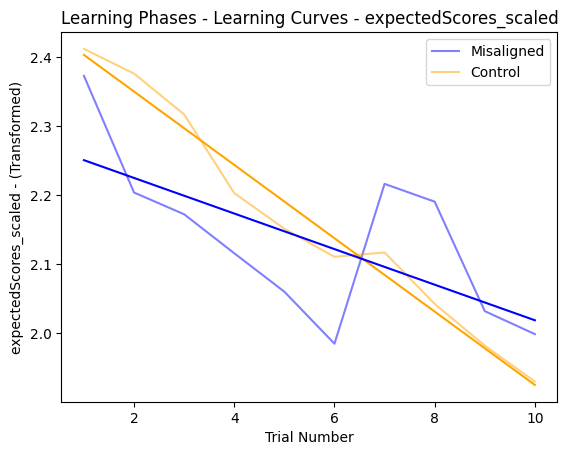

In [581]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = l_results.params['trialNumbers']
b2 = l_results.params['trialNumbers'] + l_results.params['trialNumbers:C(condition)[T.1]']
i1 = l_results.params['Intercept']
i2 = l_results.params['Intercept'] + l_results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores_scaled
No. Observations:   6630      Method:               REML                 
No. Groups:         221       Scale:                35.5910              
Min. group size:    30        Log-Likelihood:       -21671.1996          
Max. group size:    30        Converged:            Yes                  
Mean group size:    30.0                                                 
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      20.661    0.764 27.027 0.000 19.163 22.159
C(condition)[T.1]               0.493    1.064  0.463 0.643 -1.594  2.579
trialNumbers                   -0.107    0.012 -8.790 0.000 -0.131 -0.083
trialNumbers:C(condition)[T.1] -0.010    0.017 -0.612 0.

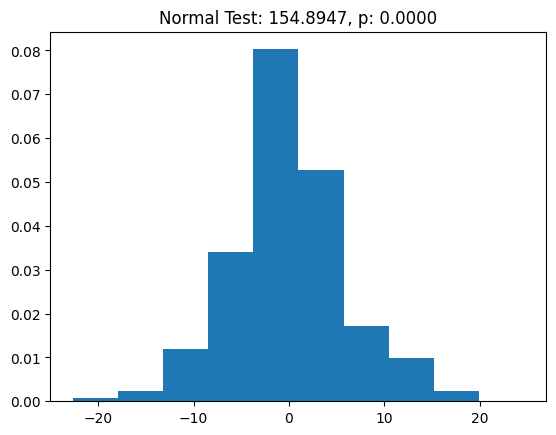

In [582]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    standardize_cols = []
    use_random_slope = False
else:
    standardize_cols = ["trialNumbers"]
    use_random_slope = True

re_formula = "trialNumbers" if use_random_slope else ""

for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()

performance_df[response_var] = performance_df[response_var] * 10
mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

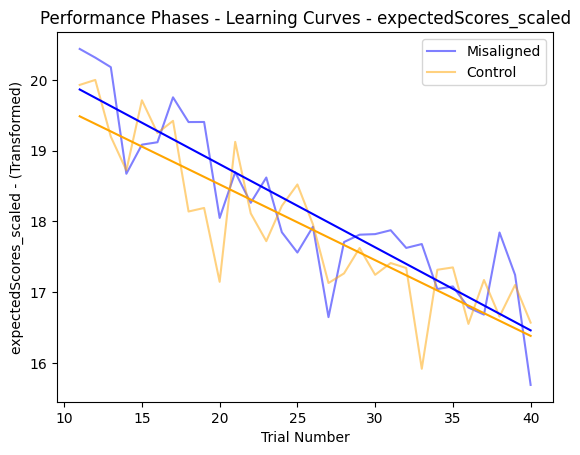

In [583]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

In [584]:
display_formula = "{} ~ trialNumbers*C(condition)".format(response_var)
if use_random_slope: 
    display_formula +=  "+ (1 + trialNumbers|participant)"
else:
    display_formula +=  "+ (1 + participant)"
table = LMM_to_table(l_results, results, "1.1", display_formula, data_to_use_master)

In [585]:
print(table)

\newcommand{\tableMisOrigOneOne}{
\begin{table} 
\centering 
	\caption{LMM results for Analysis 1.1} 
	\begin{tabular}{c|CC|CC} 
		\hline 
		\multicolumn{5}{c}{ }\\[-1em] 
		\multicolumn{5}{c}{expectedScores\_scaled $\sim$ trialNumbers$*$condition$+$ (1 $+$ participant)}\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		\multirow{2}{*}{\textbf{Regressor}} & \multicolumn{2}{c|}{\textbf{Rapid Learning Phase}} & \multicolumn{2}{c}{\textbf{Slow Improvement Phase}} \\ 
		&&&&\\[-1em] 
		& $\beta$ & $p$ & $\beta$ & $p$\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		Intercept & \textbf{2.46} & \textbf{0.00} & \textbf{20.66} & \textbf{0.00} \\ 
		condition & -0.18 & 0.07 & 0.49 & 0.64 \\ 
		trialNumbers & \textbf{-0.05} & \textbf{0.00} & \textbf{-0.11} & \textbf{0.00} \\ 
		trialNumbers:condition & \textbf{0.03} & \textbf{0.00} & -0.01 & 0.54 \\ 
		Var RI & \textbf{0.89} & \textbf{0.00} & \textbf{1.43} & \textbf{0.00} \\ 
		\hline 
	\end{tabular} 
	\label{table:MisOrigOneOne} 
\end{table} 
}


# 1.2 - Independent Samples T-test

In [237]:
# Select the response variable for this analysis

response_var = "clicksL1"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [238]:
use_transformed = False
exclude_invalid_clicks = True

if use_transformed:
    c_data = control_performance_data
    s_data = scarce_performance_data
else:
    c_data = control_performance_data_orig
    s_data = scarce_performance_data_orig

if exclude_invalid_clicks:
    c_data = c_data.loc[c_data.clickStratsValid]
    s_data = s_data.loc[s_data.clickStratsValid]

    # Using the transformed data divided into phases
    
control_averages = c_data.groupby('workerId').mean(numeric_only=True)
scarce_averages = s_data.groupby('workerId').mean(numeric_only=True)
    

In [239]:
# Looking at distribution of difference between means (by bootstrapping)
N = 250
def get_bootstrapped_dataset(vals, n):
    return np.random.choice(vals, replace=True, size=n)

num_samples = 100
c_means = []
s_means = []
for i in range(num_samples):
    c_means.append(get_bootstrapped_dataset(np.array(control_averages[response_var]), N).mean())
    s_means.append(get_bootstrapped_dataset(np.array(scarce_averages[response_var]), N).mean())

c_means = np.array(c_means)
s_means = np.array(s_means)

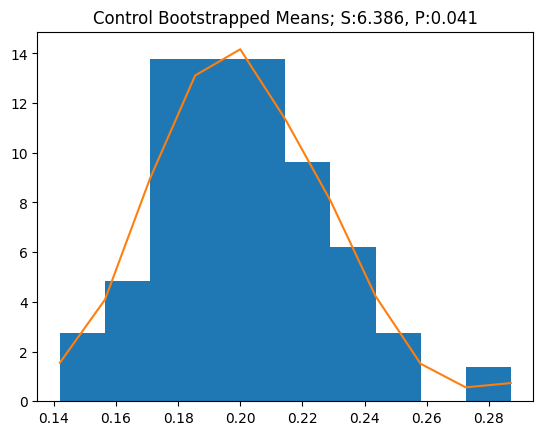

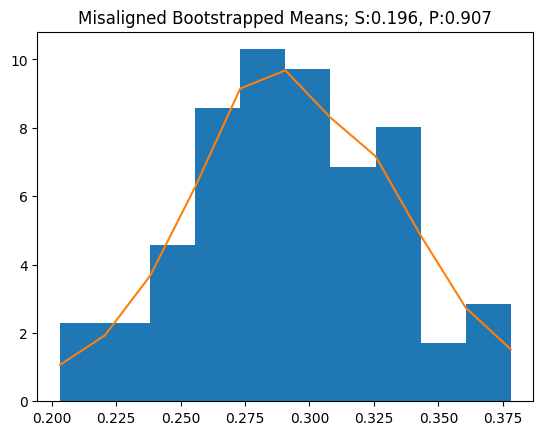

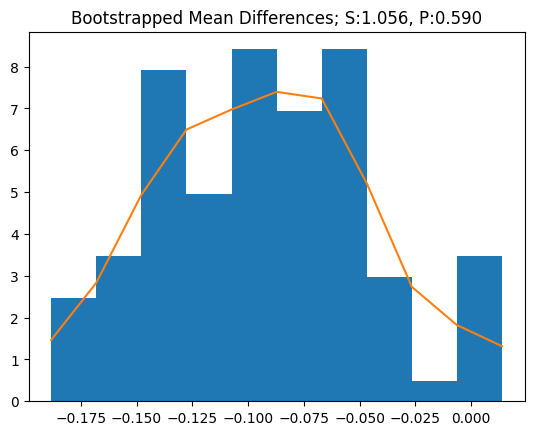

In [240]:
for data, label in [
    (c_means, "Control Bootstrapped Means"),
    (s_means, "Misaligned Bootstrapped Means"),
    (c_means - s_means, "Bootstrapped Mean Differences")
]:
    
    plt.figure()
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = plt.hist(data, density=True)
    plt.title(label + "; S:{0:0.3f}, P:{1:0.3f}".format(normaltest.statistic, normaltest.pvalue))
    plt.plot(x, density(x))

plt.show()

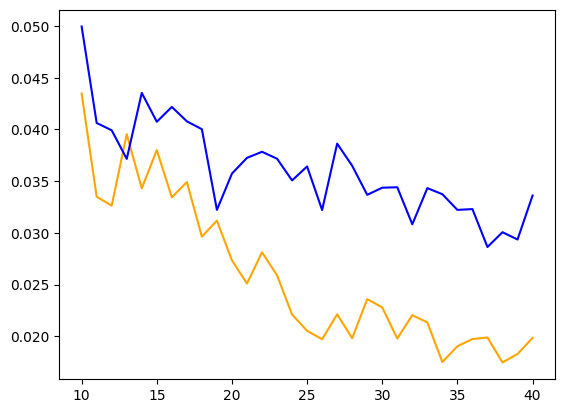

In [241]:
plt.figure()
plt.plot(np.sort(np.unique(control_performance_data.trialNumbers)), control_performance_data.groupby('trialNumbers').mean(numeric_only=True)[response_var], color='orange')
plt.plot(np.sort(np.unique(scarce_performance_data.trialNumbers)), scarce_performance_data.groupby('trialNumbers').mean(numeric_only=True)[response_var], color='b')
plt.show()

0.20238095238095238 0.43632726235936736
0.28556740778820205 0.5975724245370155


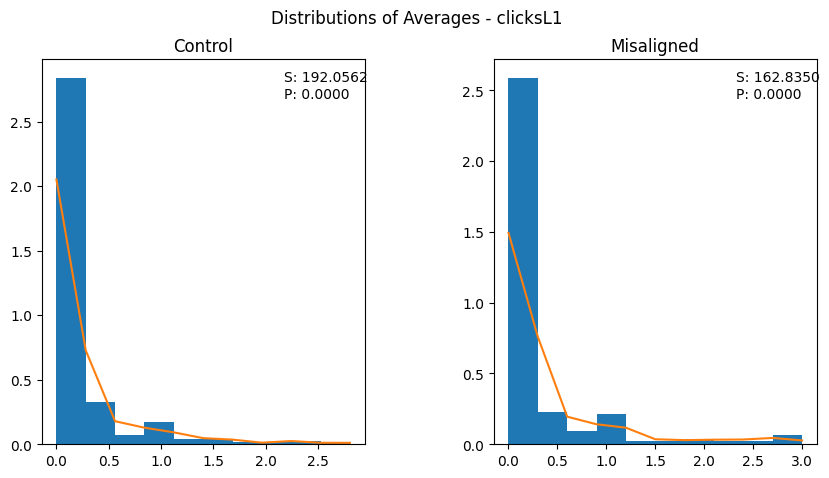

In [242]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Averages - {}".format(response_var))
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Misaligned")]):
    data = group[0][response_var]
    label = group[1]
    print(data.mean(), data.std())#/np.sqrt(len(data)))
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [243]:
# Perform independent T-test if data is normal


two = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='greater')

print("Response Variable: {}".format(response_var))
print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Misaligned < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Misaligned > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Response Variable: clicksL1
Two-Sided:
	Statistic: 1.783
	P-value: 0.07511164951537255
Misaligned < Control:
	Statistic: 1.783
	P-value: 0.9624441752423137
Misaligned > Control:
	Statistic: 1.783
	P-value: 0.037555824757686276


In [245]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Misaligned < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Misaligned > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 32145.000
	P-value: 0.7305063475006397
Misaligned < Control:
	Statistic: 32145.000
	P-value: 0.6349965595450273
Misaligned > Control:
	Statistic: 32145.000
	P-value: 0.36525317375031985


# 1.3 - Independent Samples T-test of First Trial Scores

In [171]:
# Select the response variable for this analysis

response_var = "expectedScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

AssertionError: clicksL2 is not a valid response variable

In [172]:
use_transformed = False

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_learning_data.loc[control_learning_data.trialNumbers == 1]
    scarce_averages = scarce_learning_data.loc[scarce_learning_data.trialNumbers == 1]
else:
    # Using the original data divided into phases
    control_averages = control_learning_data_orig.loc[control_learning_data_orig.trialNumbers == 1]
    scarce_averages = scarce_learning_data_orig.loc[scarce_learning_data_orig.trialNumbers == 1]
    

0.503968253968254 0.8723189585937238
0.6133828996282528 0.9807699944152511


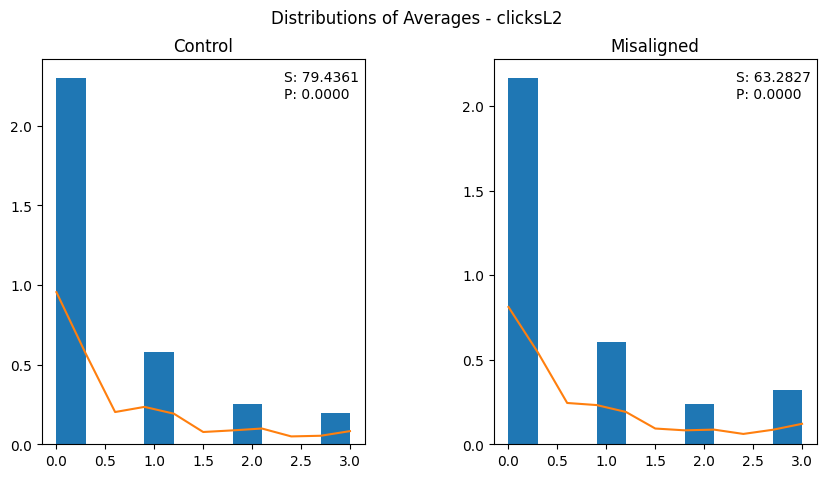

In [173]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Averages - {}".format(response_var))
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Misaligned")]):
    data = group[0][response_var]
    label = group[1]
    print(data.mean(), data.std())#np.sqrt(len(data)))
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [174]:
# Perform independent T-test if data is normal


two = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='greater')

print("Response Variable: {}".format(response_var))
print("Two-Sided:")
print("\tStatistic:| {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Response Variable: clicksL2
Two-Sided:
	Statistic:| 1.342
	P-value: 0.18013911130565108
Scarce < Control:
	Statistic: 1.342
	P-value: 0.9099304443471745
Scarce > Control:
	Statistic: 1.342
	P-value: 0.09006955565282554


In [175]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Misaligned < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Misaligned > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))


print("Mann–Whitney $U = {0:0.1f}$, $P = {1:0.3f}$, one-tailed".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 35508.500
	P-value: 0.2588247826031561
Misaligned < Control:
	Statistic: 35508.500
	P-value: 0.8707350862185175
Misaligned > Control:
	Statistic: 35508.500
	P-value: 0.12941239130157806
Mann–Whitney $U = 35508.5$, $P = 0.129$, one-tailed


# 2.1 - Linear Regression: AvgClickDepth vs. Trial Number x Condition

In [586]:
# Select the response variable for this analysis

response_var = "avgClickLevel"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     avgClickLevel
No. Observations:       2140        Method:                 REML         
No. Groups:             214         Scale:                  0.0401       
Min. group size:        10          Log-Likelihood:         100.1276     
Max. group size:        10          Converged:              Yes          
Mean group size:        10.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.275    0.027 10.372 0.000  0.223  0.327
C(condition)[T.1]               0.094    0.038  2.502 0.012  0.020  0.167
trialNumbers                    0.026    0.002 12.376 0.000  0.022  0.031
trialNumbers:C(condition)[T.1] -0.012    0.003 -4.007 0.

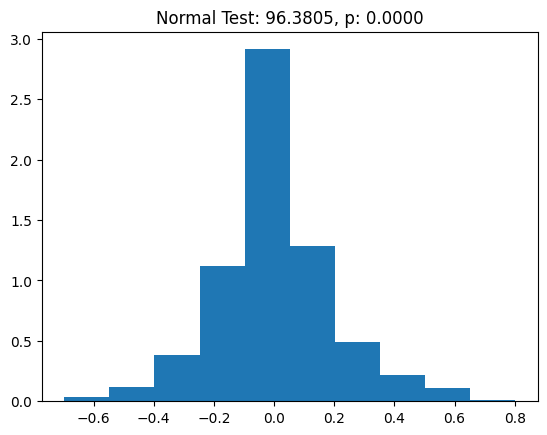

In [587]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
#     standardize_cols = ["trialNumbers"]
#     use_random_slope = True
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""
    
    
for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean()) #/ learning_df[col].std()



mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

l_results = glm.fit()

print(l_results.summary())
resids = l_results.resid_response if not mixed else l_results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

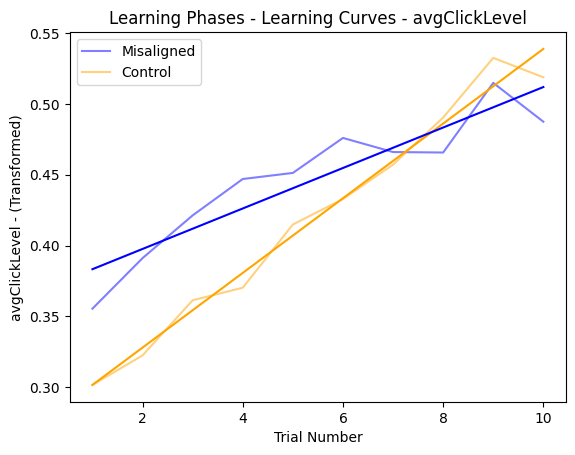

In [588]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = l_results.params['trialNumbers']
b2 = l_results.params['trialNumbers'] + l_results.params['trialNumbers:C(condition)[T.1]']
i1 = l_results.params['Intercept']
i2 = l_results.params['Intercept'] + l_results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     avgClickLevel
No. Observations:       6420        Method:                 REML         
No. Groups:             214         Scale:                  3.4496       
Min. group size:        30          Log-Likelihood:         -13575.9701  
Max. group size:        30          Converged:              Yes          
Mean group size:        30.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       4.978    0.329 15.138 0.000  4.333  5.622
C(condition)[T.1]              -0.362    0.465 -0.779 0.436 -1.274  0.549
trialNumbers                    0.046    0.004 12.130 0.000  0.039  0.053
trialNumbers:C(condition)[T.1]  0.005    0.005  1.024 0.

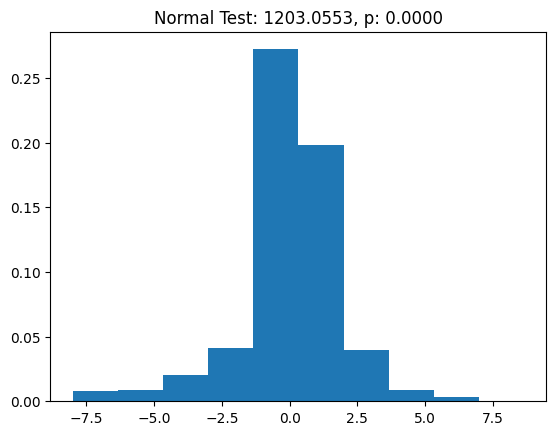

In [589]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""
    
for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()

# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]
performance_df[response_var] = performance_df[response_var] * 10

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

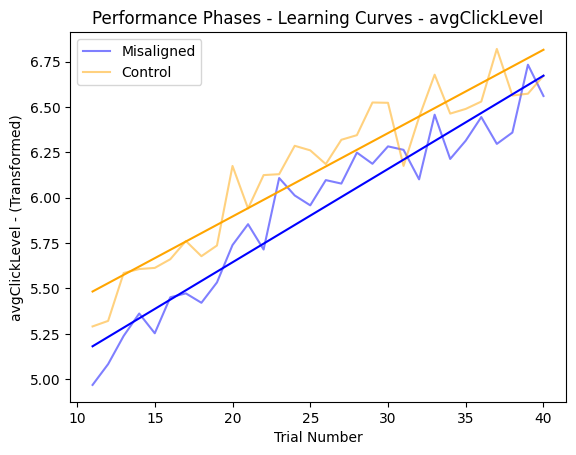

In [590]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

In [591]:
display_formula = "{} ~ trialNumbers*C(condition)".format(response_var)
if use_random_slope: 
    display_formula +=  "+ (1 + trialNumbers|participant)"
else:
    display_formula +=  "+ (1 + participant)"
table = LMM_to_table(l_results, results, "2.1", display_formula, data_to_use_master)

In [592]:
print(table)

\newcommand{\tableMisOrigTwoOne}{
\begin{table} 
\centering 
	\caption{LMM results for Analysis 2.1} 
	\begin{tabular}{c|CC|CC} 
		\hline 
		\multicolumn{5}{c}{ }\\[-1em] 
		\multicolumn{5}{c}{avgClickLevel $\sim$ trialNumbers$*$condition$+$ (1 $+$ participant)}\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		\multirow{2}{*}{\textbf{Regressor}} & \multicolumn{2}{c|}{\textbf{Rapid Learning Phase}} & \multicolumn{2}{c}{\textbf{Slow Improvement Phase}} \\ 
		&&&&\\[-1em] 
		& $\beta$ & $p$ & $\beta$ & $p$\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		Intercept & \textbf{0.28} & \textbf{0.00} & \textbf{4.98} & \textbf{0.00} \\ 
		condition & \textbf{0.09} & \textbf{0.01} & -0.36 & 0.44 \\ 
		trialNumbers & \textbf{0.03} & \textbf{0.00} & \textbf{0.05} & \textbf{0.00} \\ 
		trialNumbers:condition & \textbf{-0.01} & \textbf{0.00} & 0.01 & 0.31 \\ 
		Var RI & \textbf{1.41} & \textbf{0.00} & \textbf{3.03} & \textbf{0.00} \\ 
		\hline 
	\end{tabular} 
	\label{table:MisOrigTwoOne} 
\end{table} 


# 2.2 - Linear Regression: ClicksL5 vs. Trial Number x Condition

In [593]:
# Select the response variable for this analysis

response_var = "clicksL5"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         clicksL5    
No. Observations:           2140            Method:                     REML        
No. Groups:                 214             Scale:                      2439691.6660
Min. group size:            10              Log-Likelihood:             -19030.2018 
Max. group size:            10              Converged:                  Yes         
Mean group size:            10.0                                                    
------------------------------------------------------------------------------------
                                  Coef.    Std.Err.    z    P>|z|   [0.025   0.975] 
------------------------------------------------------------------------------------
Intercept                         7521.977  197.782  38.032 0.000  7134.330 7909.623
C(condition)[T.1]                 -558.244  279.707  -1.996 0.046 -1106.458  -10.029
tria

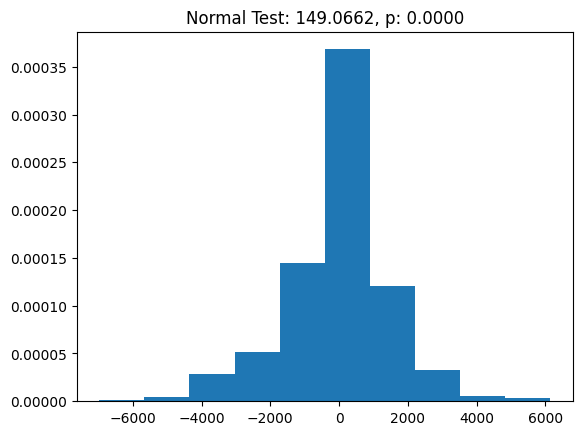

In [594]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
#     standardize_cols = ["trialNumbers"]
#     use_random_slope = True
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())# / learning_df[col].std()

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula,groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

l_results = glm.fit()

print(l_results.summary())
resids = l_results.resid_response if not mixed else l_results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

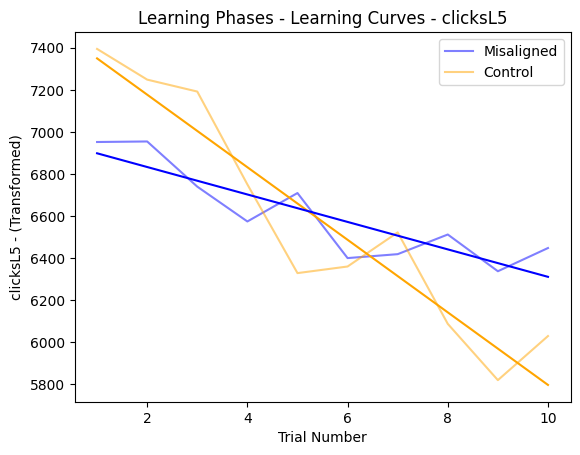

In [595]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = l_results.params['trialNumbers']
b2 = l_results.params['trialNumbers'] + l_results.params['trialNumbers:C(condition)[T.1]']
i1 = l_results.params['Intercept']
i2 = l_results.params['Intercept'] + l_results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                      Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         clicksL5    
No. Observations:         6420            Method:                     REML        
No. Groups:               214             Scale:                      2711091.7618
Min. group size:          30              Log-Likelihood:             -57058.3362 
Max. group size:          30              Converged:                  Yes         
Mean group size:          30.0                                                    
----------------------------------------------------------------------------------
                                  Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------------
Intercept                         6165.497  222.286 27.737 0.000 5729.825 6601.169
C(condition)[T.1]                  312.874  314.359  0.995 0.320 -303.259  929.007
trialNumbers               

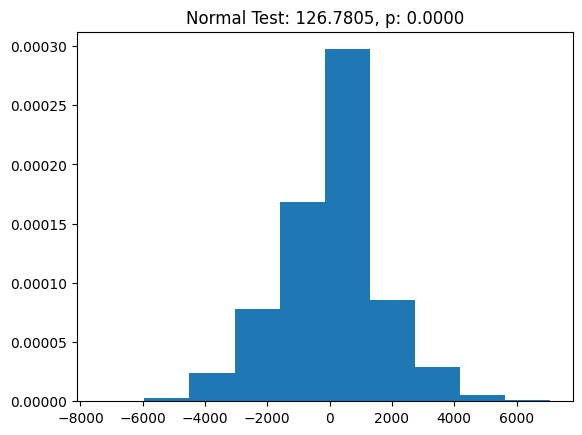

In [596]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""

for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()


# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

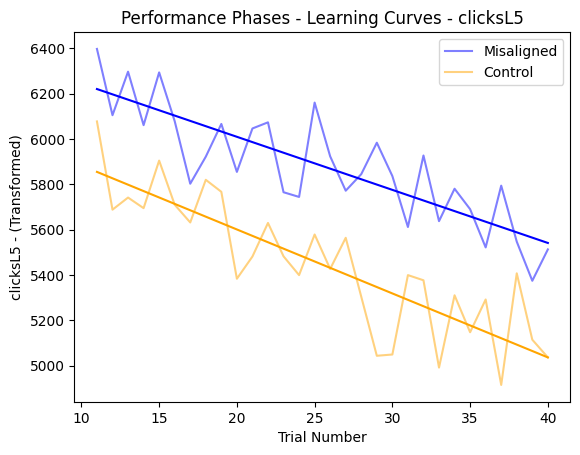

In [597]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

In [598]:
display_formula = "{} ~ trialNumbers*C(condition)".format(response_var)
if use_random_slope: 
    display_formula +=  "+ (1 + trialNumbers|participant)"
else:
    display_formula +=  "+ (1 + participant)"
table = LMM_to_table(l_results, results, "2.2", display_formula, data_to_use_master)

In [599]:
print(table)

\newcommand{\tableMisOrigTwoTwo}{
\begin{table} 
\centering 
	\caption{LMM results for Analysis 2.2} 
	\begin{tabular}{c|CC|CC} 
		\hline 
		\multicolumn{5}{c}{ }\\[-1em] 
		\multicolumn{5}{c}{clicksL5 $\sim$ trialNumbers$*$condition$+$ (1 $+$ participant)}\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		\multirow{2}{*}{\textbf{Regressor}} & \multicolumn{2}{c|}{\textbf{Rapid Learning Phase}} & \multicolumn{2}{c}{\textbf{Slow Improvement Phase}} \\ 
		&&&&\\[-1em] 
		& $\beta$ & $p$ & $\beta$ & $p$\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		Intercept & \textbf{7521.98} & \textbf{0.00} & \textbf{6165.50} & \textbf{0.00} \\ 
		condition & \textbf{-558.24} & \textbf{0.05} & 312.87 & 0.32 \\ 
		trialNumbers & \textbf{-172.44} & \textbf{0.00} & \textbf{-28.24} & \textbf{0.00} \\ 
		trialNumbers:condition & \textbf{107.19} & \textbf{0.00} & 4.81 & 0.31 \\ 
		Var RI & \textbf{1.25} & \textbf{0.00} & \textbf{1.63} & \textbf{0.00} \\ 
		\hline 
	\end{tabular} 
	\label{table:MisOrigTwoTwo} 
\e

# 2.3 - Linear Regression: ClicksL1 vs. Trial Number x Condition

In [600]:
# Select the response variable for this analysis

response_var = "clicksL1"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      clicksL1  
No. Observations:        2140         Method:                  REML      
No. Groups:              214          Scale:                   50.6293   
Min. group size:         10           Log-Likelihood:          -7464.5847
Max. group size:         10           Converged:               Yes       
Mean group size:         10.0                                            
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                      10.365    0.757 13.687 0.000  8.881 11.849
C(condition)[T.1]              -2.039    1.071 -1.904 0.057 -4.138  0.060
trialNumbers                   -0.664    0.076 -8.772 0.000 -0.813 -0.516
trialNumbers:C(condition)[T.1]  0.275    0.107  2.564 0.

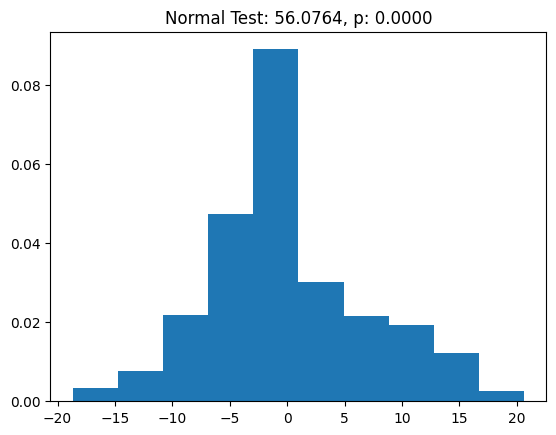

In [601]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())# / learning_df[col].std()

learning_df["clicksL1"] = learning_df["clicksL1"] * 100

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

l_results = glm.fit()

print(l_results.summary())
resids = l_results.resid_response if not mixed else l_results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

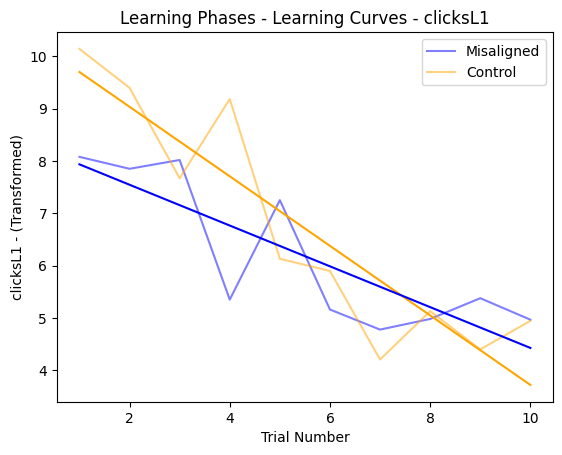

In [602]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = l_results.params['trialNumbers']
b2 = l_results.params['trialNumbers'] + l_results.params['trialNumbers:C(condition)[T.1]']
i1 = l_results.params['Intercept']
i2 = l_results.params['Intercept'] + l_results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      clicksL1   
No. Observations:       6420         Method:                  REML       
No. Groups:             214          Scale:                   22.9403    
Min. group size:        30           Log-Likelihood:          -19579.2142
Max. group size:        30           Converged:               Yes        
Mean group size:        30.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       5.006    0.622  8.051 0.000  3.788  6.225
C(condition)[T.1]              -0.197    0.879 -0.224 0.823 -1.921  1.526
trialNumbers                   -0.079    0.010 -8.085 0.000 -0.098 -0.060
trialNumbers:C(condition)[T.1]  0.034    0.014  2.433 0.

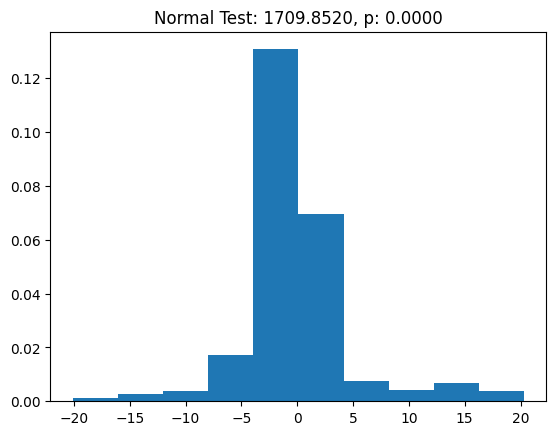

In [603]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""

for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()

    
# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

performance_df["clicksL1"] = performance_df["clicksL1"] * 100

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, re_formula=re_formula, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

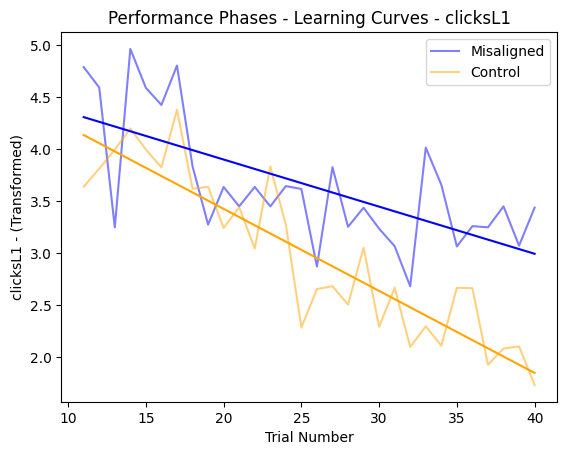

In [604]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

In [605]:
display_formula = "{} ~ trialNumbers*C(condition)".format(response_var)
if use_random_slope: 
    display_formula +=  "+ (1 + trialNumbers|participant)"
else:
    display_formula +=  "+ (1 + participant)"
table = LMM_to_table(l_results, results, "2.3", display_formula, data_to_use_master)

In [607]:
print(table)

\newcommand{\tableMisOrigTwoThree}{
\begin{table} 
\centering 
	\caption{LMM results for Analysis 2.3} 
	\begin{tabular}{c|CC|CC} 
		\hline 
		\multicolumn{5}{c}{ }\\[-1em] 
		\multicolumn{5}{c}{clicksL1 $\sim$ trialNumbers$*$condition$+$ (1 $+$ participant)}\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		\multirow{2}{*}{\textbf{Regressor}} & \multicolumn{2}{c|}{\textbf{Rapid Learning Phase}} & \multicolumn{2}{c}{\textbf{Slow Improvement Phase}} \\ 
		&&&&\\[-1em] 
		& $\beta$ & $p$ & $\beta$ & $p$\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		Intercept & \textbf{10.37} & \textbf{0.00} & \textbf{5.01} & \textbf{0.00} \\ 
		condition & -2.04 & 0.06 & -0.20 & 0.82 \\ 
		trialNumbers & \textbf{-0.66} & \textbf{0.00} & \textbf{-0.08} & \textbf{0.00} \\ 
		trialNumbers:condition & \textbf{0.27} & \textbf{0.01} & \textbf{0.03} & \textbf{0.01} \\ 
		Var RI & \textbf{0.75} & \textbf{0.00} & \textbf{1.48} & \textbf{0.00} \\ 
		\hline 
	\end{tabular} 
	\label{table:MisOrigTwoThree} 
\end{table}

# 2.4 - Linear Regression: Strategy Score vs. Trial Number x Condition

In [608]:
# Select the response variable for this analysis

response_var = "strategyScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores_scaled
No. Observations:   2140      Method:               REML                 
No. Groups:         214       Scale:                0.0061               
Min. group size:    10        Log-Likelihood:       2010.6787            
Max. group size:    10        Converged:            Yes                  
Mean group size:    10.0                                                 
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.625    0.015 40.451 0.000  0.595  0.655
C(condition)[T.1]               0.006    0.022  0.285 0.775 -0.037  0.049
trialNumbers                    0.009    0.001 10.235 0.000  0.007  0.010
trialNumbers:C(condition)[T.1] -0.007    0.001 -5.594 0.

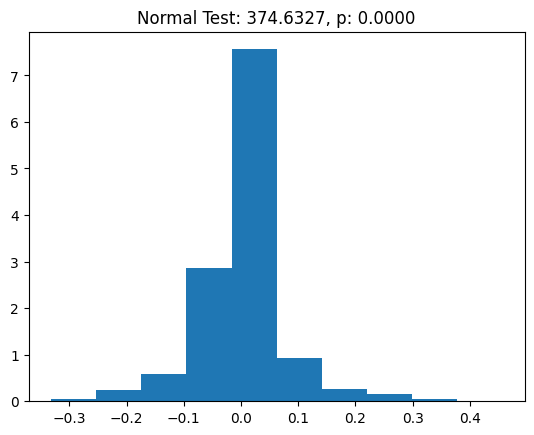

In [609]:
# Learning Phase

use_orig = False

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
re_formula = "trialNumbers" if use_random_slope else ""

# Filter out participants whose click strategies are not valid
learning_df = learning_df.loc[learning_df.clickStratsValid]

for col in standardize_cols:
    learning_df[col] = (learning_df[col] - learning_df[col].mean())# / learning_df[col].std()

    
mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, re_formula=re_formula, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

l_results = glm.fit()

print(l_results.summary())
resids = l_results.resid_response if not mixed else l_results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

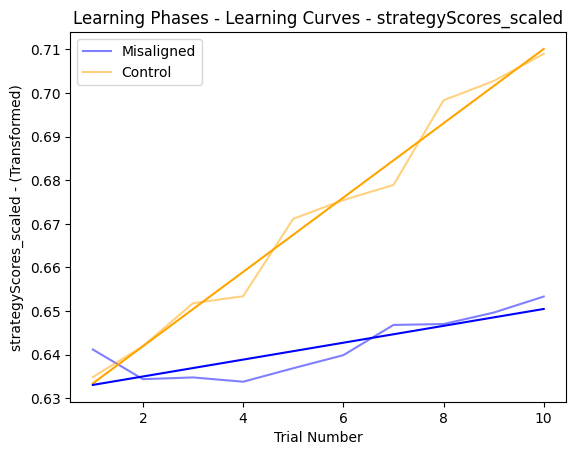

In [610]:
# Plotting the data of both learning phases

x1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = l_results.params['trialNumbers']
b2 = l_results.params['trialNumbers'] + l_results.params['trialNumbers:C(condition)[T.1]']
i1 = l_results.params['Intercept']
i2 = l_results.params['Intercept'] + l_results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores_scaled
No. Observations:   6420      Method:               REML                 
No. Groups:         214       Scale:                0.4503               
Min. group size:    30        Log-Likelihood:       -7127.5756           
Max. group size:    30        Converged:            Yes                  
Mean group size:    30.0                                                 
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       7.138    0.172 41.485 0.000  6.800  7.475
C(condition)[T.1]              -0.661    0.243 -2.715 0.007 -1.138 -0.184
trialNumbers                    0.020    0.001 14.872 0.000  0.018  0.023
trialNumbers:C(condition)[T.1] -0.009    0.002 -4.416 0.

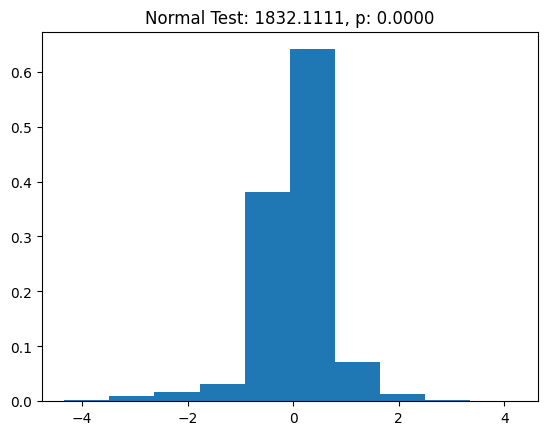

In [611]:
# Performance Phase

use_orig = False

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)

# Select the model based on experiment pre-registration
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)
if data_to_use == "1":
    use_random_slope = False
    standardize_cols = []
else:
    use_random_slope = True
    standardize_cols = ["trialNumbers"]
    
re_formula = "trialNumbers" if use_random_slope else ""

for col in standardize_cols:
    performance_df[col] = (performance_df[col] - performance_df[col].mean())#}/learning_df[col].std()
    
# Filter out participants whose click strategies are not valid
performance_df = performance_df.loc[performance_df.clickStratsValid]

performance_df[response_var] = performance_df[response_var] * 10

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, re_formula=re_formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

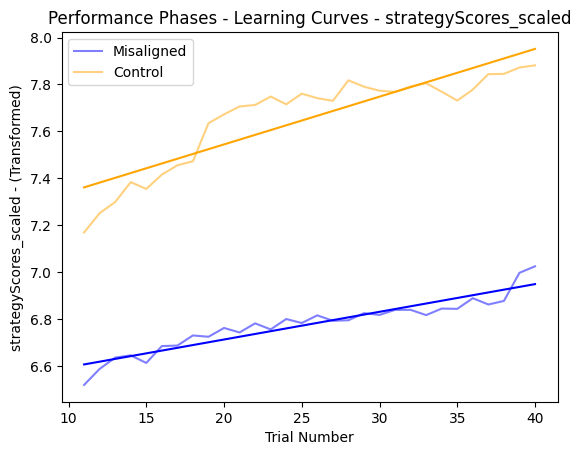

In [612]:
# Plotting the data of both performance phases together

x1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True).index
x2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True).index
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

In [613]:
display_formula = "{} ~ trialNumbers*C(condition)".format(response_var)
if use_random_slope: 
    display_formula +=  "+ (1 + trialNumbers|participant)"
else:
    display_formula +=  "+ (1 + participant)"
table = LMM_to_table(l_results, results, "2.4", display_formula, data_to_use_master)

In [614]:
print(table)

\newcommand{\tableMisOrigTwoFour}{
\begin{table} 
\centering 
	\caption{LMM results for Analysis 2.4} 
	\begin{tabular}{c|CC|CC} 
		\hline 
		\multicolumn{5}{c}{ }\\[-1em] 
		\multicolumn{5}{c}{strategyScores\_scaled $\sim$ trialNumbers$*$condition$+$ (1 $+$ participant)}\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		\multirow{2}{*}{\textbf{Regressor}} & \multicolumn{2}{c|}{\textbf{Rapid Learning Phase}} & \multicolumn{2}{c}{\textbf{Slow Improvement Phase}} \\ 
		&&&&\\[-1em] 
		& $\beta$ & $p$ & $\beta$ & $p$\\ 
		&&&&\\[-1em] 
		\hline 
		&&&&\\[-1em] 
		Intercept & \textbf{0.62} & \textbf{0.00} & \textbf{7.14} & \textbf{0.00} \\ 
		condition & 0.01 & 0.78 & \textbf{-0.66} & \textbf{0.01} \\ 
		trialNumbers & \textbf{0.01} & \textbf{0.00} & \textbf{0.02} & \textbf{0.00} \\ 
		trialNumbers:condition & \textbf{-0.01} & \textbf{0.00} & \textbf{-0.01} & \textbf{0.00} \\ 
		Var RI & \textbf{3.71} & \textbf{0.00} & \textbf{6.71} & \textbf{0.00} \\ 
		\hline 
	\end{tabular} 
	\label{table:

# Appendix

# 1.5 - GLM Strategy Proportions

Observing how the strategies of the participants (as inferred by the Computational Microscope) change over time in each condition

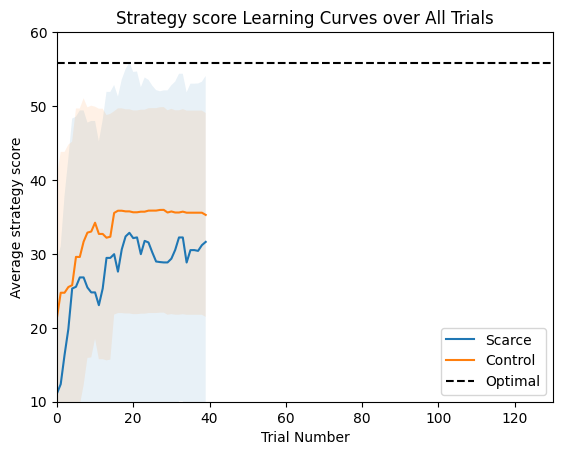

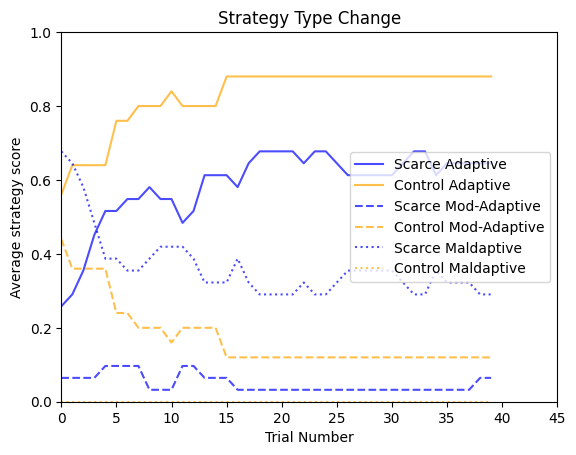

In [151]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

scarce_trial_group = data_to_copy.loc[data_to_copy.condition == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.condition == 0].groupby('trialNumbers')

# Taking the mean expected score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean(numeric_only=True)["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std(numeric_only=True)["strategyScores"])
control_data = np.array(control_trial_group.mean(numeric_only=True)["strategyScores"])
control_data_sd = np.array(control_trial_group.std(numeric_only=True)["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())


plt.figure()
plt.title("Strategy score Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.axhline(np.max(np.array(strategy_scores_control_list)[:,1], axis=0), color='k', label='Optimal', linestyle="--")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Scarce Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Scarce Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Scarce Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 45])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()


In [294]:
# Setting up logistic regression

data_to_copy = analysis_data.copy()
data_to_copy["cluster"] = data_to_copy["cluster"].astype("int64")

formula = "cluster ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

model_1 = statsmodels.discrete.discrete_model.MNLogit.from_formula(formula, data_to_copy)
model_1_fit = model.fit()

endog = analysis_data["cluster"].astype("int64").map(lambda c: ["cat","dog","bear"][c])
exog = analysis_data[["trialNumbers", "scarce"]]
exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
exog["const"] = [1] * len(exog)

model_2 = statsmodels.discrete.discrete_model.MNLogit(endog, exog)
model_2_fit = model.fit()

print(model_1_fit.summary())
print(model_2_fit.summary())

Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["const"] = [1] * len(exog)


                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.8616      0.145    -12.815      0.000      -2.146      -1.577
C(scarce)[T.1]                 -0.4777      0.167     -2.858      0.004      -0.

In [295]:
sum(model_2.endog == model_1.endog) / len(model_2.endog)

0.0